In [1]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug

In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  1.5.0


In [3]:
import os
from os.path import join
from PIL import Image, ImageFilter
import json
import random
import itertools
import re
import datetime
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import cv2
import glob

In [4]:
import string 
from collections import Counter
characters = sorted(list(set(Counter(string.ascii_letters).keys())))
digits = sorted(list(set(Counter(string.digits).keys())))
whitespace = sorted(list(set(Counter(string.whitespace).keys())))
characters.extend(digits)
characters.extend(whitespace)
letters = characters
print(letters)
print(len(letters))


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\t', '\n', '\x0b', '\x0c', '\r', ' ']
68


In [5]:
# dataset parameters 
img_width = img_height = 28
num_channels = 1
annotation_train = './mjsynth_dataset/annotation_train_small_100.txt'
batch_size = 128

In [6]:
class Dataset:
    def __init__(self, directory, img_height, img_width, batch_size, num_output):
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_output = num_output
        self.directory = directory
        print("Image Height: " + str(self.img_height))
        print("Image Width: " + str(self.img_width))
        print("Batch Size: " + str(self.batch_size))
        print("Data Root Directory: " + directory + "\n\n")
        
        # self.imgs, self.labels = build_data([file for file ])
        self.n = len([file for file in os.listdir(self.directory)])
        self.indexes = list(range(self.n))
        self.current_index = 0
        
    def get_data(self):
        imgs = []
        labels = []
        encoded_labels = []
        encoded_label_strings = []
        self.n = 0
        
        with open(annotation_train, 'r') as fp:
            for line in fp:
                self.n = self.n + 1
                filename = line.split(' ')[0]
                img = cv2.imread(filename, 0)
                if img is None:
                    print("File " + filename + " cannot be opened")
                    continue
                #print("Image Shape Before Resize: " + str(img.shape))
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (self.img_width, self.img_height))
                #print("Image Shape After Resize: " + str(img.shape))
                img = img.astype(np.float32)
                img /= 255
                
                parsed_filename = filename.split("_") # filename is in format number_label_numbe
                label = parsed_filename[2]
                # label filler
                
                print("Label filler: " + letters[len(letters)-1])
#                 for i in range(32 - len(label)%32):
#                     label_filler =+ '\x0b'
                label_filler = np.chararray(32 - len(label)%32)
                label_filler[:] = '\x0b'
                # label.append(label_filler)
                
                encoded_label = np.asarray(list(map(lambda x: letters.index(x), label)))
                encoded_label_filler = np.asarray(list(map(lambda x: letters.index(x), label_filler)))
                encoded_label.append(label_filler)
                encoded_label = encoded_label.astype(np.int32)
                encoded_label_string = ' '.join(str(x) for x in encoded_label.tolist())

                # print data
    #             print("Filepath: " + filepath)
    #             print("Label: " + label + " | Encoded Label: " + str(encoded_label))
    #             print("Encoded Label String: " + encoded_label_string)
    #             plt.imshow(img)
    #             plt.show()

                # store data
                imgs.append(img)
                labels.append(label)
                encoded_labels.append(encoded_label)
                encoded_label_strings.append(encoded_label_string)
                
            self.indexes = list(range(self.n))
            self.current_index = 0
            self.imgs = np.asarray(imgs, dtype=np.float32)
            self.labels = np.asarray(labels, dtype=object)
            self.encoded_labels = np.asarray(encoded_labels)
            self.encoded_label_strings = np.asarray(encoded_label_strings).reshape(self.n, 1)
            return
    
    def build_data(self):
        imgs = []
        labels = []
        encoded_labels = []
        encoded_label_strings = []
        for filename in os.listdir(self.directory):
            # get data
            filepath = self.directory + filename
            print(filepath)
            img = cv2.imread(filepath, 0)
            print("Image Shape Before Resize: " + str(img.shape))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_width, self.img_height))
            print("Image Shape After Resize: " + str(img.shape))
            img = img.astype(np.float32)
            img /= 255
            parsed_filename = filename.split("_") # filename is in format number_label_number
            label = parsed_filename[1]
            encoded_label = np.asarray(list(map(lambda x: letters.index(x), label)))
            encoded_label = np.pad(encoded_label, (0, 32 - len(encoded_label)%32), mode='constant')
            encoded_label = encoded_label.astype(np.int32)
            encoded_label_string = ' '.join(str(x) for x in encoded_label.tolist())
            
            # print data
            print("Filepath: " + filepath)
            print("Label: " + label + " | Encoded Label: " + str(encoded_label))
            print("Encoded Label String: " + encoded_label_string)
            plt.imshow(img)
            plt.show()

            # store data
            imgs.append(img)
            labels.append(label)
            encoded_labels.append(encoded_label)
            encoded_label_strings.append(encoded_label_string)
          
        self.imgs = np.asarray(imgs, dtype=np.float32)
        self.labels = np.asarray(labels, dtype=object)
        self.encoded_labels = np.asarray(encoded_labels)
        self.encoded_label_strings = np.asarray(encoded_label_strings).reshape(self.n, 1)
        return
    
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.current_index = self.current_index + 1
        if self.current_index >= self.n:
            print("Shuffle Indexes")
            self.current_index = 0
            random.shuffle(self.indexes)
        sample_index = self.indexes[self.current_index]
        #print("Current Index: " + str(self.current_index) + " Sample Index: " + str(sample_index))
        return self.imgs[sample_index], self.encoded_labels[sample_index]
    
    def next_batch(self):
        #print("# of Samples: " + str(self.n))
        X = []
        Y = []
        for i in range(self.batch_size):
            x, y = self.next_sample()
            X.append(x)
            Y.append(y)
        X = np.asarray(X, dtype=np.float32)
        Y = np.asarray(Y)
        #print("Batch images shape: " + str(X.shape))
        #print("Batch labels shape: " + str(Y.shape))
        return [X, Y]

Image Height: 28
Image Width: 28
Batch Size: 128
Data Root Directory: ./mjsynth_dataset/train/


./mjsynth_dataset/train/100_PEDERASTS_56228.jpg
Image Shape Before Resize: (31, 149)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/100_PEDERASTS_56228.jpg
Label: PEDERASTS | Encoded Label: [15  4  3  4 17  0 18 19 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 4 3 4 17 0 18 19 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


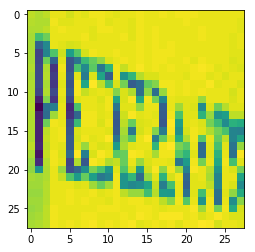

./mjsynth_dataset/train/101_TELEPHONING_77987.jpg
Image Shape Before Resize: (31, 147)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/101_TELEPHONING_77987.jpg
Label: TELEPHONING | Encoded Label: [19  4 11  4 15  7 14 13  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 4 11 4 15 7 14 13 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


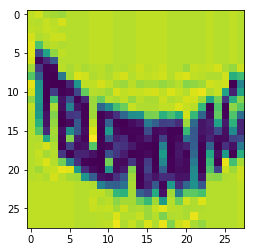

./mjsynth_dataset/train/102_INFLUENTIALLY_39404.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/102_INFLUENTIALLY_39404.jpg
Label: INFLUENTIALLY | Encoded Label: [ 8 13  5 11 20  4 13 19  8  0 11 11 24  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 13 5 11 20 4 13 19 8 0 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


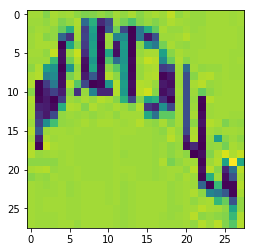

./mjsynth_dataset/train/103_SCRIPTURES_68695.jpg
Image Shape Before Resize: (31, 161)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/103_SCRIPTURES_68695.jpg
Label: SCRIPTURES | Encoded Label: [18  2 17  8 15 19 20 17  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 2 17 8 15 19 20 17 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


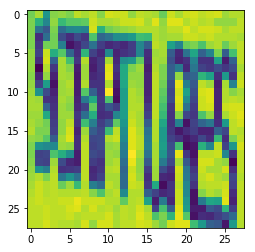

./mjsynth_dataset/train/104_Greeter_33659.jpg
Image Shape Before Resize: (31, 83)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/104_Greeter_33659.jpg
Label: Greeter | Encoded Label: [ 6 43 30 30 45 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 43 30 30 45 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


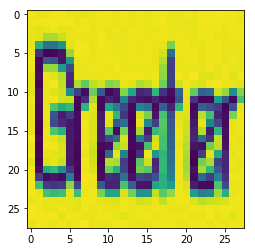

./mjsynth_dataset/train/105_Houri_37037.jpg
Image Shape Before Resize: (31, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/105_Houri_37037.jpg
Label: Houri | Encoded Label: [ 7 40 46 43 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 40 46 43 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


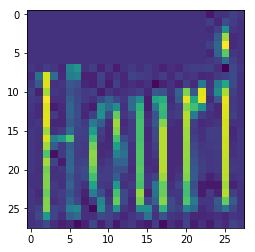

./mjsynth_dataset/train/106_LOBBED_44967.jpg
Image Shape Before Resize: (31, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/106_LOBBED_44967.jpg
Label: LOBBED | Encoded Label: [11 14  1  1  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 14 1 1 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


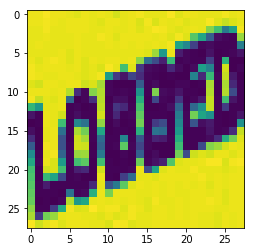

./mjsynth_dataset/train/107_scars_68194.jpg
Image Shape Before Resize: (32, 73)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/107_scars_68194.jpg
Label: scars | Encoded Label: [44 28 26 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 28 26 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


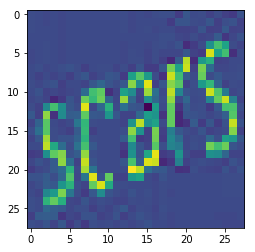

./mjsynth_dataset/train/108_SPICIER_73372.jpg
Image Shape Before Resize: (32, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/108_SPICIER_73372.jpg
Label: SPICIER | Encoded Label: [18 15  8  2  8  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 15 8 2 8 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


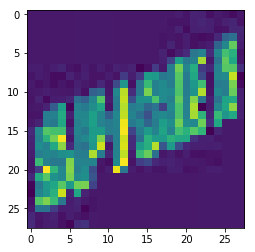

./mjsynth_dataset/train/109_KABOOM_42059.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/109_KABOOM_42059.jpg
Label: KABOOM | Encoded Label: [10  0  1 14 14 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 0 1 14 14 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


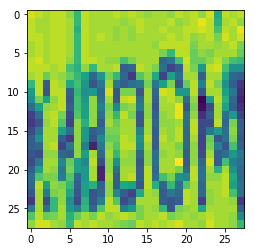

./mjsynth_dataset/train/10_ROOMIER_66612.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/10_ROOMIER_66612.jpg
Label: ROOMIER | Encoded Label: [17 14 14 12  8  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 14 14 12 8 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


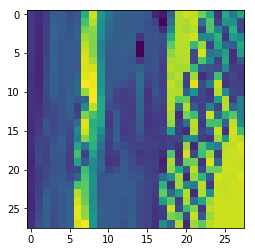

./mjsynth_dataset/train/110_WEBB_85848.jpg
Image Shape Before Resize: (31, 57)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/110_WEBB_85848.jpg
Label: WEBB | Encoded Label: [22  4  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 4 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


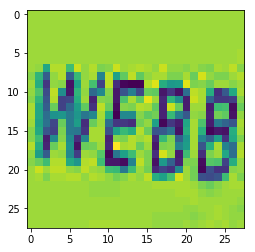

./mjsynth_dataset/train/111_Brailles_9175.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/111_Brailles_9175.jpg
Label: Brailles | Encoded Label: [ 1 43 26 34 37 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 43 26 34 37 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


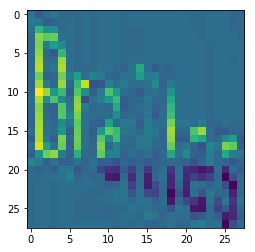

./mjsynth_dataset/train/112_ballad_5621.jpg
Image Shape Before Resize: (31, 70)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/112_ballad_5621.jpg
Label: ballad | Encoded Label: [27 26 37 37 26 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 26 37 37 26 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


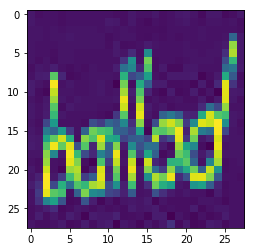

./mjsynth_dataset/train/113_Poincare_58489.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/113_Poincare_58489.jpg
Label: Poincare | Encoded Label: [15 40 34 39 28 26 43 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 40 34 39 28 26 43 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


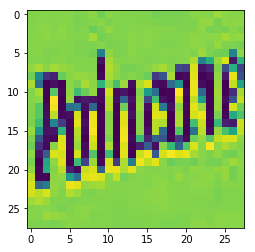

./mjsynth_dataset/train/114_DUBBED_23983.jpg
Image Shape Before Resize: (32, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/114_DUBBED_23983.jpg
Label: DUBBED | Encoded Label: [ 3 20  1  1  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 20 1 1 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


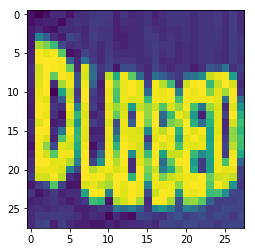

./mjsynth_dataset/train/115_EMULATED_25487.jpg
Image Shape Before Resize: (31, 139)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/115_EMULATED_25487.jpg
Label: EMULATED | Encoded Label: [ 4 12 20 11  0 19  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 12 20 11 0 19 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


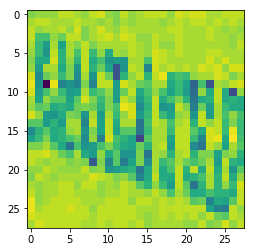

./mjsynth_dataset/train/116_Beatifies_6456.jpg
Image Shape Before Resize: (31, 135)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/116_Beatifies_6456.jpg
Label: Beatifies | Encoded Label: [ 1 30 26 45 34 31 34 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 30 26 45 34 31 34 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


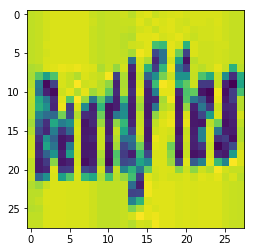

./mjsynth_dataset/train/117_foursomes_30531.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/117_foursomes_30531.jpg
Label: foursomes | Encoded Label: [31 40 46 43 44 40 38 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 40 46 43 44 40 38 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


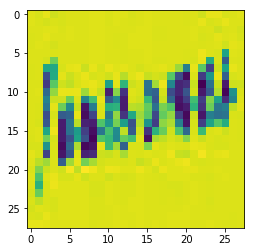

./mjsynth_dataset/train/118_Comfier_15126.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/118_Comfier_15126.jpg
Label: Comfier | Encoded Label: [ 2 40 38 31 34 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 38 31 34 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


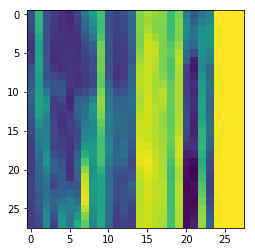

./mjsynth_dataset/train/119_plinth_58269.jpg
Image Shape Before Resize: (31, 68)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/119_plinth_58269.jpg
Label: plinth | Encoded Label: [41 37 34 39 45 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 37 34 39 45 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


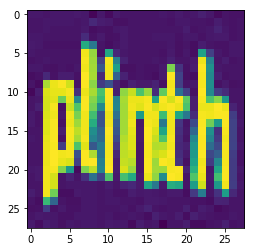

./mjsynth_dataset/train/11_greyhound_33696.jpg
Image Shape Before Resize: (31, 219)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/11_greyhound_33696.jpg
Label: greyhound | Encoded Label: [32 43 30 50 33 40 46 39 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 32 43 30 50 33 40 46 39 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


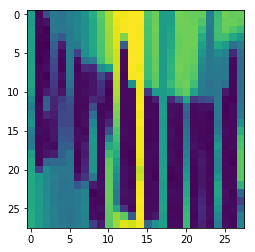

./mjsynth_dataset/train/120_Averaging_5062.jpg
Image Shape Before Resize: (31, 143)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/120_Averaging_5062.jpg
Label: Averaging | Encoded Label: [ 0 47 30 43 26 32 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 47 30 43 26 32 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


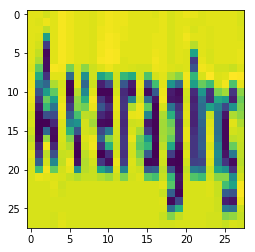

./mjsynth_dataset/train/121_BOLLOCKING_8574.jpg
Image Shape Before Resize: (31, 196)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/121_BOLLOCKING_8574.jpg
Label: BOLLOCKING | Encoded Label: [ 1 14 11 11 14  2 10  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 14 11 11 14 2 10 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


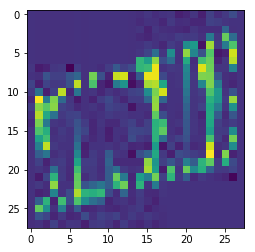

./mjsynth_dataset/train/122_downgrades_23506.jpg
Image Shape Before Resize: (31, 129)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/122_downgrades_23506.jpg
Label: downgrades | Encoded Label: [29 40 48 39 32 43 26 29 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 40 48 39 32 43 26 29 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


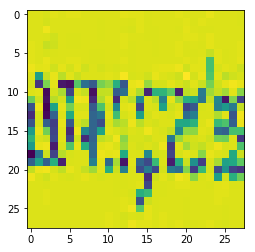

./mjsynth_dataset/train/123_QUIBBLER_61840.jpg
Image Shape Before Resize: (31, 156)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/123_QUIBBLER_61840.jpg
Label: QUIBBLER | Encoded Label: [16 20  8  1  1 11  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 16 20 8 1 1 11 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


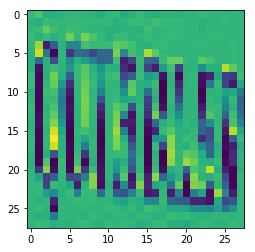

./mjsynth_dataset/train/124_FREETHINKER_30788.jpg
Image Shape Before Resize: (31, 187)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/124_FREETHINKER_30788.jpg
Label: FREETHINKER | Encoded Label: [ 5 17  4  4 19  7  8 13 10  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 17 4 4 19 7 8 13 10 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


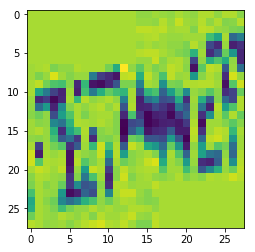

./mjsynth_dataset/train/125_Heisted_35657.jpg
Image Shape Before Resize: (31, 70)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/125_Heisted_35657.jpg
Label: Heisted | Encoded Label: [ 7 30 34 44 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 30 34 44 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


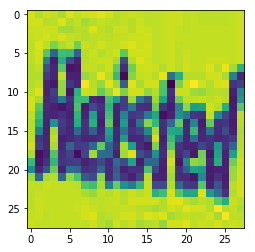

./mjsynth_dataset/train/126_JED_41350.jpg
Image Shape Before Resize: (32, 60)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/126_JED_41350.jpg
Label: JED | Encoded Label: [9 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Encoded Label String: 9 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


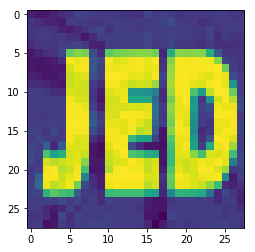

./mjsynth_dataset/train/127_Airliners_1768.jpg
Image Shape Before Resize: (31, 64)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/127_Airliners_1768.jpg
Label: Airliners | Encoded Label: [ 0 34 43 37 34 39 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 34 43 37 34 39 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


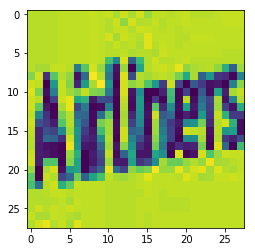

./mjsynth_dataset/train/128_CONFEDERATED_15874.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/128_CONFEDERATED_15874.jpg
Label: CONFEDERATED | Encoded Label: [ 2 14 13  5  4  3  4 17  0 19  4  3  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 13 5 4 3 4 17 0 19 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


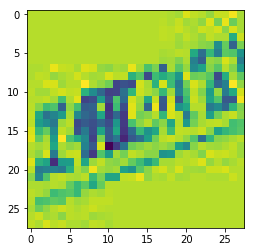

./mjsynth_dataset/train/129_Prioritize_60148.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/129_Prioritize_60148.jpg
Label: Prioritize | Encoded Label: [15 43 34 40 43 34 45 34 51 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 43 34 40 43 34 45 34 51 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


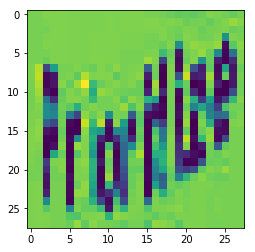

./mjsynth_dataset/train/12_Bittiest_7736.jpg
Image Shape Before Resize: (31, 91)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/12_Bittiest_7736.jpg
Label: Bittiest | Encoded Label: [ 1 34 45 45 34 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 34 45 45 34 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


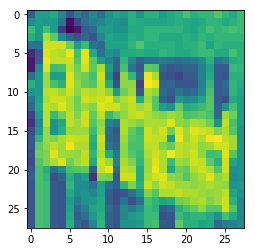

./mjsynth_dataset/train/130_NONFLUCTUATING_52018.jpg
Image Shape Before Resize: (31, 127)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/130_NONFLUCTUATING_52018.jpg
Label: NONFLUCTUATING | Encoded Label: [13 14 13  5 11 20  2 19 20  0 19  8 13  6  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 14 13 5 11 20 2 19 20 0 19 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


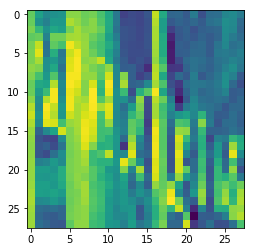

./mjsynth_dataset/train/131_grosgrain_33863.jpg
Image Shape Before Resize: (31, 189)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/131_grosgrain_33863.jpg
Label: grosgrain | Encoded Label: [32 43 40 44 32 43 26 34 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 32 43 40 44 32 43 26 34 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


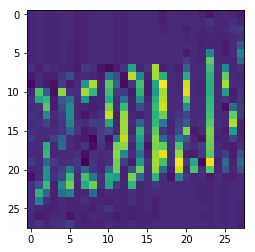

./mjsynth_dataset/train/132_LOVECHILD_45395.jpg
Image Shape Before Resize: (31, 108)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/132_LOVECHILD_45395.jpg
Label: LOVECHILD | Encoded Label: [11 14 21  4  2  7  8 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 14 21 4 2 7 8 11 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


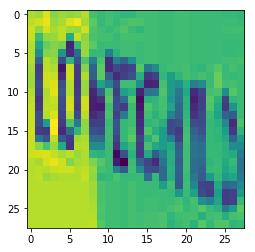

./mjsynth_dataset/train/133_MEDICATIONS_47511.jpg
Image Shape Before Resize: (31, 242)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/133_MEDICATIONS_47511.jpg
Label: MEDICATIONS | Encoded Label: [12  4  3  8  2  0 19  8 14 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 4 3 8 2 0 19 8 14 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


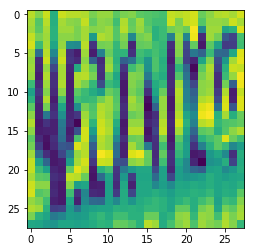

./mjsynth_dataset/train/134_ERUPTIVE_26464.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/134_ERUPTIVE_26464.jpg
Label: ERUPTIVE | Encoded Label: [ 4 17 20 15 19  8 21  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 17 20 15 19 8 21 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


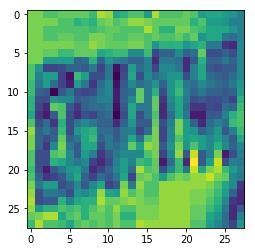

./mjsynth_dataset/train/135_Sires_71142.jpg
Image Shape Before Resize: (31, 64)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/135_Sires_71142.jpg
Label: Sires | Encoded Label: [18 34 43 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 34 43 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


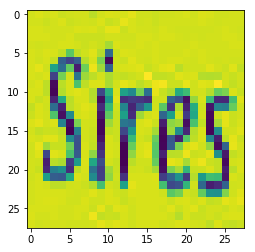

./mjsynth_dataset/train/136_bernoulli_7088.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/136_bernoulli_7088.jpg
Label: bernoulli | Encoded Label: [27 30 43 39 40 46 37 37 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 30 43 39 40 46 37 37 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


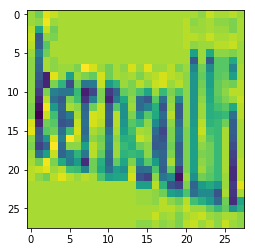

./mjsynth_dataset/train/137_Tautly_77712.jpg
Image Shape Before Resize: (31, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/137_Tautly_77712.jpg
Label: Tautly | Encoded Label: [19 26 46 45 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 26 46 45 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


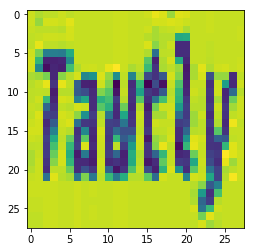

./mjsynth_dataset/train/138_DEICES_20196.jpg
Image Shape Before Resize: (31, 73)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/138_DEICES_20196.jpg
Label: DEICES | Encoded Label: [ 3  4  8  2  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 4 8 2 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


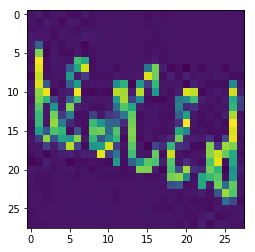

./mjsynth_dataset/train/139_Anarchic_2682.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/139_Anarchic_2682.jpg
Label: Anarchic | Encoded Label: [ 0 39 26 43 28 33 34 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 39 26 43 28 33 34 28 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


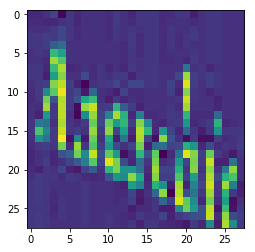

./mjsynth_dataset/train/13_Amoral_2534.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/13_Amoral_2534.jpg
Label: Amoral | Encoded Label: [ 0 38 40 43 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 38 40 43 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


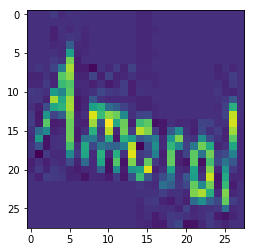

./mjsynth_dataset/train/140_scale_68066.jpg
Image Shape Before Resize: (32, 72)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/140_scale_68066.jpg
Label: scale | Encoded Label: [44 28 26 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 28 26 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


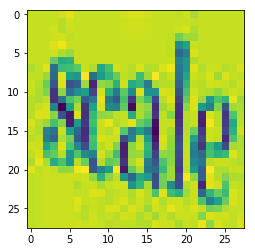

./mjsynth_dataset/train/141_Redcoat_63471.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/141_Redcoat_63471.jpg
Label: Redcoat | Encoded Label: [17 30 29 28 40 26 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 29 28 40 26 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


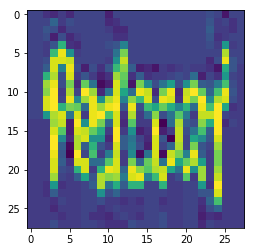

./mjsynth_dataset/train/142_peafowls_56126.jpg
Image Shape Before Resize: (31, 137)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/142_peafowls_56126.jpg
Label: peafowls | Encoded Label: [41 30 26 31 40 48 37 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 30 26 31 40 48 37 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


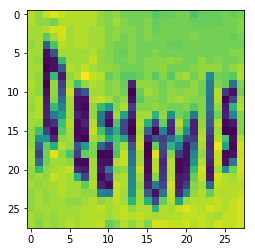

./mjsynth_dataset/train/143_AUSCULTATED_4886.jpg
Image Shape Before Resize: (31, 50)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/143_AUSCULTATED_4886.jpg
Label: AUSCULTATED | Encoded Label: [ 0 20 18  2 20 11 19  0 19  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 20 18 2 20 11 19 0 19 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


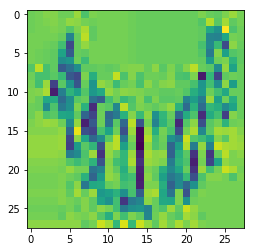

./mjsynth_dataset/train/144_KNOCKWURST_42774.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/144_KNOCKWURST_42774.jpg
Label: KNOCKWURST | Encoded Label: [10 13 14  2 10 22 20 17 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 13 14 2 10 22 20 17 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


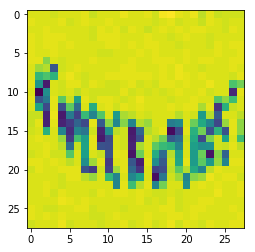

./mjsynth_dataset/train/145_Charmers_12803.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/145_Charmers_12803.jpg
Label: Charmers | Encoded Label: [ 2 33 26 43 38 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 33 26 43 38 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


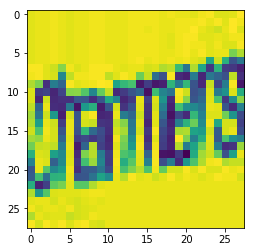

./mjsynth_dataset/train/146_AXOLOTLS_5195.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/146_AXOLOTLS_5195.jpg
Label: AXOLOTLS | Encoded Label: [ 0 23 14 11 14 19 11 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 23 14 11 14 19 11 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


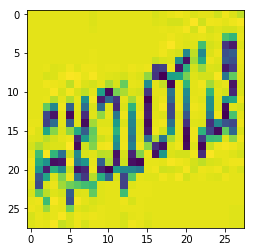

./mjsynth_dataset/train/147_TASTEFULLY_77636.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/147_TASTEFULLY_77636.jpg
Label: TASTEFULLY | Encoded Label: [19  0 18 19  4  5 20 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 0 18 19 4 5 20 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


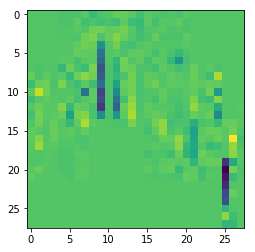

./mjsynth_dataset/train/148_SPLINTING_73570.jpg
Image Shape Before Resize: (31, 135)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/148_SPLINTING_73570.jpg
Label: SPLINTING | Encoded Label: [18 15 11  8 13 19  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 15 11 8 13 19 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


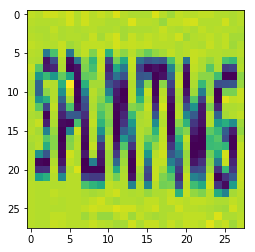

./mjsynth_dataset/train/149_MATHIES_47130.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/149_MATHIES_47130.jpg
Label: MATHIES | Encoded Label: [12  0 19  7  8  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 0 19 7 8 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


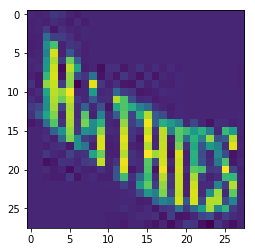

./mjsynth_dataset/train/14_OUTPLAY_54125.jpg
Image Shape Before Resize: (31, 129)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/14_OUTPLAY_54125.jpg
Label: OUTPLAY | Encoded Label: [14 20 19 15 11  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 20 19 15 11 0 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


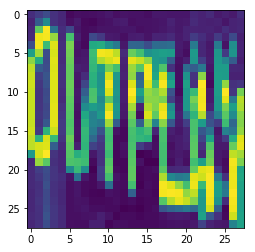

./mjsynth_dataset/train/150_REFORGED_63861.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/150_REFORGED_63861.jpg
Label: REFORGED | Encoded Label: [17  4  5 14 17  6  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 5 14 17 6 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


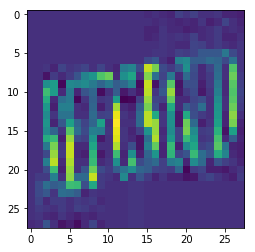

./mjsynth_dataset/train/151_HOLLY_36520.jpg
Image Shape Before Resize: (31, 76)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/151_HOLLY_36520.jpg
Label: HOLLY | Encoded Label: [ 7 14 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 14 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


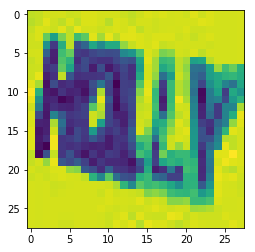

./mjsynth_dataset/train/152_Unmemorable_82881.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/152_Unmemorable_82881.jpg
Label: Unmemorable | Encoded Label: [20 39 38 30 38 40 43 26 27 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 38 30 38 40 43 26 27 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


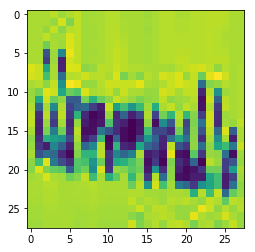

./mjsynth_dataset/train/153_XREFFED_87570.jpg
Image Shape Before Resize: (31, 101)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/153_XREFFED_87570.jpg
Label: XREFFED | Encoded Label: [23 17  4  5  5  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 23 17 4 5 5 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


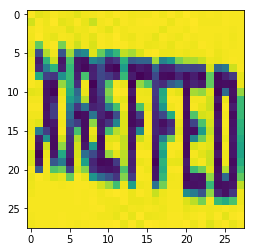

./mjsynth_dataset/train/154_Jells_41381.jpg
Image Shape Before Resize: (31, 159)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/154_Jells_41381.jpg
Label: Jells | Encoded Label: [ 9 30 37 37 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 9 30 37 37 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


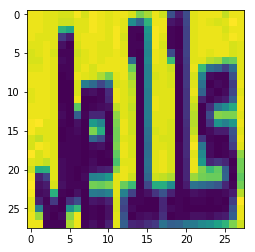

./mjsynth_dataset/train/155_EROTICA_26423.jpg
Image Shape Before Resize: (31, 108)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/155_EROTICA_26423.jpg
Label: EROTICA | Encoded Label: [ 4 17 14 19  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 17 14 19 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


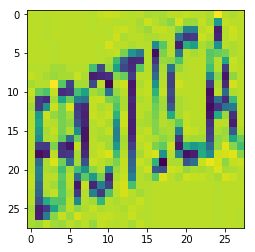

./mjsynth_dataset/train/156_shitty_70320.jpg
Image Shape Before Resize: (31, 75)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/156_shitty_70320.jpg
Label: shitty | Encoded Label: [44 33 34 45 45 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 33 34 45 45 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


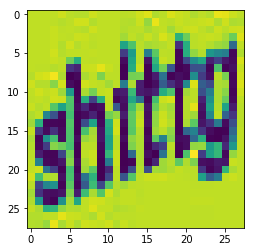

./mjsynth_dataset/train/157_Repleted_64832.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/157_Repleted_64832.jpg
Label: Repleted | Encoded Label: [17 30 41 37 30 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 41 37 30 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


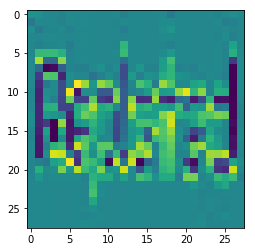

./mjsynth_dataset/train/158_Knolls_42777.jpg
Image Shape Before Resize: (31, 67)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/158_Knolls_42777.jpg
Label: Knolls | Encoded Label: [10 39 40 37 37 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 39 40 37 37 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


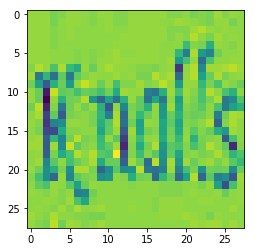

./mjsynth_dataset/train/159_RIBS_65981.jpg
Image Shape Before Resize: (31, 108)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/159_RIBS_65981.jpg
Label: RIBS | Encoded Label: [17  8  1 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 8 1 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


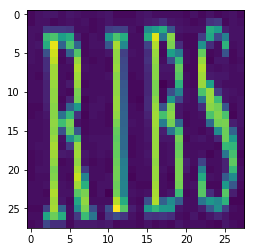

./mjsynth_dataset/train/15_Osages_53840.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/15_Osages_53840.jpg
Label: Osages | Encoded Label: [14 44 26 32 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 44 26 32 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


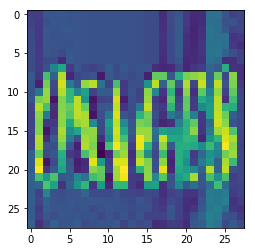

./mjsynth_dataset/train/160_Whisking_86319.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/160_Whisking_86319.jpg
Label: Whisking | Encoded Label: [22 33 34 44 36 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 33 34 44 36 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


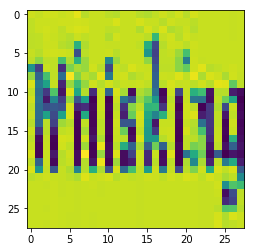

./mjsynth_dataset/train/161_Overflow_54479.jpg
Image Shape Before Resize: (31, 170)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/161_Overflow_54479.jpg
Label: Overflow | Encoded Label: [14 47 30 43 31 37 40 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 47 30 43 31 37 40 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


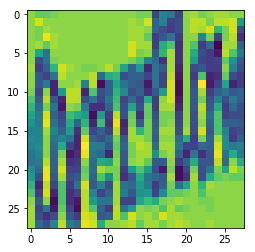

./mjsynth_dataset/train/162_OCCUPIER_52989.jpg
Image Shape Before Resize: (31, 122)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/162_OCCUPIER_52989.jpg
Label: OCCUPIER | Encoded Label: [14  2  2 20 15  8  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 2 2 20 15 8 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


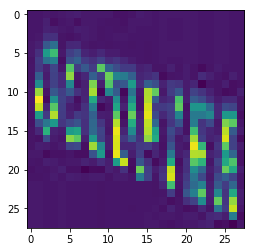

./mjsynth_dataset/train/163_sledged_71582.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/163_sledged_71582.jpg
Label: sledged | Encoded Label: [44 37 30 29 32 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 37 30 29 32 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


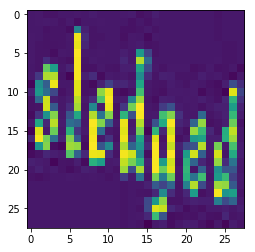

./mjsynth_dataset/train/164_SECANTS_68990.jpg
Image Shape Before Resize: (31, 111)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/164_SECANTS_68990.jpg
Label: SECANTS | Encoded Label: [18  4  2  0 13 19 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 4 2 0 13 19 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


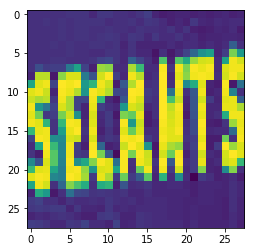

./mjsynth_dataset/train/165_steadying_74438.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/165_steadying_74438.jpg
Label: steadying | Encoded Label: [44 45 30 26 29 50 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 45 30 26 29 50 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


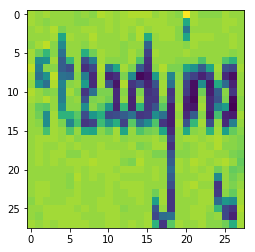

./mjsynth_dataset/train/166_Smartly_71943.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/166_Smartly_71943.jpg
Label: Smartly | Encoded Label: [18 38 26 43 45 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 38 26 43 45 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


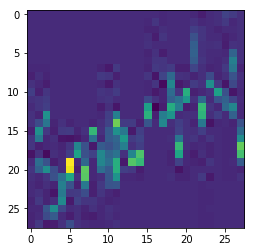

./mjsynth_dataset/train/167_norris_52266.jpg
Image Shape Before Resize: (31, 75)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/167_norris_52266.jpg
Label: norris | Encoded Label: [39 40 43 43 34 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 39 40 43 43 34 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


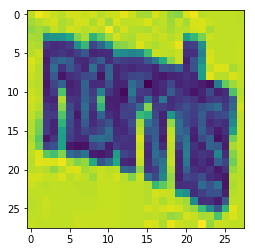

./mjsynth_dataset/train/168_oarlock_52714.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/168_oarlock_52714.jpg
Label: oarlock | Encoded Label: [40 26 43 37 40 28 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 40 26 43 37 40 28 36 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


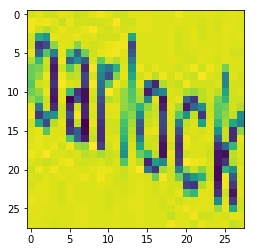

./mjsynth_dataset/train/169_Reflations_63830.jpg
Image Shape Before Resize: (31, 100)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/169_Reflations_63830.jpg
Label: Reflations | Encoded Label: [17 30 31 37 26 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 31 37 26 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


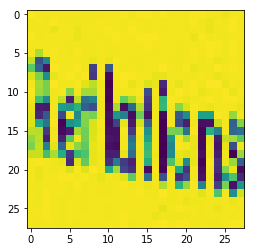

./mjsynth_dataset/train/16_cattery_12089.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/16_cattery_12089.jpg
Label: cattery | Encoded Label: [28 26 45 45 30 43 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 26 45 45 30 43 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


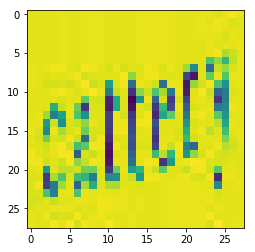

./mjsynth_dataset/train/170_Distentions_22744.jpg
Image Shape Before Resize: (31, 157)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/170_Distentions_22744.jpg
Label: Distentions | Encoded Label: [ 3 34 44 45 30 39 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 44 45 30 39 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


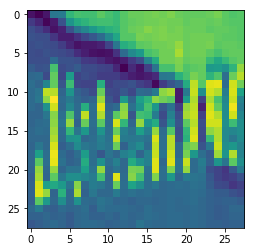

./mjsynth_dataset/train/171_Neoconservatives_51282.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/171_Neoconservatives_51282.jpg
Label: Neoconservatives | Encoded Label: [13 30 40 28 40 39 44 30 43 47 26 45 34 47 30 44  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 30 40 28 40 39 44 30 43 47 26 45 34 47 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


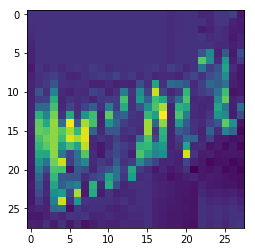

./mjsynth_dataset/train/172_Trefoil_80492.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/172_Trefoil_80492.jpg
Label: Trefoil | Encoded Label: [19 43 30 31 40 34 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 43 30 31 40 34 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


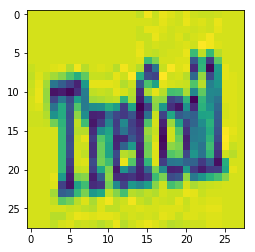

./mjsynth_dataset/train/173_tokugawa_79491.jpg
Image Shape Before Resize: (31, 130)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/173_tokugawa_79491.jpg
Label: tokugawa | Encoded Label: [45 40 36 46 32 26 48 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 40 36 46 32 26 48 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


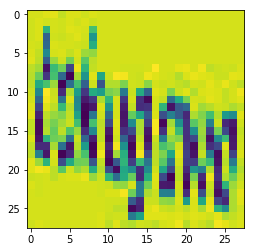

./mjsynth_dataset/train/174_PRACTICAL_59311.jpg
Image Shape Before Resize: (32, 188)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/174_PRACTICAL_59311.jpg
Label: PRACTICAL | Encoded Label: [15 17  0  2 19  8  2  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 0 2 19 8 2 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


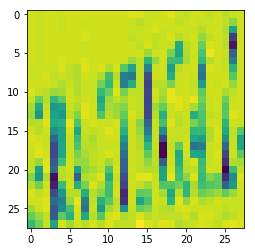

./mjsynth_dataset/train/175_supernal_76252.jpg
Image Shape Before Resize: (31, 51)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/175_supernal_76252.jpg
Label: supernal | Encoded Label: [44 46 41 30 43 39 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 46 41 30 43 39 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


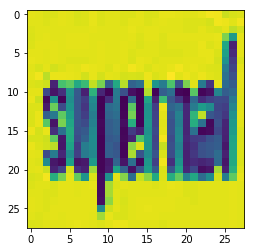

./mjsynth_dataset/train/176_BATHE_6226.jpg
Image Shape Before Resize: (31, 124)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/176_BATHE_6226.jpg
Label: BATHE | Encoded Label: [ 1  0 19  7  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 0 19 7 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


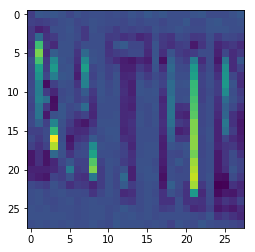

./mjsynth_dataset/train/177_proserpine_60734.jpg
Image Shape Before Resize: (31, 143)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/177_proserpine_60734.jpg
Label: proserpine | Encoded Label: [41 43 40 44 30 43 41 34 39 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 43 40 44 30 43 41 34 39 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


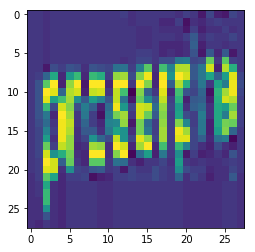

./mjsynth_dataset/train/178_HAWTHORNS_35261.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/178_HAWTHORNS_35261.jpg
Label: HAWTHORNS | Encoded Label: [ 7  0 22 19  7 14 17 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 0 22 19 7 14 17 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


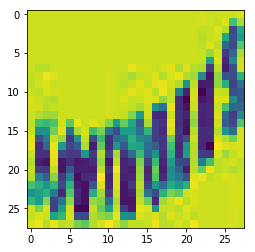

./mjsynth_dataset/train/179_flouncy_29710.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/179_flouncy_29710.jpg
Label: flouncy | Encoded Label: [31 37 40 46 39 28 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 37 40 46 39 28 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


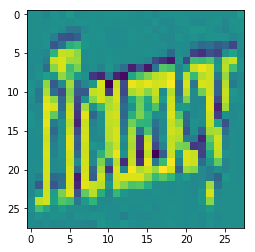

./mjsynth_dataset/train/17_activists_880.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/17_activists_880.jpg
Label: activists | Encoded Label: [26 28 45 34 47 34 44 45 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 26 28 45 34 47 34 44 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


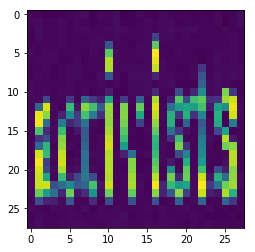

./mjsynth_dataset/train/180_PRATER_59372.jpg
Image Shape Before Resize: (31, 91)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/180_PRATER_59372.jpg
Label: PRATER | Encoded Label: [15 17  0 19  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 0 19 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


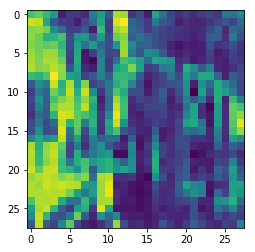

./mjsynth_dataset/train/181_DARNED_19263.jpg
Image Shape Before Resize: (31, 101)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/181_DARNED_19263.jpg
Label: DARNED | Encoded Label: [ 3  0 17 13  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 0 17 13 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


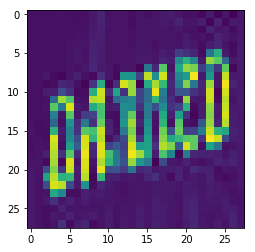

./mjsynth_dataset/train/182_TRIBECA_80590.jpg
Image Shape Before Resize: (31, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/182_TRIBECA_80590.jpg
Label: TRIBECA | Encoded Label: [19 17  8  1  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 17 8 1 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


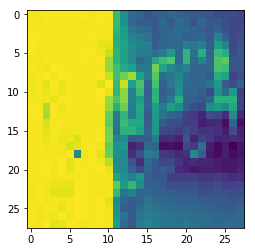

./mjsynth_dataset/train/183_Confines_15935.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/183_Confines_15935.jpg
Label: Confines | Encoded Label: [ 2 40 39 31 34 39 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 39 31 34 39 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


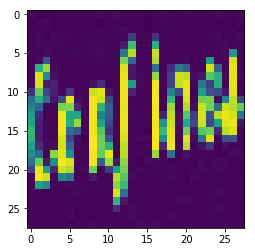

./mjsynth_dataset/train/184_Unexceptional_82414.jpg
Image Shape Before Resize: (31, 200)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/184_Unexceptional_82414.jpg
Label: Unexceptional | Encoded Label: [20 39 30 49 28 30 41 45 34 40 39 26 37  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 30 49 28 30 41 45 34 40 39 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


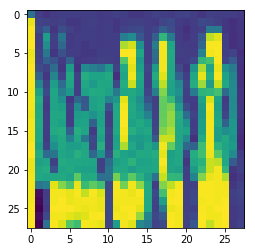

./mjsynth_dataset/train/185_counselings_17396.jpg
Image Shape Before Resize: (31, 236)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/185_counselings_17396.jpg
Label: counselings | Encoded Label: [28 40 46 39 44 30 37 34 39 32 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 46 39 44 30 37 34 39 32 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


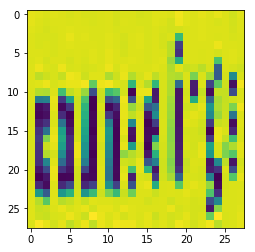

./mjsynth_dataset/train/186_marigold_46739.jpg
Image Shape Before Resize: (31, 125)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/186_marigold_46739.jpg
Label: marigold | Encoded Label: [38 26 43 34 32 40 37 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 26 43 34 32 40 37 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


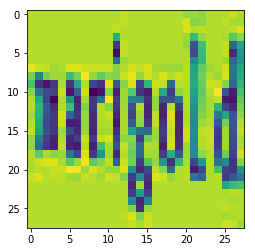

./mjsynth_dataset/train/187_SCRUNCH_68757.jpg
Image Shape Before Resize: (31, 127)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/187_SCRUNCH_68757.jpg
Label: SCRUNCH | Encoded Label: [18  2 17 20 13  2  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 2 17 20 13 2 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


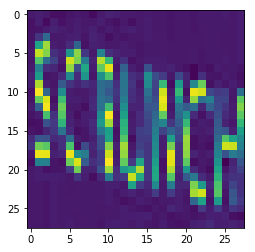

./mjsynth_dataset/train/188_Hairsbreadths_34562.jpg
Image Shape Before Resize: (31, 260)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/188_Hairsbreadths_34562.jpg
Label: Hairsbreadths | Encoded Label: [ 7 26 34 43 44 27 43 30 26 29 45 33 44  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 26 34 43 44 27 43 30 26 29 45 33 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


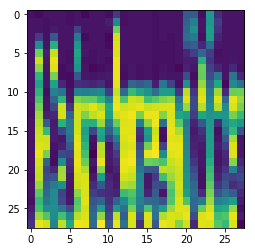

./mjsynth_dataset/train/189_Blaspheming_7918.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/189_Blaspheming_7918.jpg
Label: Blaspheming | Encoded Label: [ 1 37 26 44 41 33 30 38 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 37 26 44 41 33 30 38 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


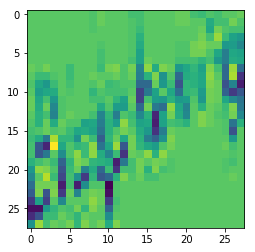

./mjsynth_dataset/train/18_AERATING_1335.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/18_AERATING_1335.jpg
Label: AERATING | Encoded Label: [ 0  4 17  0 19  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 4 17 0 19 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


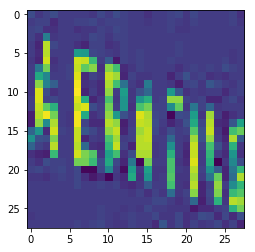

./mjsynth_dataset/train/190_Bougainvillea_8964.jpg
Image Shape Before Resize: (32, 160)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/190_Bougainvillea_8964.jpg
Label: Bougainvillea | Encoded Label: [ 1 40 46 32 26 34 39 47 34 37 37 30 26  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 40 46 32 26 34 39 47 34 37 37 30 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


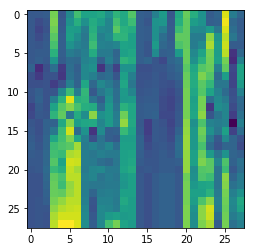

./mjsynth_dataset/train/191_Ergot_26382.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/191_Ergot_26382.jpg
Label: Ergot | Encoded Label: [ 4 43 32 40 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 43 32 40 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


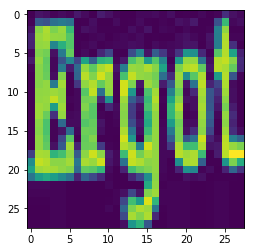

./mjsynth_dataset/train/192_Promulgates_60549.jpg
Image Shape Before Resize: (31, 148)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/192_Promulgates_60549.jpg
Label: Promulgates | Encoded Label: [15 43 40 38 46 37 32 26 45 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 43 40 38 46 37 32 26 45 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


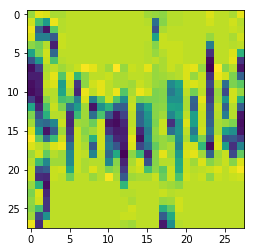

./mjsynth_dataset/train/193_VESTA_84436.jpg
Image Shape Before Resize: (31, 189)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/193_VESTA_84436.jpg
Label: VESTA | Encoded Label: [21  4 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 21 4 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


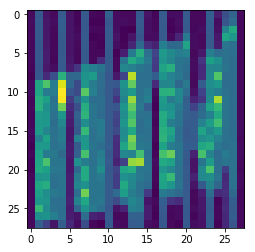

./mjsynth_dataset/train/194_DEPRIVATIONS_20814.jpg
Image Shape Before Resize: (31, 133)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/194_DEPRIVATIONS_20814.jpg
Label: DEPRIVATIONS | Encoded Label: [ 3  4 15 17  8 21  0 19  8 14 13 18  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 4 15 17 8 21 0 19 8 14 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


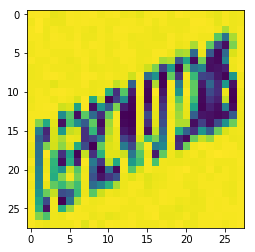

./mjsynth_dataset/train/195_Blackmailed_7815.jpg
Image Shape Before Resize: (32, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/195_Blackmailed_7815.jpg
Label: Blackmailed | Encoded Label: [ 1 37 26 28 36 38 26 34 37 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 37 26 28 36 38 26 34 37 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


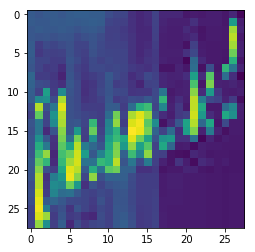

./mjsynth_dataset/train/196_ledges_43875.jpg
Image Shape Before Resize: (31, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/196_ledges_43875.jpg
Label: ledges | Encoded Label: [37 30 29 32 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 37 30 29 32 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


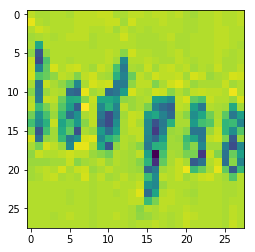

./mjsynth_dataset/train/197_decree_19867.jpg
Image Shape Before Resize: (31, 100)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/197_decree_19867.jpg
Label: decree | Encoded Label: [29 30 28 43 30 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 30 28 43 30 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


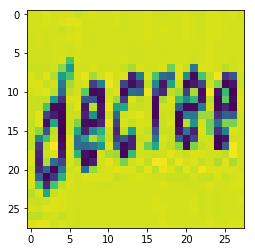

./mjsynth_dataset/train/198_PROCREATIVE_60288.jpg
Image Shape Before Resize: (31, 159)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/198_PROCREATIVE_60288.jpg
Label: PROCREATIVE | Encoded Label: [15 17 14  2 17  4  0 19  8 21  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 14 2 17 4 0 19 8 21 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


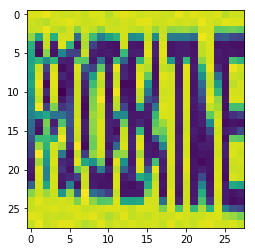

./mjsynth_dataset/train/199_CMR_14449.jpg
Image Shape Before Resize: (31, 97)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/199_CMR_14449.jpg
Label: CMR | Encoded Label: [ 2 12 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 12 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


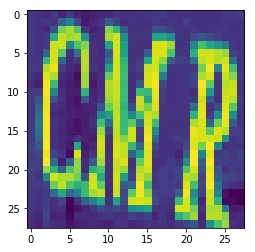

./mjsynth_dataset/train/19_killers_42470.jpg
Image Shape Before Resize: (31, 121)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/19_killers_42470.jpg
Label: killers | Encoded Label: [36 34 37 37 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 36 34 37 37 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


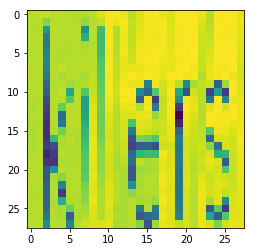

./mjsynth_dataset/train/1_FATEFULNESS_28238.jpg
Image Shape Before Resize: (31, 150)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/1_FATEFULNESS_28238.jpg
Label: FATEFULNESS | Encoded Label: [ 5  0 19  4  5 20 11 13  4 18 18  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 0 19 4 5 20 11 13 4 18 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


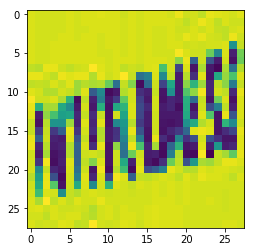

./mjsynth_dataset/train/200_grenada_33674.jpg
Image Shape Before Resize: (31, 70)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/200_grenada_33674.jpg
Label: grenada | Encoded Label: [32 43 30 39 26 29 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 32 43 30 39 26 29 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


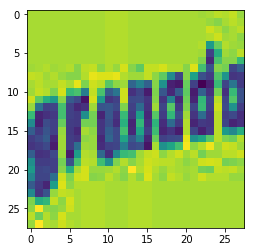

./mjsynth_dataset/train/201_hazes_35304.jpg
Image Shape Before Resize: (31, 75)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/201_hazes_35304.jpg
Label: hazes | Encoded Label: [33 26 51 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 33 26 51 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


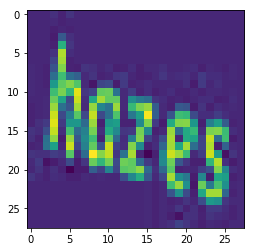

./mjsynth_dataset/train/202_HUNGARIAN_37366.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/202_HUNGARIAN_37366.jpg
Label: HUNGARIAN | Encoded Label: [ 7 20 13  6  0 17  8  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 20 13 6 0 17 8 0 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


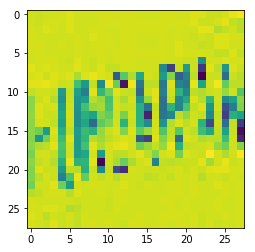

./mjsynth_dataset/train/203_PLUNKED_58376.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/203_PLUNKED_58376.jpg
Label: PLUNKED | Encoded Label: [15 11 20 13 10  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 11 20 13 10 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


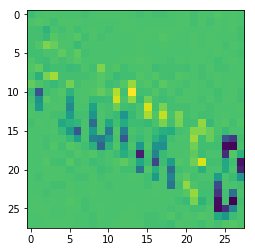

./mjsynth_dataset/train/204_Masque_46993.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/204_Masque_46993.jpg
Label: Masque | Encoded Label: [12 26 44 42 46 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 26 44 42 46 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


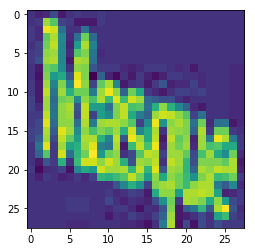

./mjsynth_dataset/train/205_Wicker_86480.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/205_Wicker_86480.jpg
Label: Wicker | Encoded Label: [22 34 28 36 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 34 28 36 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


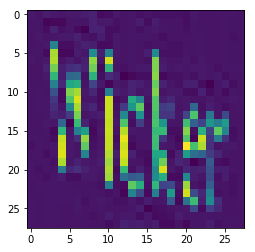

./mjsynth_dataset/train/206_SCORERS_68484.jpg
Image Shape Before Resize: (31, 173)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/206_SCORERS_68484.jpg
Label: SCORERS | Encoded Label: [18  2 14 17  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 2 14 17 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


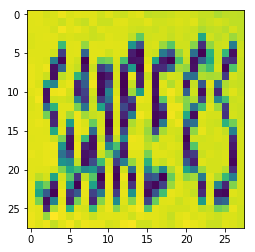

./mjsynth_dataset/train/207_HAWS_35256.jpg
Image Shape Before Resize: (31, 68)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/207_HAWS_35256.jpg
Label: HAWS | Encoded Label: [ 7  0 22 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 0 22 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


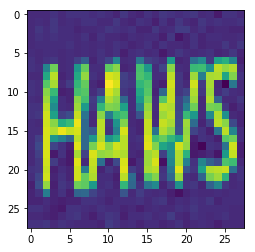

./mjsynth_dataset/train/208_CONJOINT_16106.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/208_CONJOINT_16106.jpg
Label: CONJOINT | Encoded Label: [ 2 14 13  9 14  8 13 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 13 9 14 8 13 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


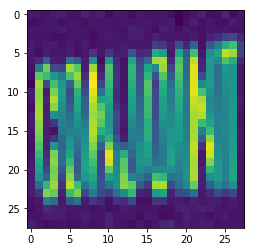

./mjsynth_dataset/train/209_Communicate_15298.jpg
Image Shape Before Resize: (31, 156)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/209_Communicate_15298.jpg
Label: Communicate | Encoded Label: [ 2 40 38 38 46 39 34 28 26 45 30  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 38 38 46 39 34 28 26 45 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


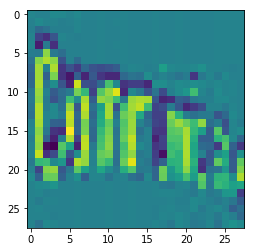

./mjsynth_dataset/train/20_Overstepping_54720.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/20_Overstepping_54720.jpg
Label: Overstepping | Encoded Label: [14 47 30 43 44 45 30 41 41 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 47 30 43 44 45 30 41 41 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


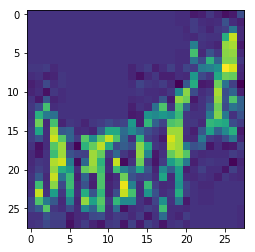

./mjsynth_dataset/train/210_Laos_43355.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/210_Laos_43355.jpg
Label: Laos | Encoded Label: [11 26 40 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 26 40 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


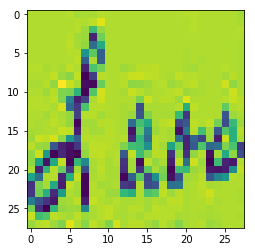

./mjsynth_dataset/train/211_KELLY_42255.jpg
Image Shape Before Resize: (31, 66)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/211_KELLY_42255.jpg
Label: KELLY | Encoded Label: [10  4 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 4 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


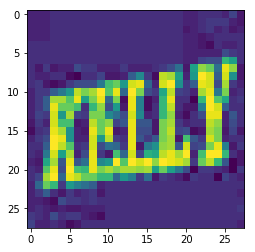

./mjsynth_dataset/train/212_Slobber_71755.jpg
Image Shape Before Resize: (31, 84)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/212_Slobber_71755.jpg
Label: Slobber | Encoded Label: [18 37 40 27 27 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 37 40 27 27 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


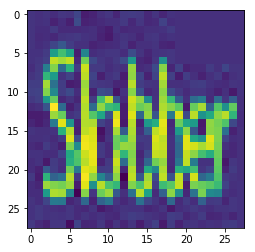

./mjsynth_dataset/train/213_rewritten_65872.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/213_rewritten_65872.jpg
Label: rewritten | Encoded Label: [43 30 48 43 34 45 45 30 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 30 48 43 34 45 45 30 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


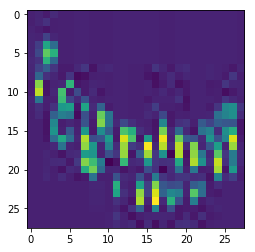

./mjsynth_dataset/train/214_firescreen_29093.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/214_firescreen_29093.jpg
Label: firescreen | Encoded Label: [31 34 43 30 44 28 43 30 30 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 34 43 30 44 28 43 30 30 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


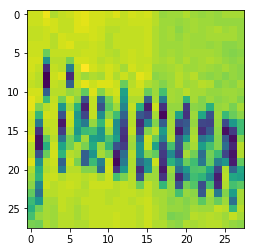

./mjsynth_dataset/train/215_Bestrewing_7191.jpg
Image Shape Before Resize: (31, 167)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/215_Bestrewing_7191.jpg
Label: Bestrewing | Encoded Label: [ 1 30 44 45 43 30 48 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 30 44 45 43 30 48 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


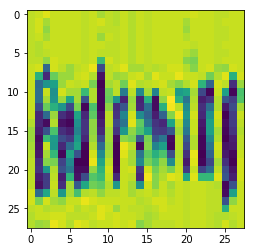

./mjsynth_dataset/train/216_CHEMONICS_13031.jpg
Image Shape Before Resize: (31, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/216_CHEMONICS_13031.jpg
Label: CHEMONICS | Encoded Label: [ 2  7  4 12 14 13  8  2 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 7 4 12 14 13 8 2 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


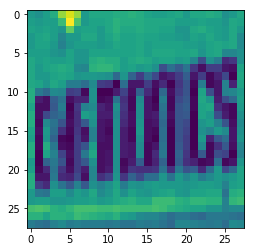

./mjsynth_dataset/train/217_PHRENOLOGY_57374.jpg
Image Shape Before Resize: (31, 150)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/217_PHRENOLOGY_57374.jpg
Label: PHRENOLOGY | Encoded Label: [15  7 17  4 13 14 11 14  6 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 7 17 4 13 14 11 14 6 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


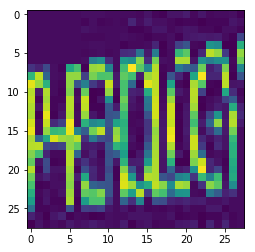

./mjsynth_dataset/train/218_Smollett_72044.jpg
Image Shape Before Resize: (31, 115)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/218_Smollett_72044.jpg
Label: Smollett | Encoded Label: [18 38 40 37 37 30 45 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 38 40 37 37 30 45 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


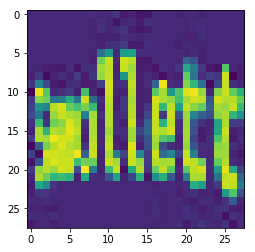

./mjsynth_dataset/train/219_ASTONISHES_4502.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/219_ASTONISHES_4502.jpg
Label: ASTONISHES | Encoded Label: [ 0 18 19 14 13  8 18  7  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 18 19 14 13 8 18 7 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


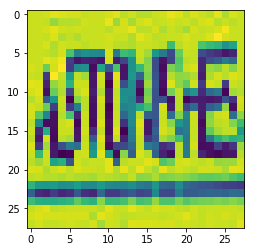

./mjsynth_dataset/train/21_Rubberized_66916.jpg
Image Shape Before Resize: (31, 143)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/21_Rubberized_66916.jpg
Label: Rubberized | Encoded Label: [17 46 27 27 30 43 34 51 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 46 27 27 30 43 34 51 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


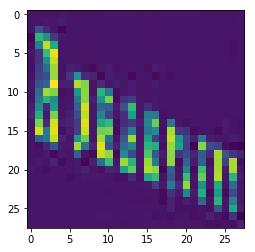

./mjsynth_dataset/train/220_cracker_17736.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/220_cracker_17736.jpg
Label: cracker | Encoded Label: [28 43 26 28 36 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 43 26 28 36 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


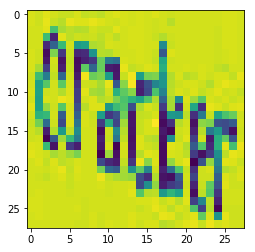

./mjsynth_dataset/train/221_minions_48635.jpg
Image Shape Before Resize: (31, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/221_minions_48635.jpg
Label: minions | Encoded Label: [38 34 39 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 34 39 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


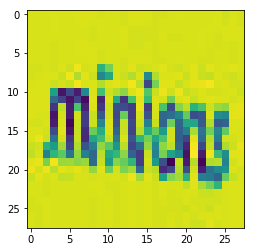

./mjsynth_dataset/train/222_kruger_42938.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/222_kruger_42938.jpg
Label: kruger | Encoded Label: [36 43 46 32 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 36 43 46 32 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


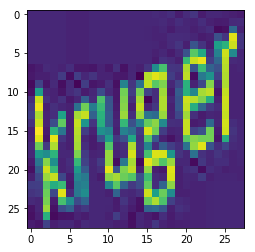

./mjsynth_dataset/train/223_Utterances_83793.jpg
Image Shape Before Resize: (31, 168)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/223_Utterances_83793.jpg
Label: Utterances | Encoded Label: [20 45 45 30 43 26 39 28 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 45 45 30 43 26 39 28 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


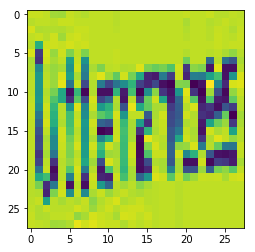

./mjsynth_dataset/train/224_JUGFUL_41891.jpg
Image Shape Before Resize: (31, 91)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/224_JUGFUL_41891.jpg
Label: JUGFUL | Encoded Label: [ 9 20  6  5 20 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 9 20 6 5 20 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


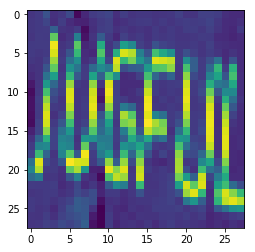

./mjsynth_dataset/train/225_Unbuckles_81829.jpg
Image Shape Before Resize: (31, 123)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/225_Unbuckles_81829.jpg
Label: Unbuckles | Encoded Label: [20 39 27 46 28 36 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 27 46 28 36 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


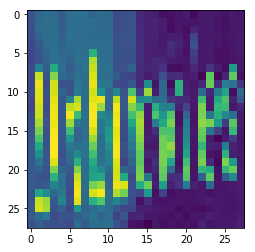

./mjsynth_dataset/train/226_MAGNETO_46024.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/226_MAGNETO_46024.jpg
Label: MAGNETO | Encoded Label: [12  0  6 13  4 19 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 0 6 13 4 19 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


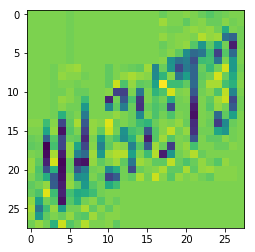

./mjsynth_dataset/train/227_GAINSAYS_31524.jpg
Image Shape Before Resize: (31, 140)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/227_GAINSAYS_31524.jpg
Label: GAINSAYS | Encoded Label: [ 6  0  8 13 18  0 24 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 0 8 13 18 0 24 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


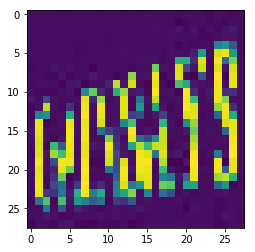

./mjsynth_dataset/train/228_BACKCOMBS_5325.jpg
Image Shape Before Resize: (31, 147)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/228_BACKCOMBS_5325.jpg
Label: BACKCOMBS | Encoded Label: [ 1  0  2 10  2 14 12  1 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 0 2 10 2 14 12 1 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


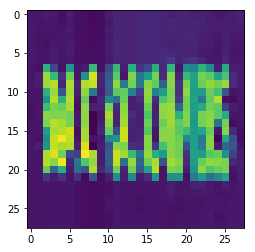

./mjsynth_dataset/train/229_Clunkier_14417.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/229_Clunkier_14417.jpg
Label: Clunkier | Encoded Label: [ 2 37 46 39 36 34 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 37 46 39 36 34 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


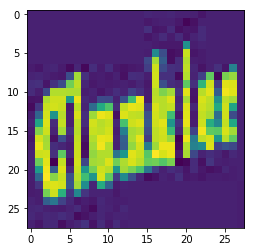

./mjsynth_dataset/train/22_Affidavit_1406.jpg
Image Shape Before Resize: (31, 99)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/22_Affidavit_1406.jpg
Label: Affidavit | Encoded Label: [ 0 31 31 34 29 26 47 34 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 31 31 34 29 26 47 34 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


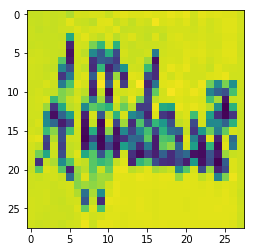

./mjsynth_dataset/train/230_MARCHED_46681.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/230_MARCHED_46681.jpg
Label: MARCHED | Encoded Label: [12  0 17  2  7  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 0 17 2 7 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


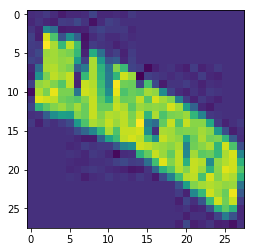

./mjsynth_dataset/train/231_Amaryllis_2346.jpg
Image Shape Before Resize: (31, 177)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/231_Amaryllis_2346.jpg
Label: Amaryllis | Encoded Label: [ 0 38 26 43 50 37 37 34 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 38 26 43 50 37 37 34 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


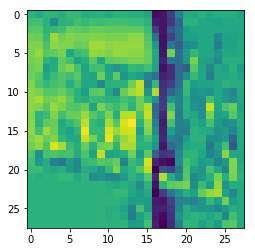

./mjsynth_dataset/train/232_successor_75815.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/232_successor_75815.jpg
Label: successor | Encoded Label: [44 46 28 28 30 44 44 40 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 46 28 28 30 44 44 40 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


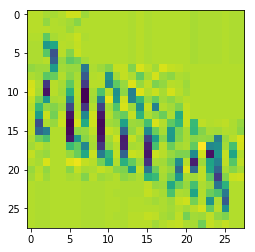

./mjsynth_dataset/train/233_skydiving_71410.jpg
Image Shape Before Resize: (31, 69)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/233_skydiving_71410.jpg
Label: skydiving | Encoded Label: [44 36 50 29 34 47 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 36 50 29 34 47 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


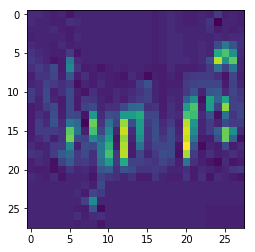

./mjsynth_dataset/train/234_Parched_55519.jpg
Image Shape Before Resize: (31, 79)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/234_Parched_55519.jpg
Label: Parched | Encoded Label: [15 26 43 28 33 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 26 43 28 33 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


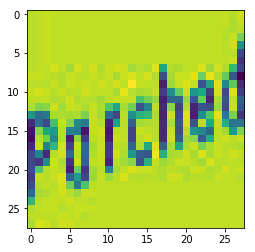

./mjsynth_dataset/train/235_Surrounds_76505.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/235_Surrounds_76505.jpg
Label: Surrounds | Encoded Label: [18 46 43 43 40 46 39 29 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 46 43 43 40 46 39 29 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


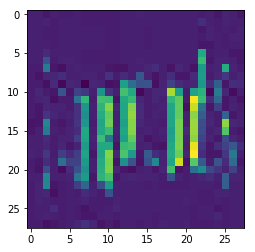

./mjsynth_dataset/train/236_SEGFAULT_69174.jpg
Image Shape Before Resize: (31, 168)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/236_SEGFAULT_69174.jpg
Label: SEGFAULT | Encoded Label: [18  4  6  5  0 20 11 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 4 6 5 0 20 11 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


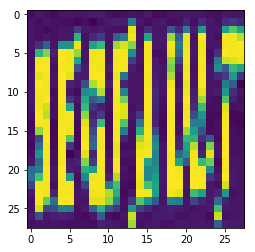

./mjsynth_dataset/train/237_churchgoers_13608.jpg
Image Shape Before Resize: (31, 91)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/237_churchgoers_13608.jpg
Label: churchgoers | Encoded Label: [28 33 46 43 28 33 32 40 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 33 46 43 28 33 32 40 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


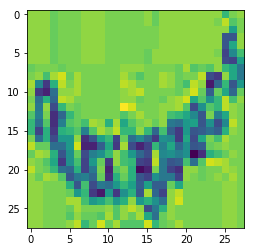

./mjsynth_dataset/train/238_discus_22193.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/238_discus_22193.jpg
Label: discus | Encoded Label: [29 34 44 28 46 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 34 44 28 46 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


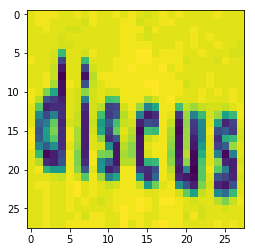

./mjsynth_dataset/train/239_outfitters_54033.jpg
Image Shape Before Resize: (31, 138)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/239_outfitters_54033.jpg
Label: outfitters | Encoded Label: [40 46 45 31 34 45 45 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 40 46 45 31 34 45 45 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


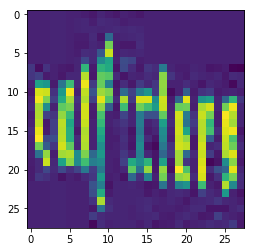

./mjsynth_dataset/train/23_DRAB_23594.jpg
Image Shape Before Resize: (31, 70)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/23_DRAB_23594.jpg
Label: DRAB | Encoded Label: [ 3 17  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 17 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


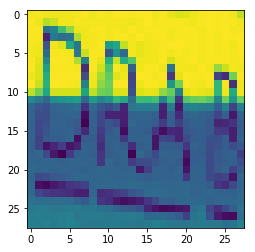

./mjsynth_dataset/train/240_chats_12871.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/240_chats_12871.jpg
Label: chats | Encoded Label: [28 33 26 45 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 33 26 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


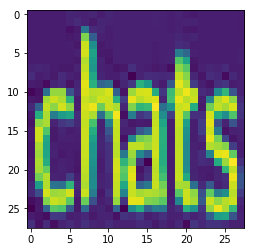

./mjsynth_dataset/train/241_tawdrily_77724.jpg
Image Shape Before Resize: (31, 92)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/241_tawdrily_77724.jpg
Label: tawdrily | Encoded Label: [45 26 48 29 43 34 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 26 48 29 43 34 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


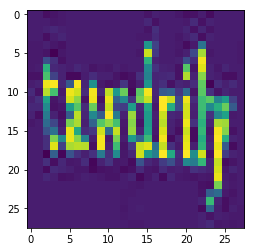

./mjsynth_dataset/train/242_NEGATION_51202.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/242_NEGATION_51202.jpg
Label: NEGATION | Encoded Label: [13  4  6  0 19  8 14 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 4 6 0 19 8 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


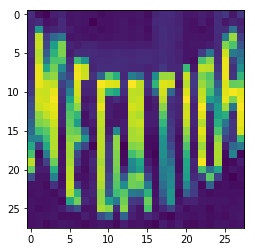

./mjsynth_dataset/train/243_Insertions_39795.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/243_Insertions_39795.jpg
Label: Insertions | Encoded Label: [ 8 39 44 30 43 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 39 44 30 43 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


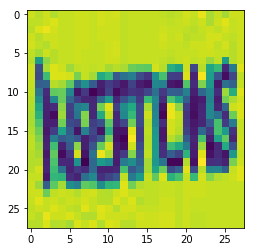

./mjsynth_dataset/train/244_MALTA_46323.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/244_MALTA_46323.jpg
Label: MALTA | Encoded Label: [12  0 11 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 0 11 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


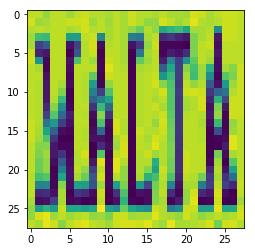

./mjsynth_dataset/train/245_Feting_28656.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/245_Feting_28656.jpg
Label: Feting | Encoded Label: [ 5 30 45 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 30 45 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


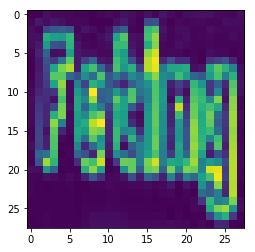

./mjsynth_dataset/train/246_PREWAR_60012.jpg
Image Shape Before Resize: (31, 103)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/246_PREWAR_60012.jpg
Label: PREWAR | Encoded Label: [15 17  4 22  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 4 22 0 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


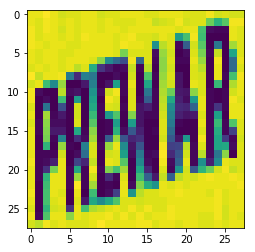

./mjsynth_dataset/train/247_OCTOPUS_53043.jpg
Image Shape Before Resize: (31, 109)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/247_OCTOPUS_53043.jpg
Label: OCTOPUS | Encoded Label: [14  2 19 14 15 20 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 2 19 14 15 20 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


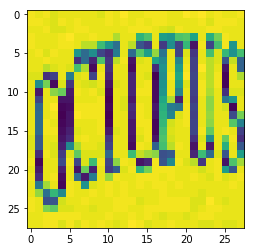

./mjsynth_dataset/train/248_REHEARSING_64130.jpg
Image Shape Before Resize: (31, 140)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/248_REHEARSING_64130.jpg
Label: REHEARSING | Encoded Label: [17  4  7  4  0 17 18  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 7 4 0 17 18 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


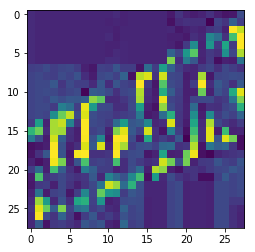

./mjsynth_dataset/train/249_sap_67750.jpg
Image Shape Before Resize: (31, 65)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/249_sap_67750.jpg
Label: sap | Encoded Label: [44 26 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 26 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


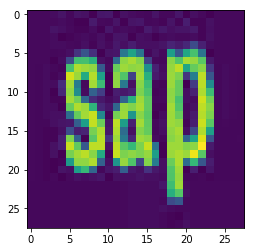

./mjsynth_dataset/train/24_goofing_33139.jpg
Image Shape Before Resize: (31, 51)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/24_goofing_33139.jpg
Label: goofing | Encoded Label: [32 40 40 31 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 32 40 40 31 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


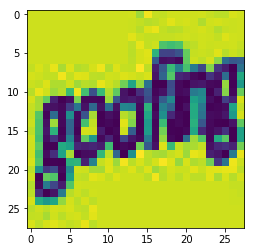

./mjsynth_dataset/train/250_Reapers_62836.jpg
Image Shape Before Resize: (31, 78)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/250_Reapers_62836.jpg
Label: Reapers | Encoded Label: [17 30 26 41 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 26 41 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


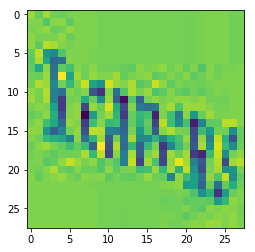

./mjsynth_dataset/train/251_Moiseyev_49358.jpg
Image Shape Before Resize: (31, 77)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/251_Moiseyev_49358.jpg
Label: Moiseyev | Encoded Label: [12 40 34 44 30 50 30 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 40 34 44 30 50 30 47 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


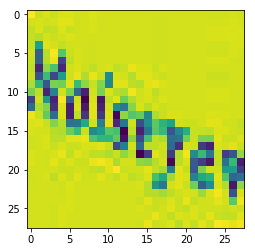

./mjsynth_dataset/train/252_interrelationships_40346.jpg
Image Shape Before Resize: (31, 162)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/252_interrelationships_40346.jpg
Label: interrelationships | Encoded Label: [34 39 45 30 43 43 30 37 26 45 34 40 39 44 33 34 41 44  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 34 39 45 30 43 43 30 37 26 45 34 40 39 44 33 34 41 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0


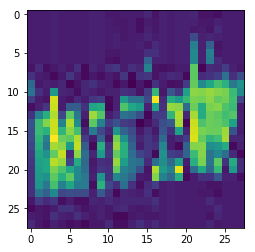

./mjsynth_dataset/train/253_Trojans_80798.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/253_Trojans_80798.jpg
Label: Trojans | Encoded Label: [19 43 40 35 26 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 43 40 35 26 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


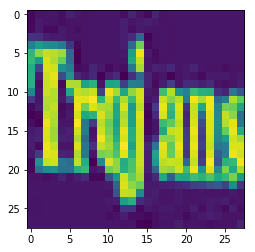

./mjsynth_dataset/train/254_ATTACK_4670.jpg
Image Shape Before Resize: (31, 182)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/254_ATTACK_4670.jpg
Label: ATTACK | Encoded Label: [ 0 19 19  0  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 19 19 0 2 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


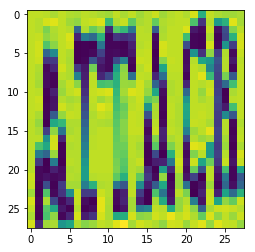

./mjsynth_dataset/train/255_Heatstroke_35516.jpg
Image Shape Before Resize: (31, 130)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/255_Heatstroke_35516.jpg
Label: Heatstroke | Encoded Label: [ 7 30 26 45 44 45 43 40 36 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 30 26 45 44 45 43 40 36 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


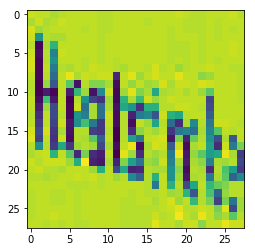

./mjsynth_dataset/train/256_Nitrocellulose_51764.jpg
Image Shape Before Resize: (31, 102)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/256_Nitrocellulose_51764.jpg
Label: Nitrocellulose | Encoded Label: [13 34 45 43 40 28 30 37 37 46 37 40 44 30  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 34 45 43 40 28 30 37 37 46 37 40 44 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


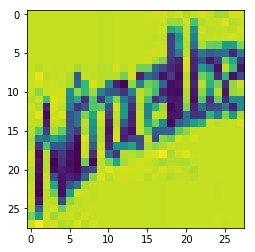

./mjsynth_dataset/train/257_Israelis_40979.jpg
Image Shape Before Resize: (31, 94)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/257_Israelis_40979.jpg
Label: Israelis | Encoded Label: [ 8 44 43 26 30 37 34 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 44 43 26 30 37 34 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


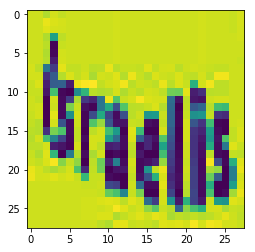

./mjsynth_dataset/train/258_mountain_50055.jpg
Image Shape Before Resize: (31, 91)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/258_mountain_50055.jpg
Label: mountain | Encoded Label: [38 40 46 39 45 26 34 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 40 46 39 45 26 34 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


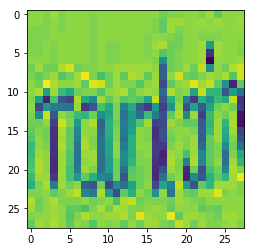

./mjsynth_dataset/train/259_PREEXISTED_59597.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/259_PREEXISTED_59597.jpg
Label: PREEXISTED | Encoded Label: [15 17  4  4 23  8 18 19  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 4 4 23 8 18 19 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


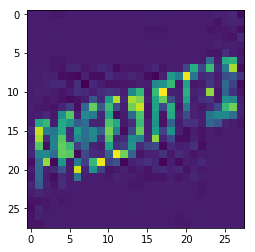

./mjsynth_dataset/train/25_Coley_14845.jpg
Image Shape Before Resize: (31, 85)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/25_Coley_14845.jpg
Label: Coley | Encoded Label: [ 2 40 37 30 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 37 30 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


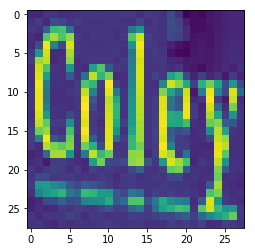

./mjsynth_dataset/train/260_Disinflation_22363.jpg
Image Shape Before Resize: (31, 135)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/260_Disinflation_22363.jpg
Label: Disinflation | Encoded Label: [ 3 34 44 34 39 31 37 26 45 34 40 39  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 44 34 39 31 37 26 45 34 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


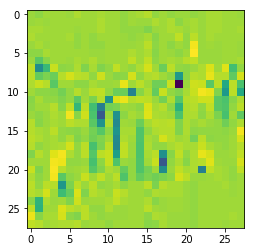

./mjsynth_dataset/train/261_Adjoining_1043.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/261_Adjoining_1043.jpg
Label: Adjoining | Encoded Label: [ 0 29 35 40 34 39 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 29 35 40 34 39 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


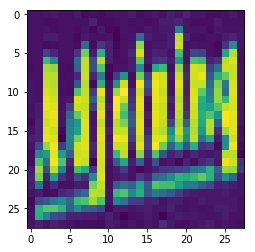

./mjsynth_dataset/train/262_SYNONYMS_77036.jpg
Image Shape Before Resize: (31, 132)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/262_SYNONYMS_77036.jpg
Label: SYNONYMS | Encoded Label: [18 24 13 14 13 24 12 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 24 13 14 13 24 12 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


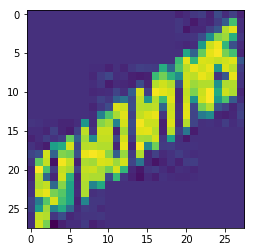

./mjsynth_dataset/train/263_ELECTRIFIER_24963.jpg
Image Shape Before Resize: (31, 168)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/263_ELECTRIFIER_24963.jpg
Label: ELECTRIFIER | Encoded Label: [ 4 11  4  2 19 17  8  5  8  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 11 4 2 19 17 8 5 8 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


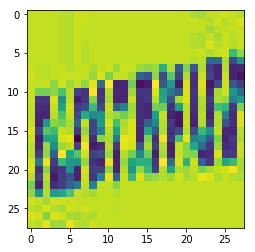

./mjsynth_dataset/train/264_symbolical_76955.jpg
Image Shape Before Resize: (31, 119)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/264_symbolical_76955.jpg
Label: symbolical | Encoded Label: [44 50 38 27 40 37 34 28 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 50 38 27 40 37 34 28 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


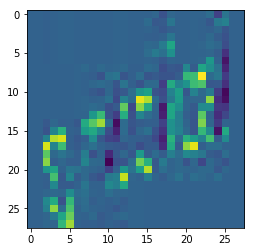

./mjsynth_dataset/train/265_smeary_71964.jpg
Image Shape Before Resize: (32, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/265_smeary_71964.jpg
Label: smeary | Encoded Label: [44 38 30 26 43 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 38 30 26 43 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


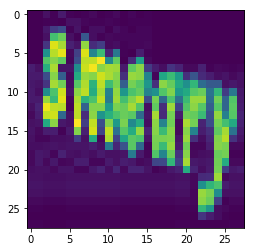

./mjsynth_dataset/train/266_remarking_64465.jpg
Image Shape Before Resize: (31, 101)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/266_remarking_64465.jpg
Label: remarking | Encoded Label: [43 30 38 26 43 36 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 30 38 26 43 36 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


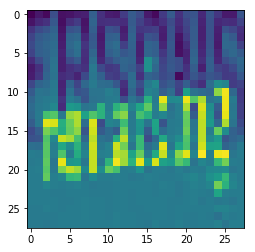

./mjsynth_dataset/train/267_ACOUSTICALLY_793.jpg
Image Shape Before Resize: (31, 453)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/267_ACOUSTICALLY_793.jpg
Label: ACOUSTICALLY | Encoded Label: [ 0  2 14 20 18 19  8  2  0 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 2 14 20 18 19 8 2 0 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


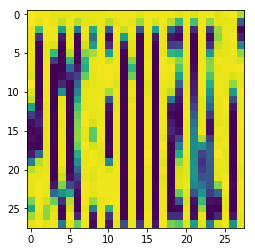

./mjsynth_dataset/train/268_Trapdoor_80364.jpg
Image Shape Before Resize: (31, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/268_Trapdoor_80364.jpg
Label: Trapdoor | Encoded Label: [19 43 26 41 29 40 40 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 43 26 41 29 40 40 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


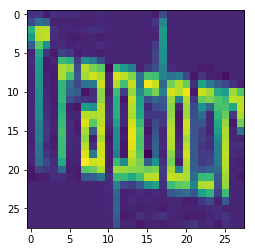

./mjsynth_dataset/train/269_AMADEUS_2326.jpg
Image Shape Before Resize: (31, 139)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/269_AMADEUS_2326.jpg
Label: AMADEUS | Encoded Label: [ 0 12  0  3  4 20 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 12 0 3 4 20 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


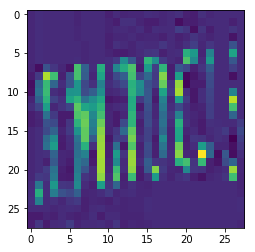

./mjsynth_dataset/train/26_INANITY_38607.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/26_INANITY_38607.jpg
Label: INANITY | Encoded Label: [ 8 13  0 13  8 19 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 13 0 13 8 19 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


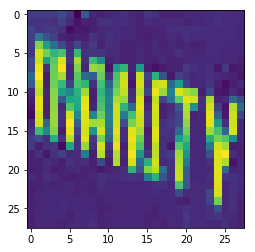

./mjsynth_dataset/train/270_CLASSICISM_13969.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/270_CLASSICISM_13969.jpg
Label: CLASSICISM | Encoded Label: [ 2 11  0 18 18  8  2  8 18 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 11 0 18 18 8 2 8 18 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


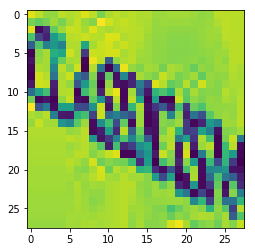

./mjsynth_dataset/train/271_HAUBERKS_35197.jpg
Image Shape Before Resize: (31, 125)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/271_HAUBERKS_35197.jpg
Label: HAUBERKS | Encoded Label: [ 7  0 20  1  4 17 10 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 0 20 1 4 17 10 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


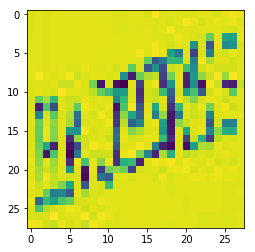

./mjsynth_dataset/train/272_LEARNER_43801.jpg
Image Shape Before Resize: (32, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/272_LEARNER_43801.jpg
Label: LEARNER | Encoded Label: [11  4  0 17 13  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 4 0 17 13 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


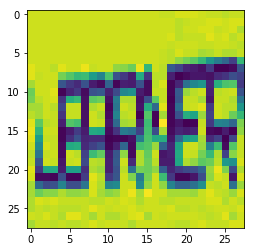

./mjsynth_dataset/train/273_TYPESETTER_81497.jpg
Image Shape Before Resize: (31, 152)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/273_TYPESETTER_81497.jpg
Label: TYPESETTER | Encoded Label: [19 24 15  4 18  4 19 19  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 24 15 4 18 4 19 19 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


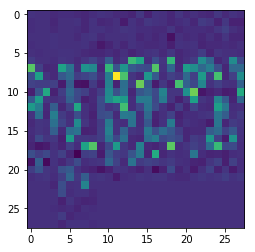

./mjsynth_dataset/train/274_REPORTERS_64860.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/274_REPORTERS_64860.jpg
Label: REPORTERS | Encoded Label: [17  4 15 14 17 19  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 15 14 17 19 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


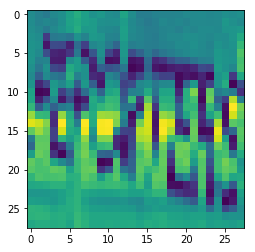

./mjsynth_dataset/train/275_Gelbvieh_32036.jpg
Image Shape Before Resize: (32, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/275_Gelbvieh_32036.jpg
Label: Gelbvieh | Encoded Label: [ 6 30 37 27 47 34 30 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 30 37 27 47 34 30 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


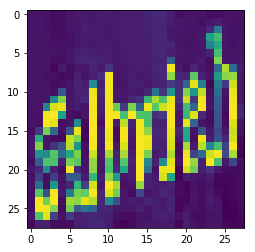

./mjsynth_dataset/train/276_MENINGEAL_47762.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/276_MENINGEAL_47762.jpg
Label: MENINGEAL | Encoded Label: [12  4 13  8 13  6  4  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 4 13 8 13 6 4 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


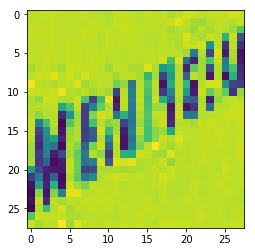

./mjsynth_dataset/train/277_roadsides_66337.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/277_roadsides_66337.jpg
Label: roadsides | Encoded Label: [43 40 26 29 44 34 29 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 40 26 29 44 34 29 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


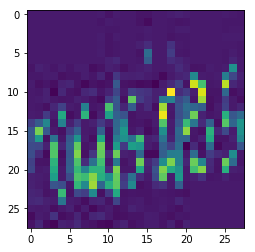

./mjsynth_dataset/train/278_NONDEMOCRATIC_51968.jpg
Image Shape Before Resize: (31, 216)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/278_NONDEMOCRATIC_51968.jpg
Label: NONDEMOCRATIC | Encoded Label: [13 14 13  3  4 12 14  2 17  0 19  8  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 14 13 3 4 12 14 2 17 0 19 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


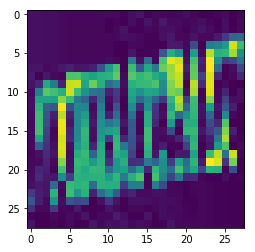

./mjsynth_dataset/train/279_centrifugally_12407.jpg
Image Shape Before Resize: (31, 126)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/279_centrifugally_12407.jpg
Label: centrifugally | Encoded Label: [28 30 39 45 43 34 31 46 32 26 37 37 50  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 30 39 45 43 34 31 46 32 26 37 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


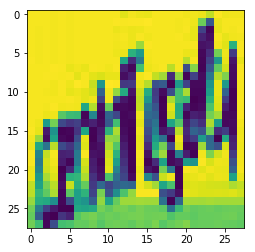

./mjsynth_dataset/train/27_Slaughtering_71537.jpg
Image Shape Before Resize: (31, 161)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/27_Slaughtering_71537.jpg
Label: Slaughtering | Encoded Label: [18 37 26 46 32 33 45 30 43 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 37 26 46 32 33 45 30 43 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


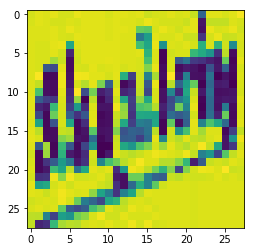

./mjsynth_dataset/train/280_kishinev_42606.jpg
Image Shape Before Resize: (31, 83)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/280_kishinev_42606.jpg
Label: kishinev | Encoded Label: [36 34 44 33 34 39 30 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 36 34 44 33 34 39 30 47 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


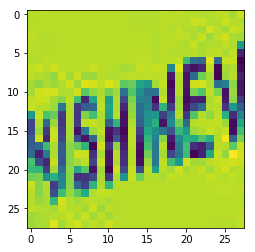

./mjsynth_dataset/train/281_Yeps_87762.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/281_Yeps_87762.jpg
Label: Yeps | Encoded Label: [24 30 41 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 24 30 41 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


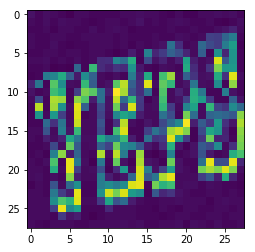

./mjsynth_dataset/train/282_Chaplain_12712.jpg
Image Shape Before Resize: (31, 109)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/282_Chaplain_12712.jpg
Label: Chaplain | Encoded Label: [ 2 33 26 41 37 26 34 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 33 26 41 37 26 34 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


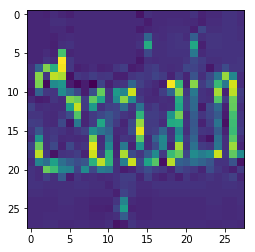

./mjsynth_dataset/train/283_COLT_15046.jpg
Image Shape Before Resize: (31, 81)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/283_COLT_15046.jpg
Label: COLT | Encoded Label: [ 2 14 11 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 11 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


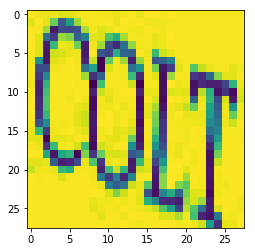

./mjsynth_dataset/train/284_Deathblows_19508.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/284_Deathblows_19508.jpg
Label: Deathblows | Encoded Label: [ 3 30 26 45 33 27 37 40 48 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 30 26 45 33 27 37 40 48 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


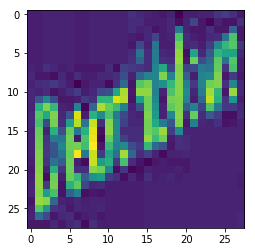

./mjsynth_dataset/train/285_FRIGGED_30916.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/285_FRIGGED_30916.jpg
Label: FRIGGED | Encoded Label: [ 5 17  8  6  6  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 17 8 6 6 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


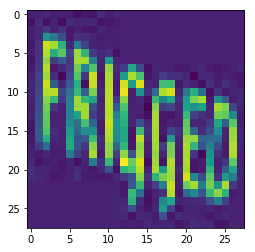

./mjsynth_dataset/train/286_Ludicrousness_45549.jpg
Image Shape Before Resize: (31, 135)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/286_Ludicrousness_45549.jpg
Label: Ludicrousness | Encoded Label: [11 46 29 34 28 43 40 46 44 39 30 44 44  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 46 29 34 28 43 40 46 44 39 30 44 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


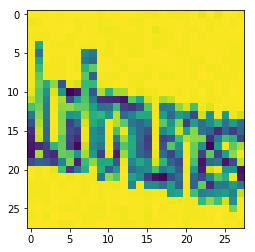

./mjsynth_dataset/train/287_thalia_78447.jpg
Image Shape Before Resize: (31, 53)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/287_thalia_78447.jpg
Label: thalia | Encoded Label: [45 33 26 37 34 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 33 26 37 34 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


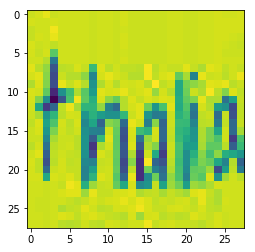

./mjsynth_dataset/train/288_SHOUTING_70482.jpg
Image Shape Before Resize: (31, 95)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/288_SHOUTING_70482.jpg
Label: SHOUTING | Encoded Label: [18  7 14 20 19  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 7 14 20 19 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


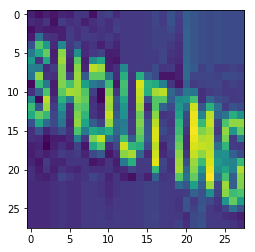

./mjsynth_dataset/train/289_KESTREL_42318.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/289_KESTREL_42318.jpg
Label: KESTREL | Encoded Label: [10  4 18 19 17  4 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 4 18 19 17 4 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


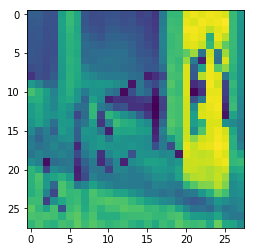

./mjsynth_dataset/train/28_SULFUR_75980.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/28_SULFUR_75980.jpg
Label: SULFUR | Encoded Label: [18 20 11  5 20 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 20 11 5 20 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


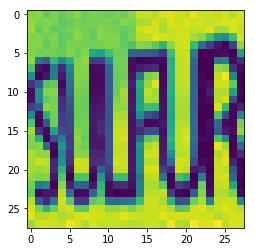

./mjsynth_dataset/train/290_REGROUND_64066.jpg
Image Shape Before Resize: (31, 169)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/290_REGROUND_64066.jpg
Label: REGROUND | Encoded Label: [17  4  6 17 14 20 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 6 17 14 20 13 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


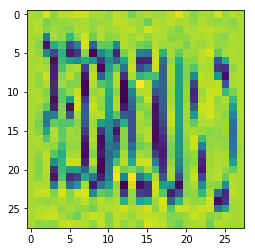

./mjsynth_dataset/train/291_Universals_82755.jpg
Image Shape Before Resize: (32, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/291_Universals_82755.jpg
Label: Universals | Encoded Label: [20 39 34 47 30 43 44 26 37 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 34 47 30 43 44 26 37 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


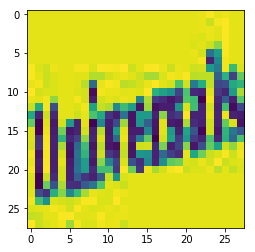

./mjsynth_dataset/train/292_GULAG_34186.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/292_GULAG_34186.jpg
Label: GULAG | Encoded Label: [ 6 20 11  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 20 11 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


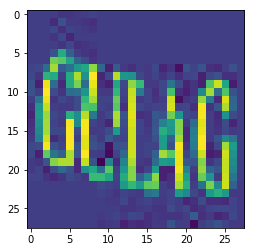

./mjsynth_dataset/train/293_mergansers_47869.jpg
Image Shape Before Resize: (31, 156)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/293_mergansers_47869.jpg
Label: mergansers | Encoded Label: [38 30 43 32 26 39 44 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 30 43 32 26 39 44 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


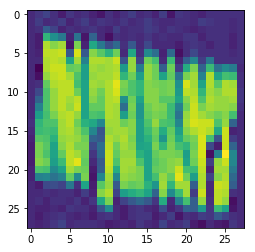

./mjsynth_dataset/train/294_Tuscan_81276.jpg
Image Shape Before Resize: (31, 122)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/294_Tuscan_81276.jpg
Label: Tuscan | Encoded Label: [19 46 44 28 26 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 46 44 28 26 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


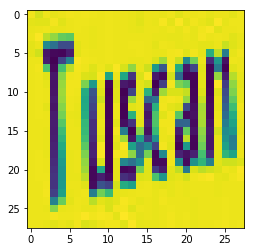

./mjsynth_dataset/train/295_Distanced_22726.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/295_Distanced_22726.jpg
Label: Distanced | Encoded Label: [ 3 34 44 45 26 39 28 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 44 45 26 39 28 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


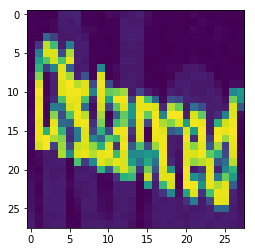

./mjsynth_dataset/train/296_COFFINS_14722.jpg
Image Shape Before Resize: (31, 115)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/296_COFFINS_14722.jpg
Label: COFFINS | Encoded Label: [ 2 14  5  5  8 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 5 5 8 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


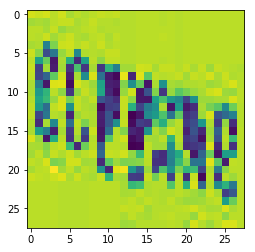

./mjsynth_dataset/train/297_seasonality_68956.jpg
Image Shape Before Resize: (31, 83)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/297_seasonality_68956.jpg
Label: seasonality | Encoded Label: [44 30 26 44 40 39 26 37 34 45 50  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 30 26 44 40 39 26 37 34 45 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


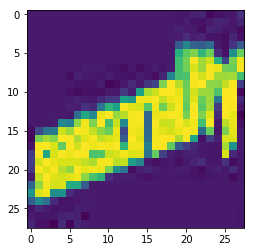

./mjsynth_dataset/train/298_RELIEVED_64388.jpg
Image Shape Before Resize: (31, 120)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/298_RELIEVED_64388.jpg
Label: RELIEVED | Encoded Label: [17  4 11  8  4 21  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 11 8 4 21 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


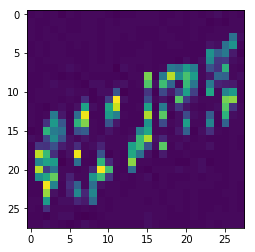

./mjsynth_dataset/train/299_TITHES_79328.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/299_TITHES_79328.jpg
Label: TITHES | Encoded Label: [19  8 19  7  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 8 19 7 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


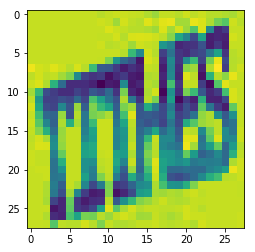

./mjsynth_dataset/train/29_stiffeners_74683.jpg
Image Shape Before Resize: (31, 157)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/29_stiffeners_74683.jpg
Label: stiffeners | Encoded Label: [44 45 34 31 31 30 39 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 45 34 31 31 30 39 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


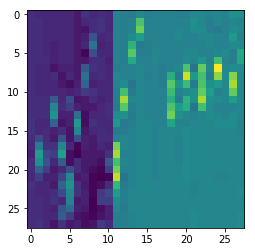

./mjsynth_dataset/train/2_usability_83710.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/2_usability_83710.jpg
Label: usability | Encoded Label: [46 44 26 27 34 37 34 45 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 46 44 26 27 34 37 34 45 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


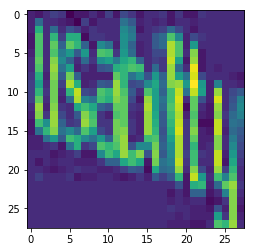

./mjsynth_dataset/train/300_commandeer_15158.jpg
Image Shape Before Resize: (31, 236)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/300_commandeer_15158.jpg
Label: commandeer | Encoded Label: [28 40 38 38 26 39 29 30 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 38 38 26 39 29 30 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


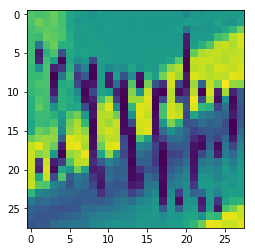

./mjsynth_dataset/train/301_Unison_82723.jpg
Image Shape Before Resize: (31, 98)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/301_Unison_82723.jpg
Label: Unison | Encoded Label: [20 39 34 44 40 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 34 44 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


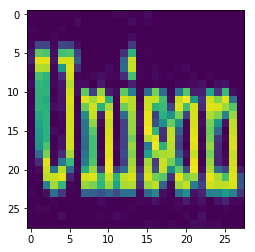

./mjsynth_dataset/train/302_Pharmacopoeia_57137.jpg
Image Shape Before Resize: (31, 115)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/302_Pharmacopoeia_57137.jpg
Label: Pharmacopoeia | Encoded Label: [15 33 26 43 38 26 28 40 41 40 30 34 26  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 33 26 43 38 26 28 40 41 40 30 34 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


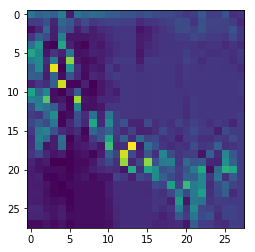

./mjsynth_dataset/train/303_ABSTRACTNESSES_474.jpg
Image Shape Before Resize: (32, 272)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/303_ABSTRACTNESSES_474.jpg
Label: ABSTRACTNESSES | Encoded Label: [ 0  1 18 19 17  0  2 19 13  4 18 18  4 18  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 1 18 19 17 0 2 19 13 4 18 18 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


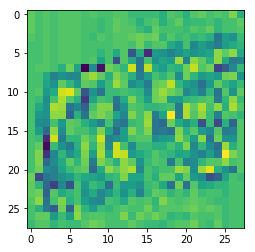

./mjsynth_dataset/train/304_maxes_47246.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/304_maxes_47246.jpg
Label: maxes | Encoded Label: [38 26 49 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 26 49 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


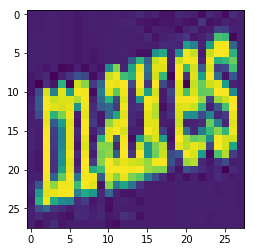

./mjsynth_dataset/train/305_kip_42580.jpg
Image Shape Before Resize: (31, 53)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/305_kip_42580.jpg
Label: kip | Encoded Label: [36 34 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 36 34 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


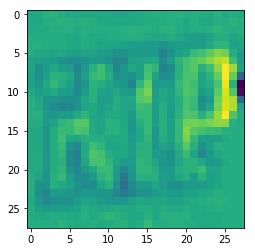

./mjsynth_dataset/train/306_Syringing_77067.jpg
Image Shape Before Resize: (31, 102)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/306_Syringing_77067.jpg
Label: Syringing | Encoded Label: [18 50 43 34 39 32 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 50 43 34 39 32 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


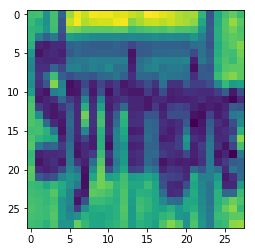

./mjsynth_dataset/train/307_Polio_58586.jpg
Image Shape Before Resize: (31, 73)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/307_Polio_58586.jpg
Label: Polio | Encoded Label: [15 40 37 34 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 40 37 34 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


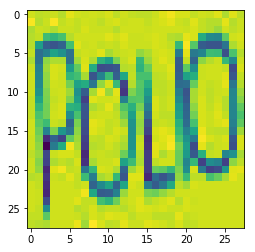

./mjsynth_dataset/train/308_POETS_58480.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/308_POETS_58480.jpg
Label: POETS | Encoded Label: [15 14  4 19 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 14 4 19 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


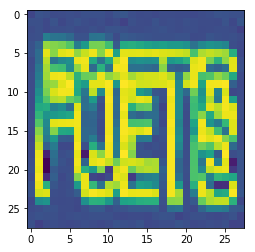

./mjsynth_dataset/train/309_Winnebago_86796.jpg
Image Shape Before Resize: (31, 140)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/309_Winnebago_86796.jpg
Label: Winnebago | Encoded Label: [22 34 39 39 30 27 26 32 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 34 39 39 30 27 26 32 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


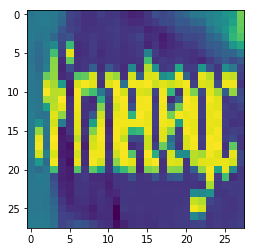

./mjsynth_dataset/train/30_CONSPECTUS_16323.jpg
Image Shape Before Resize: (31, 262)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/30_CONSPECTUS_16323.jpg
Label: CONSPECTUS | Encoded Label: [ 2 14 13 18 15  4  2 19 20 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 13 18 15 4 2 19 20 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


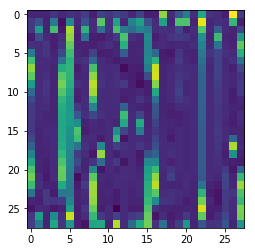

./mjsynth_dataset/train/310_bombardier_8603.jpg
Image Shape Before Resize: (31, 174)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/310_bombardier_8603.jpg
Label: bombardier | Encoded Label: [27 40 38 27 26 43 29 34 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 40 38 27 26 43 29 34 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


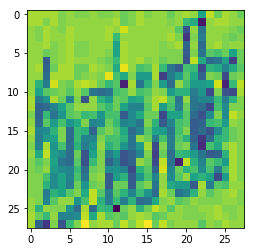

./mjsynth_dataset/train/311_rudy_66988.jpg
Image Shape Before Resize: (32, 64)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/311_rudy_66988.jpg
Label: rudy | Encoded Label: [43 46 29 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 46 29 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


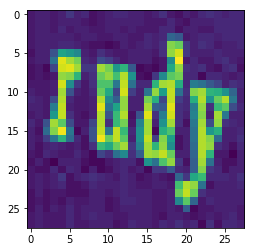

./mjsynth_dataset/train/312_SOMOZA_72717.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/312_SOMOZA_72717.jpg
Label: SOMOZA | Encoded Label: [18 14 12 14 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 14 12 14 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


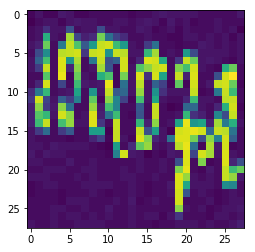

./mjsynth_dataset/train/313_parky_55591.jpg
Image Shape Before Resize: (31, 57)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/313_parky_55591.jpg
Label: parky | Encoded Label: [41 26 43 36 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 26 43 36 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


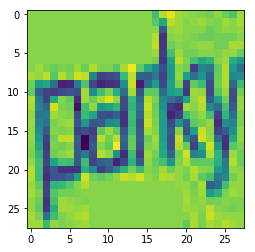

./mjsynth_dataset/train/314_jaggeder_41148.jpg
Image Shape Before Resize: (31, 97)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/314_jaggeder_41148.jpg
Label: jaggeder | Encoded Label: [35 26 32 32 30 29 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 35 26 32 32 30 29 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


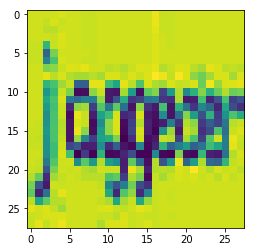

./mjsynth_dataset/train/315_bashfulness_6144.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/315_bashfulness_6144.jpg
Label: bashfulness | Encoded Label: [27 26 44 33 31 46 37 39 30 44 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 26 44 33 31 46 37 39 30 44 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


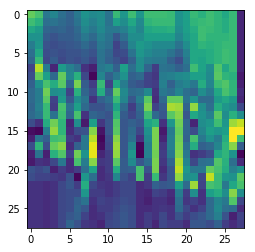

./mjsynth_dataset/train/316_Haiti_34575.jpg
Image Shape Before Resize: (31, 49)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/316_Haiti_34575.jpg
Label: Haiti | Encoded Label: [ 7 26 34 45 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 26 34 45 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


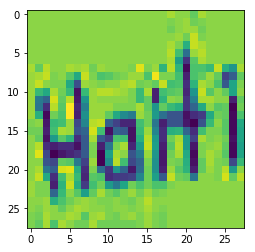

./mjsynth_dataset/train/317_precautions_59437.jpg
Image Shape Before Resize: (31, 122)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/317_precautions_59437.jpg
Label: precautions | Encoded Label: [41 43 30 28 26 46 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 43 30 28 26 46 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


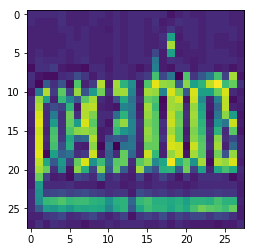

./mjsynth_dataset/train/318_tenochtitlan_78172.jpg
Image Shape Before Resize: (31, 200)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/318_tenochtitlan_78172.jpg
Label: tenochtitlan | Encoded Label: [45 30 39 40 28 33 45 34 45 37 26 39  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 30 39 40 28 33 45 34 45 37 26 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


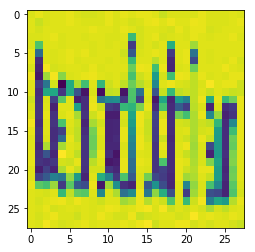

./mjsynth_dataset/train/319_Correggio_17156.jpg
Image Shape Before Resize: (31, 126)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/319_Correggio_17156.jpg
Label: Correggio | Encoded Label: [ 2 40 43 43 30 32 32 34 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 43 43 30 32 32 34 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


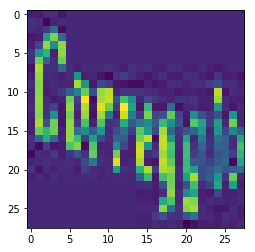

./mjsynth_dataset/train/31_welshes_86021.jpg
Image Shape Before Resize: (31, 102)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/31_welshes_86021.jpg
Label: welshes | Encoded Label: [48 30 37 44 33 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 48 30 37 44 33 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


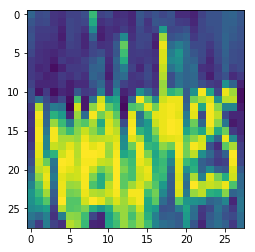

./mjsynth_dataset/train/320_NUTTED_52656.jpg
Image Shape Before Resize: (31, 103)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/320_NUTTED_52656.jpg
Label: NUTTED | Encoded Label: [13 20 19 19  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 20 19 19 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


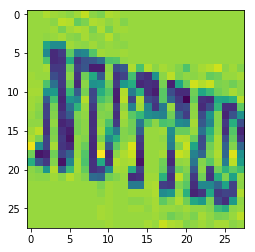

./mjsynth_dataset/train/321_Exasperate_27005.jpg
Image Shape Before Resize: (31, 180)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/321_Exasperate_27005.jpg
Label: Exasperate | Encoded Label: [ 4 49 26 44 41 30 43 26 45 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 49 26 44 41 30 43 26 45 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


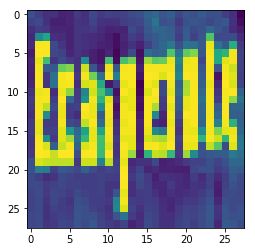

./mjsynth_dataset/train/322_EDSON_24650.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/322_EDSON_24650.jpg
Label: EDSON | Encoded Label: [ 4  3 18 14 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 3 18 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


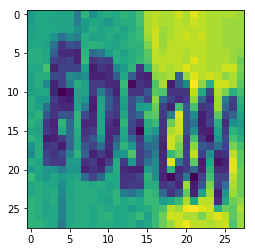

./mjsynth_dataset/train/323_avocado_5098.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/323_avocado_5098.jpg
Label: avocado | Encoded Label: [26 47 40 28 26 29 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 26 47 40 28 26 29 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


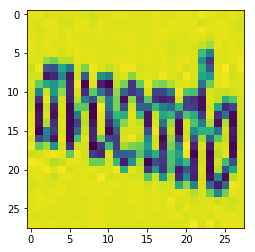

./mjsynth_dataset/train/324_Corrugations_17202.jpg
Image Shape Before Resize: (31, 161)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/324_Corrugations_17202.jpg
Label: Corrugations | Encoded Label: [ 2 40 43 43 46 32 26 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 43 43 46 32 26 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


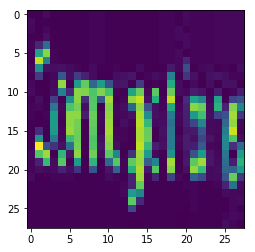

./mjsynth_dataset/train/325_Eiffel_24833.jpg
Image Shape Before Resize: (31, 52)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/325_Eiffel_24833.jpg
Label: Eiffel | Encoded Label: [ 4 34 31 31 30 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 34 31 31 30 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


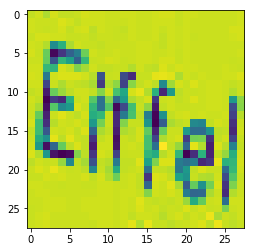

./mjsynth_dataset/train/326_Disinfectants_22358.jpg
Image Shape Before Resize: (31, 223)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/326_Disinfectants_22358.jpg
Label: Disinfectants | Encoded Label: [ 3 34 44 34 39 31 30 28 45 26 39 45 44  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 44 34 39 31 30 28 45 26 39 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


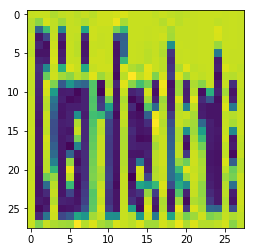

./mjsynth_dataset/train/327_FINENESS_28973.jpg
Image Shape Before Resize: (31, 149)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/327_FINENESS_28973.jpg
Label: FINENESS | Encoded Label: [ 5  8 13  4 13  4 18 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 8 13 4 13 4 18 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


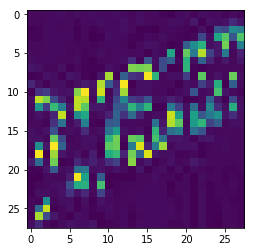

./mjsynth_dataset/train/328_CLAMMIEST_13871.jpg
Image Shape Before Resize: (31, 160)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/328_CLAMMIEST_13871.jpg
Label: CLAMMIEST | Encoded Label: [ 2 11  0 12 12  8  4 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 11 0 12 12 8 4 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


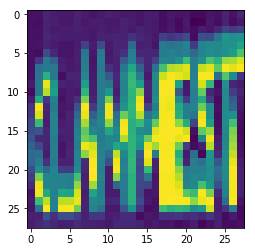

./mjsynth_dataset/train/329_vita_84846.jpg
Image Shape Before Resize: (31, 63)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/329_vita_84846.jpg
Label: vita | Encoded Label: [47 34 45 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 47 34 45 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


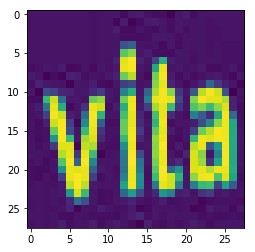

./mjsynth_dataset/train/32_fistula_29185.jpg
Image Shape Before Resize: (31, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/32_fistula_29185.jpg
Label: fistula | Encoded Label: [31 34 44 45 46 37 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 34 44 45 46 37 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


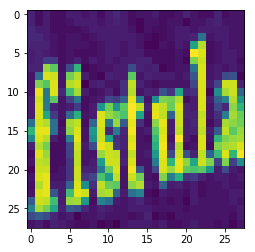

./mjsynth_dataset/train/330_Watercolors_85633.jpg
Image Shape Before Resize: (31, 85)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/330_Watercolors_85633.jpg
Label: Watercolors | Encoded Label: [22 26 45 30 43 28 40 37 40 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 26 45 30 43 28 40 37 40 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


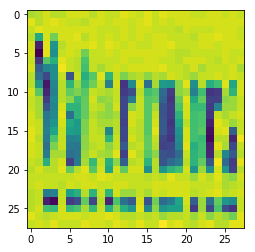

./mjsynth_dataset/train/331_Shenyang_70127.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/331_Shenyang_70127.jpg
Label: Shenyang | Encoded Label: [18 33 30 39 50 26 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 33 30 39 50 26 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


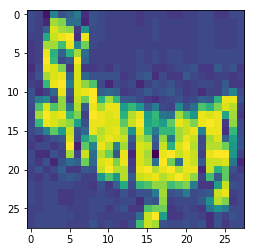

./mjsynth_dataset/train/332_BACKSPIN_5400.jpg
Image Shape Before Resize: (31, 131)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/332_BACKSPIN_5400.jpg
Label: BACKSPIN | Encoded Label: [ 1  0  2 10 18 15  8 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 0 2 10 18 15 8 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


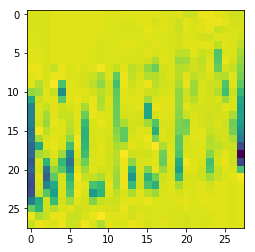

./mjsynth_dataset/train/333_COLLARED_14881.jpg
Image Shape Before Resize: (31, 133)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/333_COLLARED_14881.jpg
Label: COLLARED | Encoded Label: [ 2 14 11 11  0 17  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 11 11 0 17 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


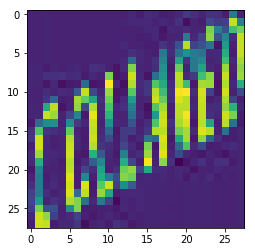

./mjsynth_dataset/train/334_Garlanded_31768.jpg
Image Shape Before Resize: (31, 97)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/334_Garlanded_31768.jpg
Label: Garlanded | Encoded Label: [ 6 26 43 37 26 39 29 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 26 43 37 26 39 29 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


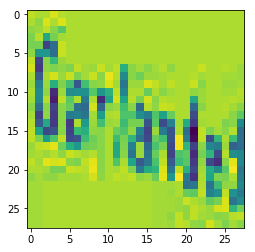

./mjsynth_dataset/train/335_Steepest_74503.jpg
Image Shape Before Resize: (31, 64)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/335_Steepest_74503.jpg
Label: Steepest | Encoded Label: [18 45 30 30 41 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 45 30 30 41 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


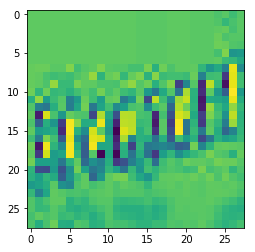

./mjsynth_dataset/train/336_Bitched_7705.jpg
Image Shape Before Resize: (31, 83)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/336_Bitched_7705.jpg
Label: Bitched | Encoded Label: [ 1 34 45 28 33 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 34 45 28 33 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


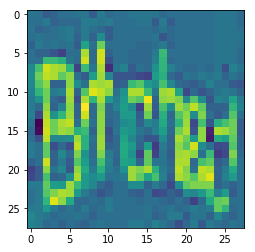

./mjsynth_dataset/train/337_fizz_29234.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/337_fizz_29234.jpg
Label: fizz | Encoded Label: [31 34 51 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 34 51 51 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


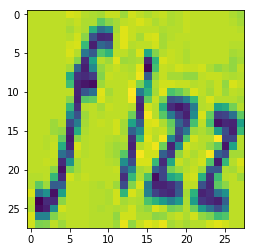

./mjsynth_dataset/train/338_FREEDMAN_30747.jpg
Image Shape Before Resize: (31, 103)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/338_FREEDMAN_30747.jpg
Label: FREEDMAN | Encoded Label: [ 5 17  4  4  3 12  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 17 4 4 3 12 0 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


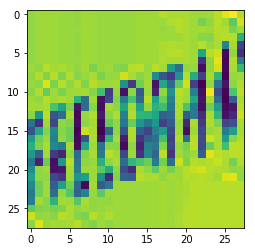

./mjsynth_dataset/train/339_woodchuck_87085.jpg
Image Shape Before Resize: (31, 120)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/339_woodchuck_87085.jpg
Label: woodchuck | Encoded Label: [48 40 40 29 28 33 46 28 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 48 40 40 29 28 33 46 28 36 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


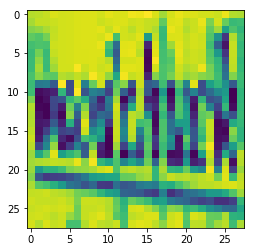

./mjsynth_dataset/train/33_SOAPSUDS_72418.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/33_SOAPSUDS_72418.jpg
Label: SOAPSUDS | Encoded Label: [18 14  0 15 18 20  3 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 14 0 15 18 20 3 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


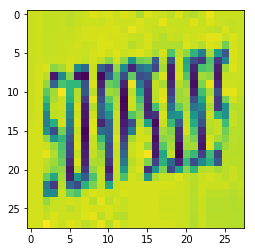

./mjsynth_dataset/train/340_Grouted_33937.jpg
Image Shape Before Resize: (31, 124)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/340_Grouted_33937.jpg
Label: Grouted | Encoded Label: [ 6 43 40 46 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 43 40 46 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


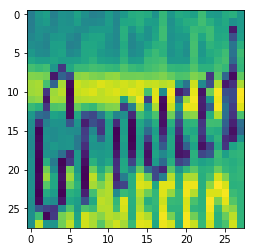

./mjsynth_dataset/train/341_Ajax_1815.jpg
Image Shape Before Resize: (31, 49)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/341_Ajax_1815.jpg
Label: Ajax | Encoded Label: [ 0 35 26 49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 35 26 49 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


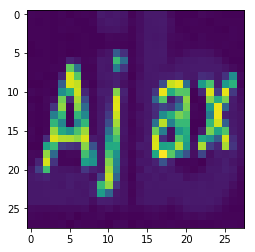

./mjsynth_dataset/train/342_levitation_44227.jpg
Image Shape Before Resize: (31, 161)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/342_levitation_44227.jpg
Label: levitation | Encoded Label: [37 30 47 34 45 26 45 34 40 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 37 30 47 34 45 26 45 34 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


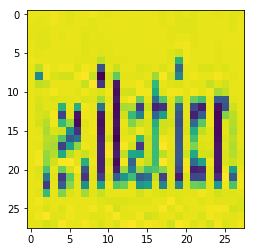

./mjsynth_dataset/train/343_Marathoners_46658.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/343_Marathoners_46658.jpg
Label: Marathoners | Encoded Label: [12 26 43 26 45 33 40 39 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 26 43 26 45 33 40 39 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


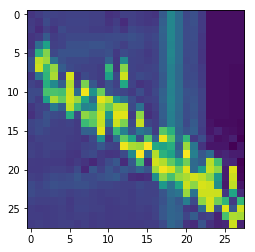

./mjsynth_dataset/train/344_Youths_87866.jpg
Image Shape Before Resize: (31, 84)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/344_Youths_87866.jpg
Label: Youths | Encoded Label: [24 40 46 45 33 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 24 40 46 45 33 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


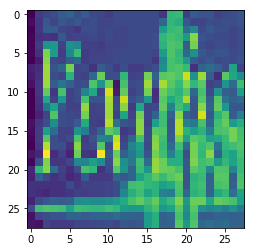

./mjsynth_dataset/train/345_ATTEMPT_4686.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/345_ATTEMPT_4686.jpg
Label: ATTEMPT | Encoded Label: [ 0 19 19  4 12 15 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 19 19 4 12 15 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


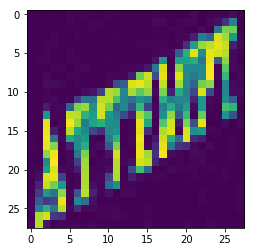

./mjsynth_dataset/train/346_GRAHAME_33352.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/346_GRAHAME_33352.jpg
Label: GRAHAME | Encoded Label: [ 6 17  0  7  0 12  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 17 0 7 0 12 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


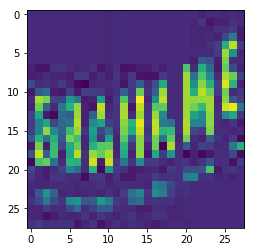

./mjsynth_dataset/train/347_REAWAKEN_62950.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/347_REAWAKEN_62950.jpg
Label: REAWAKEN | Encoded Label: [17  4  0 22  0 10  4 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 0 22 0 10 4 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


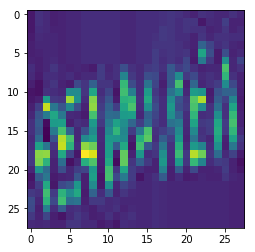

./mjsynth_dataset/train/348_misconstrue_48843.jpg
Image Shape Before Resize: (31, 84)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/348_misconstrue_48843.jpg
Label: misconstrue | Encoded Label: [38 34 44 28 40 39 44 45 43 46 30  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 34 44 28 40 39 44 45 43 46 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


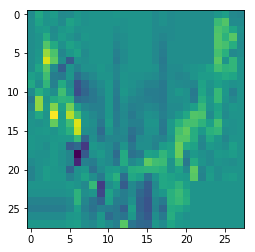

./mjsynth_dataset/train/349_filamentous_28853.jpg
Image Shape Before Resize: (31, 157)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/349_filamentous_28853.jpg
Label: filamentous | Encoded Label: [31 34 37 26 38 30 39 45 40 46 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 34 37 26 38 30 39 45 40 46 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


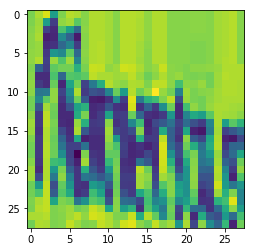

./mjsynth_dataset/train/34_TELEPHONES_77985.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/34_TELEPHONES_77985.jpg
Label: TELEPHONES | Encoded Label: [19  4 11  4 15  7 14 13  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 4 11 4 15 7 14 13 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


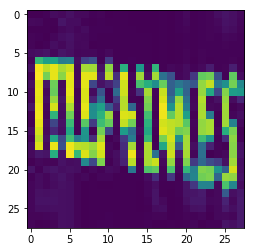

./mjsynth_dataset/train/350_EFFED_24714.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/350_EFFED_24714.jpg
Label: EFFED | Encoded Label: [4 5 5 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Encoded Label String: 4 5 5 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


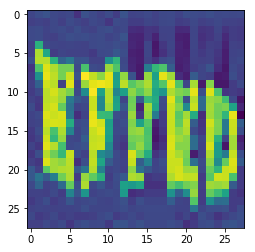

./mjsynth_dataset/train/351_EXPELLED_27383.jpg
Image Shape Before Resize: (31, 159)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/351_EXPELLED_27383.jpg
Label: EXPELLED | Encoded Label: [ 4 23 15  4 11 11  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 23 15 4 11 11 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


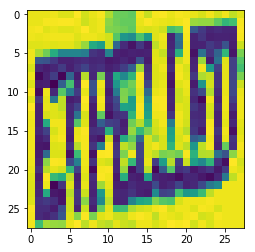

./mjsynth_dataset/train/352_Country_17512.jpg
Image Shape Before Resize: (31, 99)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/352_Country_17512.jpg
Label: Country | Encoded Label: [ 2 40 46 39 45 43 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 46 39 45 43 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


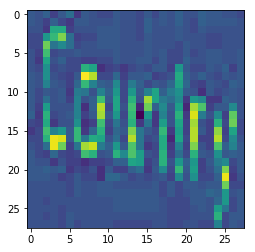

./mjsynth_dataset/train/353_PROFICIENTLY_60374.jpg
Image Shape Before Resize: (31, 79)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/353_PROFICIENTLY_60374.jpg
Label: PROFICIENTLY | Encoded Label: [15 17 14  5  8  2  8  4 13 19 11 24  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 14 5 8 2 8 4 13 19 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


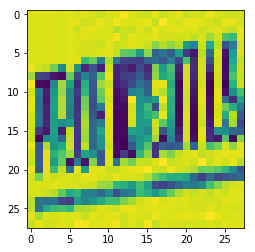

./mjsynth_dataset/train/354_swooned_76882.jpg
Image Shape Before Resize: (31, 121)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/354_swooned_76882.jpg
Label: swooned | Encoded Label: [44 48 40 40 39 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 48 40 40 39 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


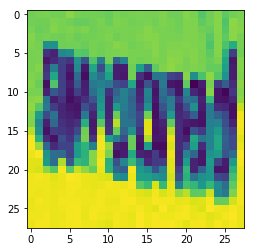

./mjsynth_dataset/train/355_Hindrances_36199.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/355_Hindrances_36199.jpg
Label: Hindrances | Encoded Label: [ 7 34 39 29 43 26 39 28 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 34 39 29 43 26 39 28 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


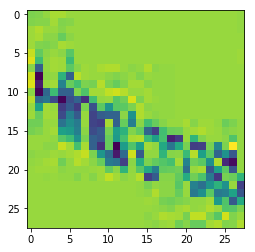

./mjsynth_dataset/train/356_REVELINGS_65685.jpg
Image Shape Before Resize: (31, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/356_REVELINGS_65685.jpg
Label: REVELINGS | Encoded Label: [17  4 21  4 11  8 13  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 21 4 11 8 13 6 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


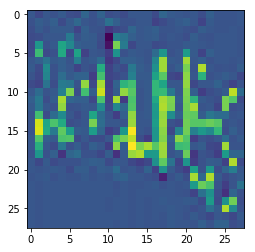

./mjsynth_dataset/train/357_tessellate_78343.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/357_tessellate_78343.jpg
Label: tessellate | Encoded Label: [45 30 44 44 30 37 37 26 45 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 30 44 44 30 37 37 26 45 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


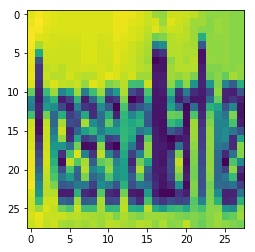

./mjsynth_dataset/train/358_PRIUS_60170.jpg
Image Shape Before Resize: (31, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/358_PRIUS_60170.jpg
Label: PRIUS | Encoded Label: [15 17  8 20 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 8 20 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


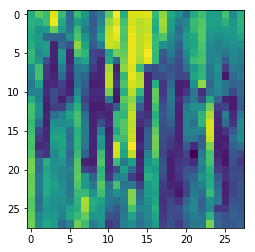

./mjsynth_dataset/train/359_cockiest_14600.jpg
Image Shape Before Resize: (31, 67)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/359_cockiest_14600.jpg
Label: cockiest | Encoded Label: [28 40 28 36 34 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 28 36 34 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


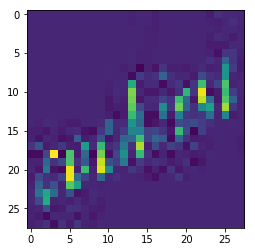

./mjsynth_dataset/train/35_Panoramas_55288.jpg
Image Shape Before Resize: (31, 163)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/35_Panoramas_55288.jpg
Label: Panoramas | Encoded Label: [15 26 39 40 43 26 38 26 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 26 39 40 43 26 38 26 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


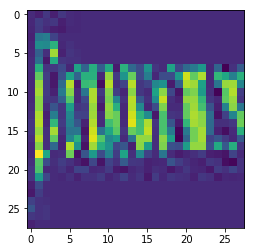

./mjsynth_dataset/train/360_Exertions_27205.jpg
Image Shape Before Resize: (31, 138)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/360_Exertions_27205.jpg
Label: Exertions | Encoded Label: [ 4 49 30 43 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 49 30 43 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


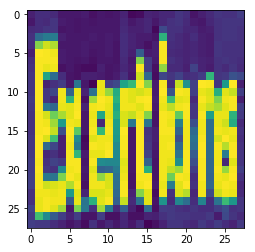

./mjsynth_dataset/train/361_FOMALHAUT_29989.jpg
Image Shape Before Resize: (31, 139)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/361_FOMALHAUT_29989.jpg
Label: FOMALHAUT | Encoded Label: [ 5 14 12  0 11  7  0 20 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 14 12 0 11 7 0 20 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


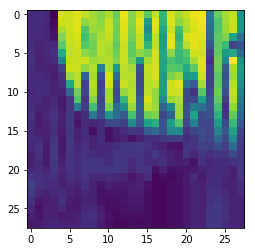

./mjsynth_dataset/train/362_Dastardly_19310.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/362_Dastardly_19310.jpg
Label: Dastardly | Encoded Label: [ 3 26 44 45 26 43 29 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 26 44 45 26 43 29 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


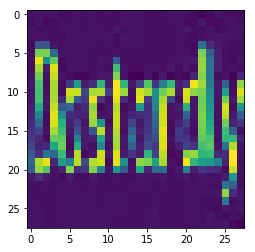

./mjsynth_dataset/train/363_Diurnal_22859.jpg
Image Shape Before Resize: (31, 95)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/363_Diurnal_22859.jpg
Label: Diurnal | Encoded Label: [ 3 34 46 43 39 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 46 43 39 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


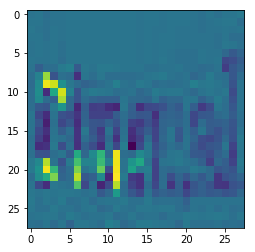

./mjsynth_dataset/train/364_REPATRIATION_64747.jpg
Image Shape Before Resize: (31, 380)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/364_REPATRIATION_64747.jpg
Label: REPATRIATION | Encoded Label: [17  4 15  0 19 17  8  0 19  8 14 13  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 15 0 19 17 8 0 19 8 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


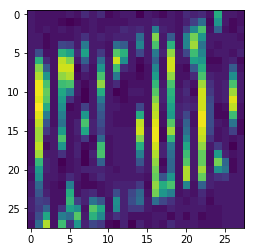

./mjsynth_dataset/train/365_WHIMSICALLY_86249.jpg
Image Shape Before Resize: (31, 141)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/365_WHIMSICALLY_86249.jpg
Label: WHIMSICALLY | Encoded Label: [22  7  8 12 18  8  2  0 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 7 8 12 18 8 2 0 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


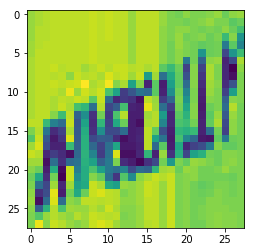

./mjsynth_dataset/train/366_Stales_74156.jpg
Image Shape Before Resize: (31, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/366_Stales_74156.jpg
Label: Stales | Encoded Label: [18 45 26 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 45 26 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


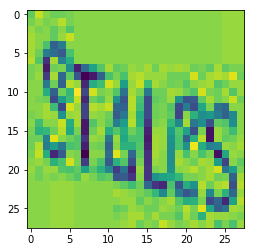

./mjsynth_dataset/train/367_flicked_29541.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/367_flicked_29541.jpg
Label: flicked | Encoded Label: [31 37 34 28 36 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 37 34 28 36 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


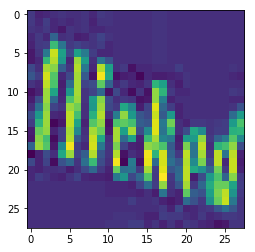

./mjsynth_dataset/train/368_coquette_16962.jpg
Image Shape Before Resize: (31, 92)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/368_coquette_16962.jpg
Label: coquette | Encoded Label: [28 40 42 46 30 45 45 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 42 46 30 45 45 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


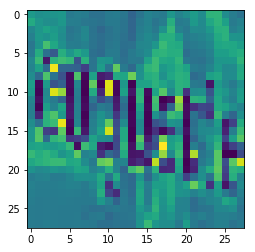

./mjsynth_dataset/train/369_REHIRE_64136.jpg
Image Shape Before Resize: (31, 137)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/369_REHIRE_64136.jpg
Label: REHIRE | Encoded Label: [17  4  7  8 17  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 7 8 17 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


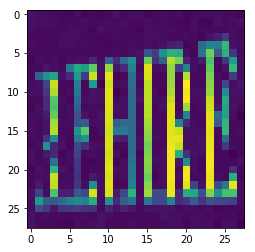

./mjsynth_dataset/train/36_ADHESIVENESS_1023.jpg
Image Shape Before Resize: (31, 167)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/36_ADHESIVENESS_1023.jpg
Label: ADHESIVENESS | Encoded Label: [ 0  3  7  4 18  8 21  4 13  4 18 18  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 3 7 4 18 8 21 4 13 4 18 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


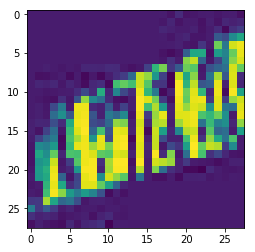

./mjsynth_dataset/train/370_sells_69275.jpg
Image Shape Before Resize: (31, 42)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/370_sells_69275.jpg
Label: sells | Encoded Label: [44 30 37 37 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 30 37 37 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


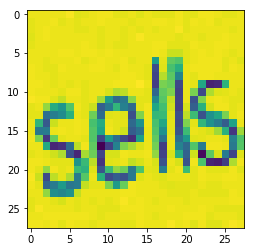

./mjsynth_dataset/train/371_bianca_7314.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/371_bianca_7314.jpg
Label: bianca | Encoded Label: [27 34 26 39 28 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 34 26 39 28 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


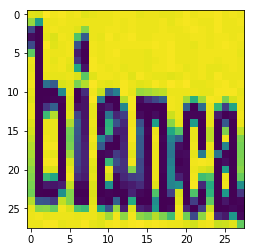

./mjsynth_dataset/train/372_Assignable_4409.jpg
Image Shape Before Resize: (31, 141)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/372_Assignable_4409.jpg
Label: Assignable | Encoded Label: [ 0 44 44 34 32 39 26 27 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 44 44 34 32 39 26 27 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


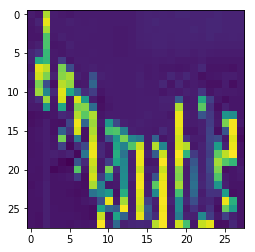

./mjsynth_dataset/train/373_Moet_49327.jpg
Image Shape Before Resize: (31, 74)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/373_Moet_49327.jpg
Label: Moet | Encoded Label: [12 40 30 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 40 30 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


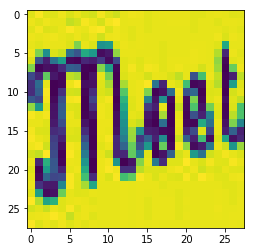

./mjsynth_dataset/train/374_prepubescents_59783.jpg
Image Shape Before Resize: (31, 81)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/374_prepubescents_59783.jpg
Label: prepubescents | Encoded Label: [41 43 30 41 46 27 30 44 28 30 39 45 44  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 43 30 41 46 27 30 44 28 30 39 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


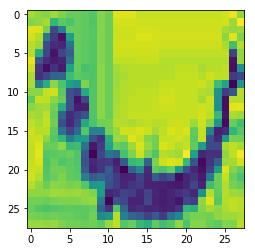

./mjsynth_dataset/train/375_Footrest_30084.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/375_Footrest_30084.jpg
Label: Footrest | Encoded Label: [ 5 40 40 45 43 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 40 40 45 43 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


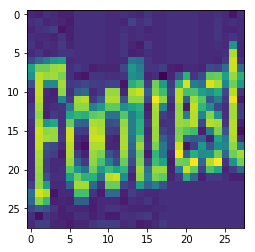

./mjsynth_dataset/train/376_mountings_50075.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/376_mountings_50075.jpg
Label: mountings | Encoded Label: [38 40 46 39 45 34 39 32 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 40 46 39 45 34 39 32 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


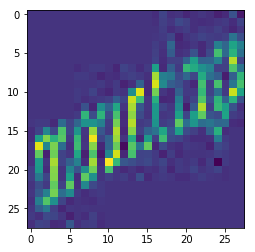

./mjsynth_dataset/train/377_Damn_19117.jpg
Image Shape Before Resize: (31, 81)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/377_Damn_19117.jpg
Label: Damn | Encoded Label: [ 3 26 38 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 26 38 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


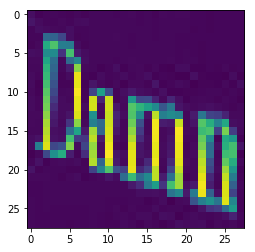

./mjsynth_dataset/train/378_Wast_85582.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/378_Wast_85582.jpg
Label: Wast | Encoded Label: [22 26 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 26 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


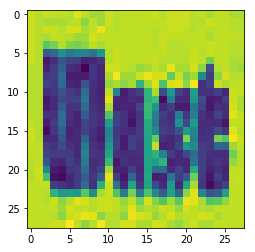

./mjsynth_dataset/train/379_Pimply_57666.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/379_Pimply_57666.jpg
Label: Pimply | Encoded Label: [15 34 38 41 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 34 38 41 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


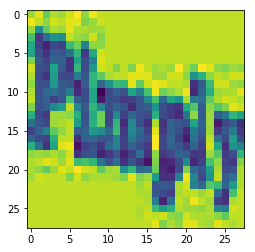

./mjsynth_dataset/train/37_FINESPUN_28977.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/37_FINESPUN_28977.jpg
Label: FINESPUN | Encoded Label: [ 5  8 13  4 18 15 20 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 8 13 4 18 15 20 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


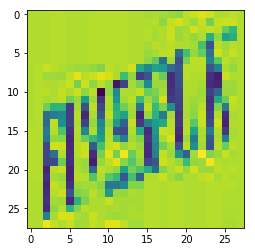

./mjsynth_dataset/train/380_Thunderously_78938.jpg
Image Shape Before Resize: (31, 204)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/380_Thunderously_78938.jpg
Label: Thunderously | Encoded Label: [19 33 46 39 29 30 43 40 46 44 37 50  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 33 46 39 29 30 43 40 46 44 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


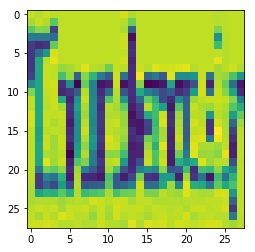

./mjsynth_dataset/train/381_Fructifying_31082.jpg
Image Shape Before Resize: (31, 129)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/381_Fructifying_31082.jpg
Label: Fructifying | Encoded Label: [ 5 43 46 28 45 34 31 50 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 43 46 28 45 34 31 50 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


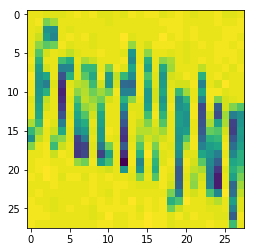

./mjsynth_dataset/train/382_HATCHBACKS_35155.jpg
Image Shape Before Resize: (31, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/382_HATCHBACKS_35155.jpg
Label: HATCHBACKS | Encoded Label: [ 7  0 19  2  7  1  0  2 10 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 0 19 2 7 1 0 2 10 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


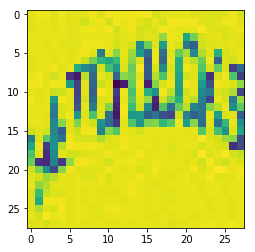

./mjsynth_dataset/train/383_SNOOPIEST_72274.jpg
Image Shape Before Resize: (32, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/383_SNOOPIEST_72274.jpg
Label: SNOOPIEST | Encoded Label: [18 13 14 14 15  8  4 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 13 14 14 15 8 4 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


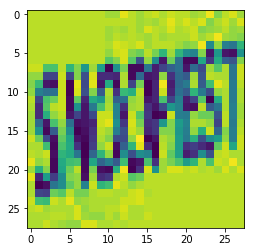

./mjsynth_dataset/train/384_MANHOOD_46479.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/384_MANHOOD_46479.jpg
Label: MANHOOD | Encoded Label: [12  0 13  7 14 14  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 0 13 7 14 14 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


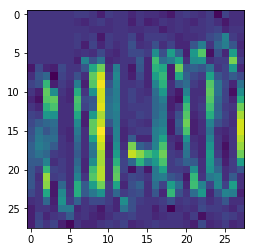

./mjsynth_dataset/train/385_SHIFTILY_70181.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/385_SHIFTILY_70181.jpg
Label: SHIFTILY | Encoded Label: [18  7  8  5 19  8 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 7 8 5 19 8 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


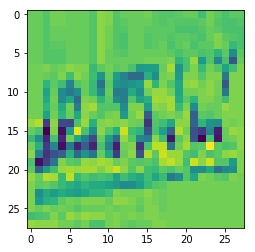

./mjsynth_dataset/train/386_JOSEPHINUM_41743.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/386_JOSEPHINUM_41743.jpg
Label: JOSEPHINUM | Encoded Label: [ 9 14 18  4 15  7  8 13 20 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 9 14 18 4 15 7 8 13 20 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


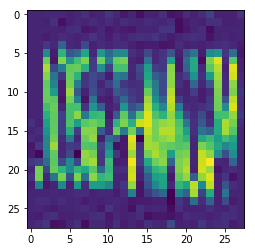

./mjsynth_dataset/train/387_EXQUISITELY_27556.jpg
Image Shape Before Resize: (31, 102)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/387_EXQUISITELY_27556.jpg
Label: EXQUISITELY | Encoded Label: [ 4 23 16 20  8 18  8 19  4 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 23 16 20 8 18 8 19 4 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


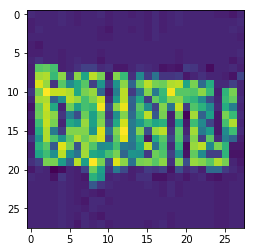

./mjsynth_dataset/train/388_craggier_17777.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/388_craggier_17777.jpg
Label: craggier | Encoded Label: [28 43 26 32 32 34 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 43 26 32 32 34 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


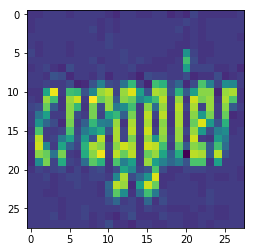

./mjsynth_dataset/train/389_agonizes_1625.jpg
Image Shape Before Resize: (31, 78)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/389_agonizes_1625.jpg
Label: agonizes | Encoded Label: [26 32 40 39 34 51 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 26 32 40 39 34 51 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


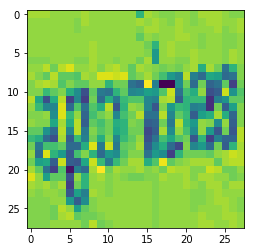

./mjsynth_dataset/train/38_BEGAT_6694.jpg
Image Shape Before Resize: (31, 59)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/38_BEGAT_6694.jpg
Label: BEGAT | Encoded Label: [ 1  4  6  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 4 6 0 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


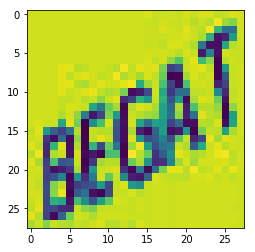

./mjsynth_dataset/train/390_Callable_10900.jpg
Image Shape Before Resize: (31, 132)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/390_Callable_10900.jpg
Label: Callable | Encoded Label: [ 2 26 37 37 26 27 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 26 37 37 26 27 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


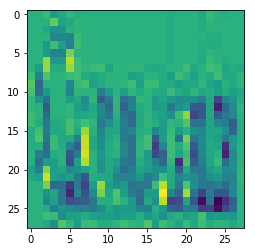

./mjsynth_dataset/train/391_Respecter_65251.jpg
Image Shape Before Resize: (31, 138)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/391_Respecter_65251.jpg
Label: Respecter | Encoded Label: [17 30 44 41 30 28 45 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 44 41 30 28 45 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


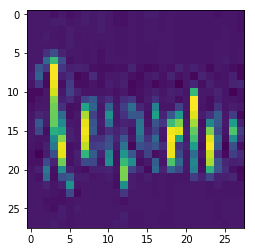

./mjsynth_dataset/train/392_RETENTION_65485.jpg
Image Shape Before Resize: (31, 106)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/392_RETENTION_65485.jpg
Label: RETENTION | Encoded Label: [17  4 19  4 13 19  8 14 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 19 4 13 19 8 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


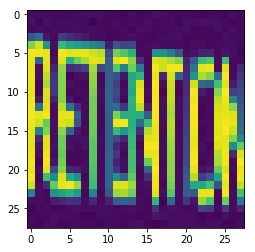

./mjsynth_dataset/train/393_Disorders_22463.jpg
Image Shape Before Resize: (31, 92)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/393_Disorders_22463.jpg
Label: Disorders | Encoded Label: [ 3 34 44 40 43 29 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 34 44 40 43 29 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


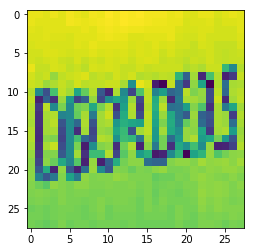

./mjsynth_dataset/train/394_Commencement_15182.jpg
Image Shape Before Resize: (31, 136)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/394_Commencement_15182.jpg
Label: Commencement | Encoded Label: [ 2 40 38 38 30 39 28 30 38 30 39 45  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 38 38 30 39 28 30 38 30 39 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


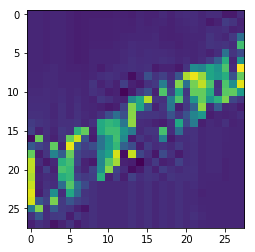

./mjsynth_dataset/train/395_cliometricians_14216.jpg
Image Shape Before Resize: (31, 184)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/395_cliometricians_14216.jpg
Label: cliometricians | Encoded Label: [28 37 34 40 38 30 45 43 34 28 34 26 39 44  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 37 34 40 38 30 45 43 34 28 34 26 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


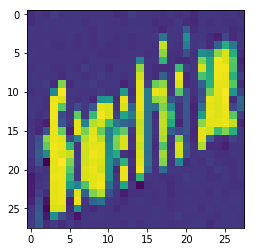

./mjsynth_dataset/train/396_ERECTING_26364.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/396_ERECTING_26364.jpg
Label: ERECTING | Encoded Label: [ 4 17  4  2 19  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 17 4 2 19 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


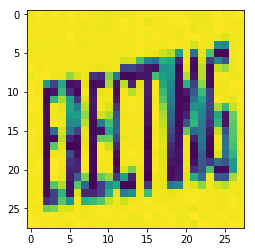

./mjsynth_dataset/train/397_SADHU_67318.jpg
Image Shape Before Resize: (31, 137)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/397_SADHU_67318.jpg
Label: SADHU | Encoded Label: [18  0  3  7 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 0 3 7 20 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


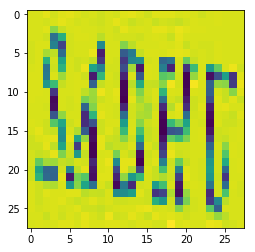

./mjsynth_dataset/train/398_FORKS_30346.jpg
Image Shape Before Resize: (31, 122)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/398_FORKS_30346.jpg
Label: FORKS | Encoded Label: [ 5 14 17 10 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 14 17 10 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


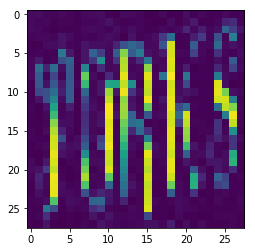

./mjsynth_dataset/train/399_vertigo_84421.jpg
Image Shape Before Resize: (31, 123)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/399_vertigo_84421.jpg
Label: vertigo | Encoded Label: [47 30 43 45 34 32 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 47 30 43 45 34 32 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


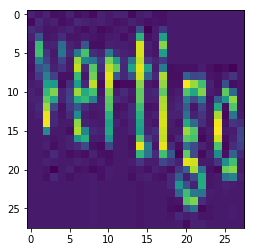

./mjsynth_dataset/train/39_overstatements_54711.jpg
Image Shape Before Resize: (31, 239)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/39_overstatements_54711.jpg
Label: overstatements | Encoded Label: [40 47 30 43 44 45 26 45 30 38 30 39 45 44  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 40 47 30 43 44 45 26 45 30 38 30 39 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


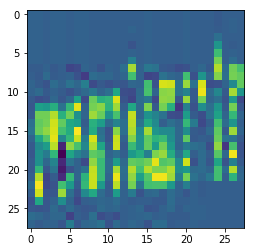

./mjsynth_dataset/train/3_SLEAZEBALL_71568.jpg
Image Shape Before Resize: (31, 182)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/3_SLEAZEBALL_71568.jpg
Label: SLEAZEBALL | Encoded Label: [18 11  4  0 25  4  1  0 11 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 11 4 0 25 4 1 0 11 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


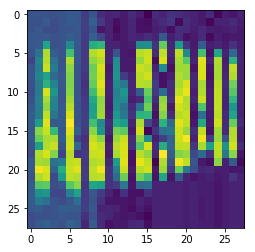

./mjsynth_dataset/train/400_CHAGRINED_12533.jpg
Image Shape Before Resize: (32, 144)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/400_CHAGRINED_12533.jpg
Label: CHAGRINED | Encoded Label: [ 2  7  0  6 17  8 13  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 7 0 6 17 8 13 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


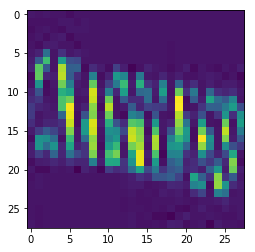

./mjsynth_dataset/train/401_MINIATURIZING_48604.jpg
Image Shape Before Resize: (31, 185)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/401_MINIATURIZING_48604.jpg
Label: MINIATURIZING | Encoded Label: [12  8 13  8  0 19 20 17  8 25  8 13  6  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 8 13 8 0 19 20 17 8 25 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


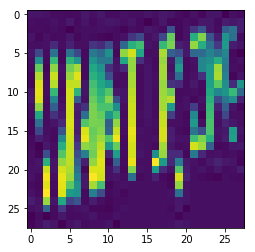

./mjsynth_dataset/train/402_MERCHANTS_47844.jpg
Image Shape Before Resize: (31, 85)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/402_MERCHANTS_47844.jpg
Label: MERCHANTS | Encoded Label: [12  4 17  2  7  0 13 19 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 4 17 2 7 0 13 19 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


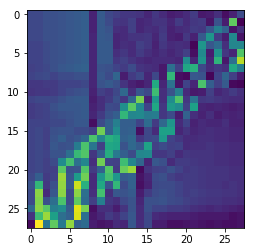

./mjsynth_dataset/train/403_REACQUIRING_62707.jpg
Image Shape Before Resize: (31, 178)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/403_REACQUIRING_62707.jpg
Label: REACQUIRING | Encoded Label: [17  4  0  2 16 20  8 17  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 4 0 2 16 20 8 17 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


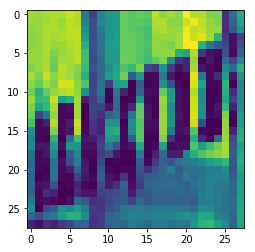

./mjsynth_dataset/train/404_MUZZLING_50665.jpg
Image Shape Before Resize: (31, 173)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/404_MUZZLING_50665.jpg
Label: MUZZLING | Encoded Label: [12 20 25 25 11  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 20 25 25 11 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


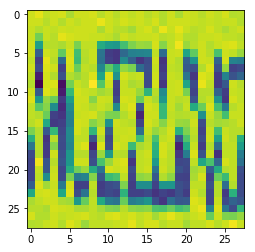

./mjsynth_dataset/train/405_Dumbfounded_24091.jpg
Image Shape Before Resize: (31, 108)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/405_Dumbfounded_24091.jpg
Label: Dumbfounded | Encoded Label: [ 3 46 38 27 31 40 46 39 29 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 46 38 27 31 40 46 39 29 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


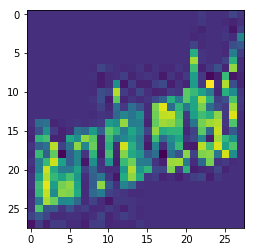

./mjsynth_dataset/train/406_Aggravatingly_1572.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/406_Aggravatingly_1572.jpg
Label: Aggravatingly | Encoded Label: [ 0 32 32 43 26 47 26 45 34 39 32 37 50  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 32 32 43 26 47 26 45 34 39 32 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


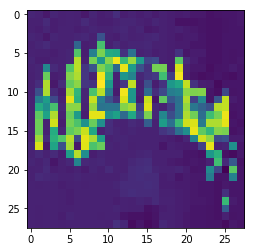

./mjsynth_dataset/train/407_relented_64366.jpg
Image Shape Before Resize: (31, 61)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/407_relented_64366.jpg
Label: relented | Encoded Label: [43 30 37 30 39 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 30 37 30 39 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


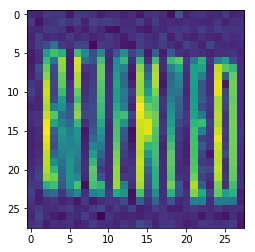

./mjsynth_dataset/train/408_PESTERS_56988.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/408_PESTERS_56988.jpg
Label: PESTERS | Encoded Label: [15  4 18 19  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 4 18 19 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


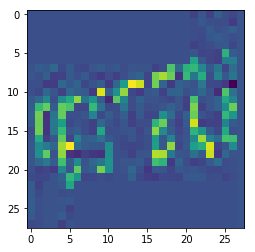

./mjsynth_dataset/train/409_Cordovan_16995.jpg
Image Shape Before Resize: (31, 154)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/409_Cordovan_16995.jpg
Label: Cordovan | Encoded Label: [ 2 40 43 29 40 47 26 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 40 43 29 40 47 26 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


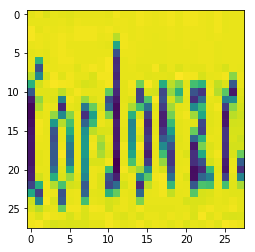

./mjsynth_dataset/train/40_owned_54841.jpg
Image Shape Before Resize: (31, 79)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/40_owned_54841.jpg
Label: owned | Encoded Label: [40 48 39 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 40 48 39 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


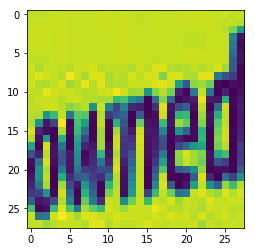

./mjsynth_dataset/train/410_Worldliest_87262.jpg
Image Shape Before Resize: (31, 66)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/410_Worldliest_87262.jpg
Label: Worldliest | Encoded Label: [22 40 43 37 29 37 34 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 40 43 37 29 37 34 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


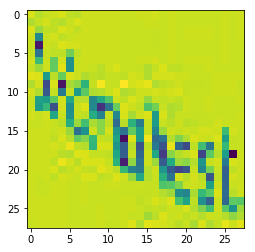

./mjsynth_dataset/train/411_trust_80982.jpg
Image Shape Before Resize: (31, 58)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/411_trust_80982.jpg
Label: trust | Encoded Label: [45 43 46 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 43 46 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


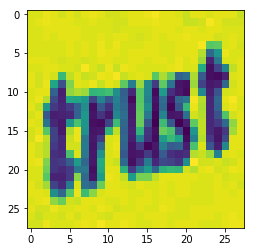

./mjsynth_dataset/train/412_IMAGES_38006.jpg
Image Shape Before Resize: (31, 120)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/412_IMAGES_38006.jpg
Label: IMAGES | Encoded Label: [ 8 12  0  6  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 12 0 6 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


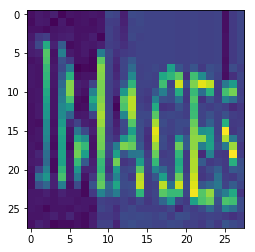

./mjsynth_dataset/train/413_Detaining_21137.jpg
Image Shape Before Resize: (31, 115)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/413_Detaining_21137.jpg
Label: Detaining | Encoded Label: [ 3 30 45 26 34 39 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 30 45 26 34 39 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


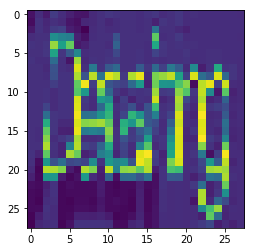

./mjsynth_dataset/train/414_Zambian_87938.jpg
Image Shape Before Resize: (31, 187)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/414_Zambian_87938.jpg
Label: Zambian | Encoded Label: [25 26 38 27 34 26 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 25 26 38 27 34 26 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


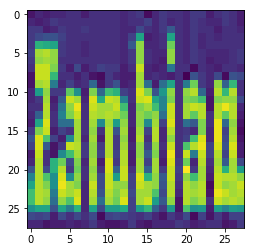

./mjsynth_dataset/train/415_DICKS_21484.jpg
Image Shape Before Resize: (31, 59)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/415_DICKS_21484.jpg
Label: DICKS | Encoded Label: [ 3  8  2 10 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 8 2 10 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


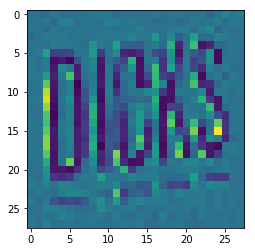

./mjsynth_dataset/train/416_OOZIER_53440.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/416_OOZIER_53440.jpg
Label: OOZIER | Encoded Label: [14 14 25  8  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 14 25 8 4 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


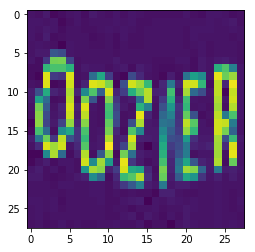

./mjsynth_dataset/train/417_BERN_7074.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/417_BERN_7074.jpg
Label: BERN | Encoded Label: [ 1  4 17 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 4 17 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


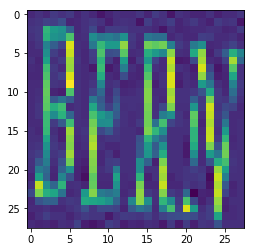

./mjsynth_dataset/train/418_BATISTE_6255.jpg
Image Shape Before Resize: (31, 240)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/418_BATISTE_6255.jpg
Label: BATISTE | Encoded Label: [ 1  0 19  8 18 19  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 0 19 8 18 19 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


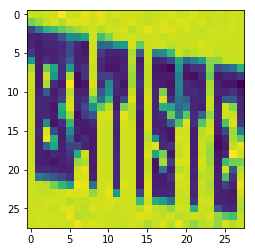

./mjsynth_dataset/train/419_LIDS_44363.jpg
Image Shape Before Resize: (31, 90)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/419_LIDS_44363.jpg
Label: LIDS | Encoded Label: [11  8  3 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 8 3 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


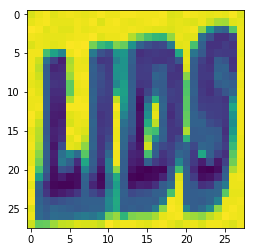

./mjsynth_dataset/train/41_FRENETICALLY_30822.jpg
Image Shape Before Resize: (31, 133)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/41_FRENETICALLY_30822.jpg
Label: FRENETICALLY | Encoded Label: [ 5 17  4 13  4 19  8  2  0 11 11 24  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 17 4 13 4 19 8 2 0 11 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


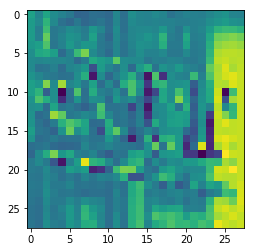

./mjsynth_dataset/train/420_Nub_52493.jpg
Image Shape Before Resize: (31, 65)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/420_Nub_52493.jpg
Label: Nub | Encoded Label: [13 46 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 46 27 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


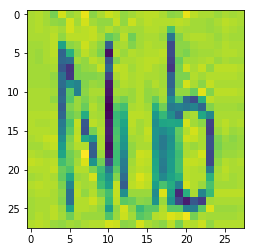

./mjsynth_dataset/train/421_ALSTON_2248.jpg
Image Shape Before Resize: (31, 70)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/421_ALSTON_2248.jpg
Label: ALSTON | Encoded Label: [ 0 11 18 19 14 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 11 18 19 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


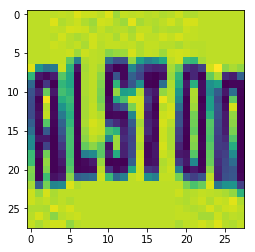

./mjsynth_dataset/train/422_HEAVENS_35525.jpg
Image Shape Before Resize: (31, 61)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/422_HEAVENS_35525.jpg
Label: HEAVENS | Encoded Label: [ 7  4  0 21  4 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 4 0 21 4 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


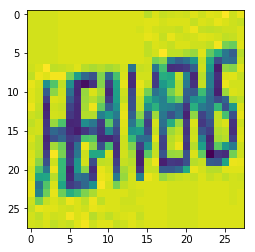

./mjsynth_dataset/train/423_Drams_23673.jpg
Image Shape Before Resize: (31, 60)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/423_Drams_23673.jpg
Label: Drams | Encoded Label: [ 3 43 26 38 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 43 26 38 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


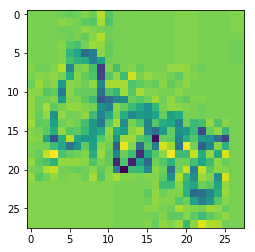

./mjsynth_dataset/train/424_Moussorgsky_50105.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/424_Moussorgsky_50105.jpg
Label: Moussorgsky | Encoded Label: [12 40 46 44 44 40 43 32 44 36 50  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 40 46 44 44 40 43 32 44 36 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


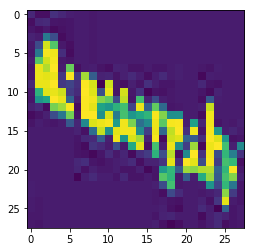

./mjsynth_dataset/train/425_ENRICHING_25918.jpg
Image Shape Before Resize: (31, 127)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/425_ENRICHING_25918.jpg
Label: ENRICHING | Encoded Label: [ 4 13 17  8  2  7  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 13 17 8 2 7 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


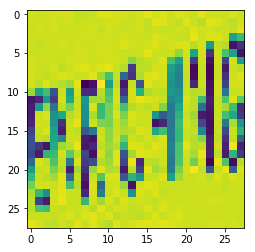

./mjsynth_dataset/train/426_BEEBREAD_6606.jpg
Image Shape Before Resize: (31, 135)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/426_BEEBREAD_6606.jpg
Label: BEEBREAD | Encoded Label: [ 1  4  4  1 17  4  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 4 4 1 17 4 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


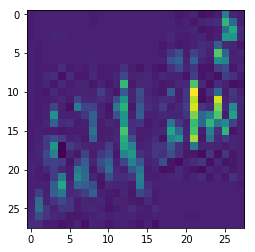

./mjsynth_dataset/train/427_farewell_28125.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/427_farewell_28125.jpg
Label: farewell | Encoded Label: [31 26 43 30 48 30 37 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 26 43 30 48 30 37 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


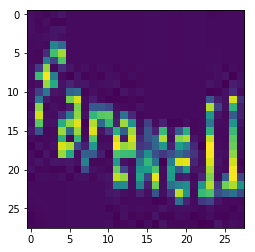

./mjsynth_dataset/train/428_Revising_65760.jpg
Image Shape Before Resize: (31, 112)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/428_Revising_65760.jpg
Label: Revising | Encoded Label: [17 30 47 34 44 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 47 34 44 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


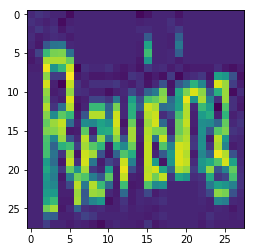

./mjsynth_dataset/train/429_Gleefully_32707.jpg
Image Shape Before Resize: (31, 105)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/429_Gleefully_32707.jpg
Label: Gleefully | Encoded Label: [ 6 37 30 30 31 46 37 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 37 30 30 31 46 37 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


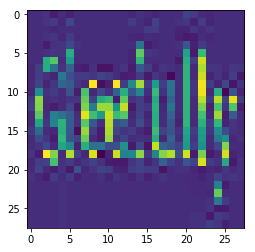

./mjsynth_dataset/train/42_FIRMEST_29118.jpg
Image Shape Before Resize: (31, 73)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/42_FIRMEST_29118.jpg
Label: FIRMEST | Encoded Label: [ 5  8 17 12  4 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 8 17 12 4 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


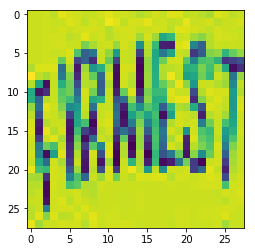

./mjsynth_dataset/train/430_watered_85638.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/430_watered_85638.jpg
Label: watered | Encoded Label: [48 26 45 30 43 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 48 26 45 30 43 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


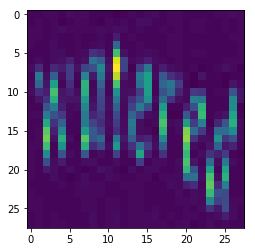

./mjsynth_dataset/train/431_GALLSTONES_31593.jpg
Image Shape Before Resize: (31, 230)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/431_GALLSTONES_31593.jpg
Label: GALLSTONES | Encoded Label: [ 6  0 11 11 18 19 14 13  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 6 0 11 11 18 19 14 13 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


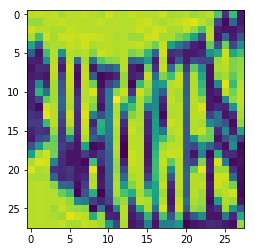

./mjsynth_dataset/train/432_CHORDAL_13445.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/432_CHORDAL_13445.jpg
Label: CHORDAL | Encoded Label: [ 2  7 14 17  3  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 7 14 17 3 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


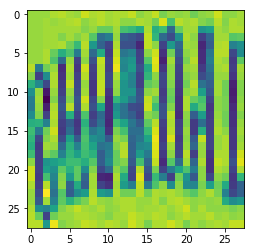

./mjsynth_dataset/train/433_Uniting_82736.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/433_Uniting_82736.jpg
Label: Uniting | Encoded Label: [20 39 34 45 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 34 45 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


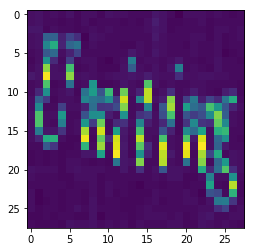

./mjsynth_dataset/train/434_BLAZONS_7952.jpg
Image Shape Before Resize: (31, 79)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/434_BLAZONS_7952.jpg
Label: BLAZONS | Encoded Label: [ 1 11  0 25 14 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 11 0 25 14 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


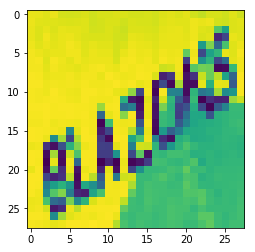

./mjsynth_dataset/train/435_AUGUSTLY_4857.jpg
Image Shape Before Resize: (31, 155)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/435_AUGUSTLY_4857.jpg
Label: AUGUSTLY | Encoded Label: [ 0 20  6 20 18 19 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 20 6 20 18 19 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


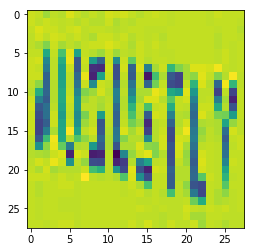

./mjsynth_dataset/train/436_UNFURLS_82530.jpg
Image Shape Before Resize: (31, 130)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/436_UNFURLS_82530.jpg
Label: UNFURLS | Encoded Label: [20 13  5 20 17 11 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 13 5 20 17 11 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


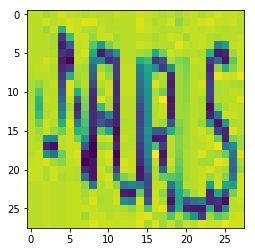

./mjsynth_dataset/train/437_Bulletined_10117.jpg
Image Shape Before Resize: (31, 174)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/437_Bulletined_10117.jpg
Label: Bulletined | Encoded Label: [ 1 46 37 37 30 45 34 39 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 46 37 37 30 45 34 39 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


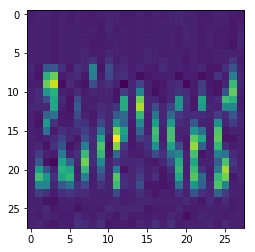

./mjsynth_dataset/train/438_tracheal_79987.jpg
Image Shape Before Resize: (32, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/438_tracheal_79987.jpg
Label: tracheal | Encoded Label: [45 43 26 28 33 30 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 43 26 28 33 30 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


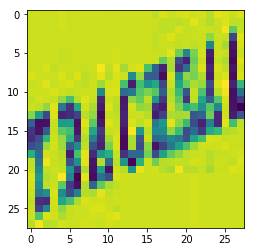

./mjsynth_dataset/train/439_Trust_80982.jpg
Image Shape Before Resize: (31, 94)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/439_Trust_80982.jpg
Label: Trust | Encoded Label: [19 43 46 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 43 46 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


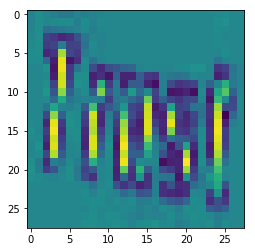

./mjsynth_dataset/train/43_SLUES_71849.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/43_SLUES_71849.jpg
Label: SLUES | Encoded Label: [18 11 20  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 11 20 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


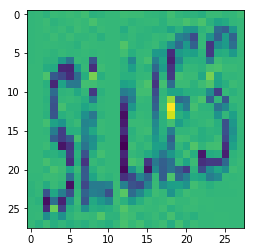

./mjsynth_dataset/train/440_Sheer_70074.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/440_Sheer_70074.jpg
Label: Sheer | Encoded Label: [18 33 30 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 33 30 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


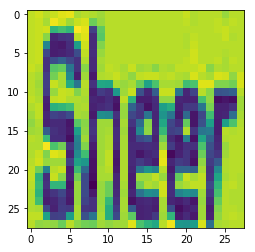

./mjsynth_dataset/train/441_pcb_56093.jpg
Image Shape Before Resize: (31, 42)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/441_pcb_56093.jpg
Label: pcb | Encoded Label: [41 28 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 28 27 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


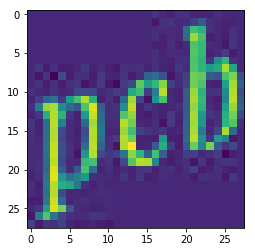

./mjsynth_dataset/train/442_spender_73326.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/442_spender_73326.jpg
Label: spender | Encoded Label: [44 41 30 39 29 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 41 30 39 29 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


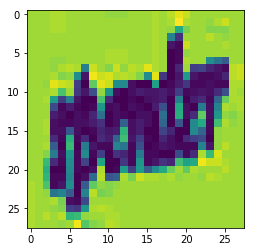

./mjsynth_dataset/train/443_waterlily_85654.jpg
Image Shape Before Resize: (31, 144)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/443_waterlily_85654.jpg
Label: waterlily | Encoded Label: [48 26 45 30 43 37 34 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 48 26 45 30 43 37 34 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


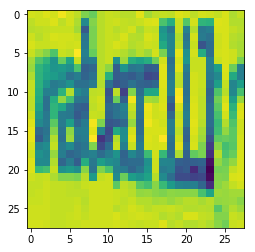

./mjsynth_dataset/train/444_CUSTOMHOUSE_18827.jpg
Image Shape Before Resize: (31, 148)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/444_CUSTOMHOUSE_18827.jpg
Label: CUSTOMHOUSE | Encoded Label: [ 2 20 18 19 14 12  7 14 20 18  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 20 18 19 14 12 7 14 20 18 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


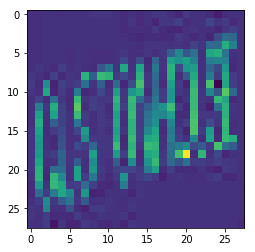

./mjsynth_dataset/train/445_PRIZEFIGHTERS_60203.jpg
Image Shape Before Resize: (32, 240)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/445_PRIZEFIGHTERS_60203.jpg
Label: PRIZEFIGHTERS | Encoded Label: [15 17  8 25  4  5  8  6  7 19  4 17 18  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 8 25 4 5 8 6 7 19 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


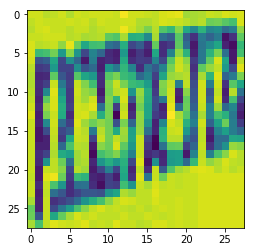

./mjsynth_dataset/train/446_mandamuses_46407.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/446_mandamuses_46407.jpg
Label: mandamuses | Encoded Label: [38 26 39 29 26 38 46 44 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 26 39 29 26 38 46 44 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


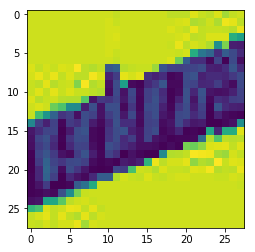

./mjsynth_dataset/train/447_Newly_51465.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/447_Newly_51465.jpg
Label: Newly | Encoded Label: [13 30 48 37 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 30 48 37 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


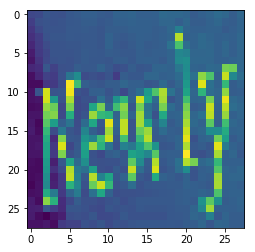

./mjsynth_dataset/train/448_DISCRETELY_22176.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/448_DISCRETELY_22176.jpg
Label: DISCRETELY | Encoded Label: [ 3  8 18  2 17  4 19  4 11 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 8 18 2 17 4 19 4 11 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


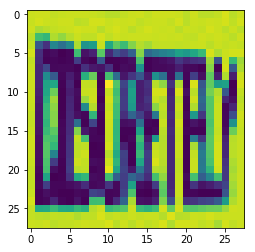

./mjsynth_dataset/train/449_NOUMEA_52419.jpg
Image Shape Before Resize: (31, 131)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/449_NOUMEA_52419.jpg
Label: NOUMEA | Encoded Label: [13 14 20 12  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 14 20 12 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


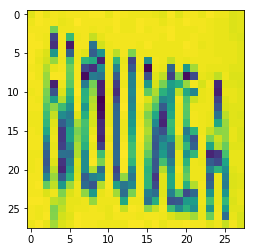

./mjsynth_dataset/train/44_Scion_68421.jpg
Image Shape Before Resize: (31, 62)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/44_Scion_68421.jpg
Label: Scion | Encoded Label: [18 28 34 40 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 28 34 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


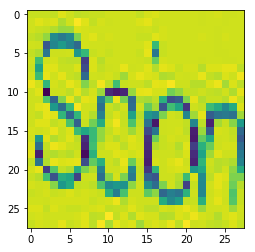

./mjsynth_dataset/train/450_conservatives_16248.jpg
Image Shape Before Resize: (31, 213)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/450_conservatives_16248.jpg
Label: conservatives | Encoded Label: [28 40 39 44 30 43 47 26 45 34 47 30 44  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 39 44 30 43 47 26 45 34 47 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


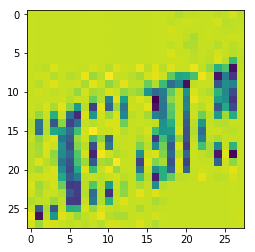

./mjsynth_dataset/train/451_fused_31367.jpg
Image Shape Before Resize: (32, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/451_fused_31367.jpg
Label: fused | Encoded Label: [31 46 44 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 46 44 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


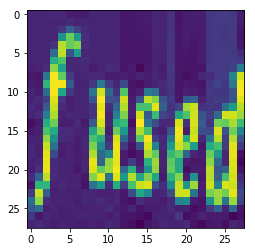

./mjsynth_dataset/train/452_Tingle_79204.jpg
Image Shape Before Resize: (31, 78)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/452_Tingle_79204.jpg
Label: Tingle | Encoded Label: [19 34 39 32 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 34 39 32 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


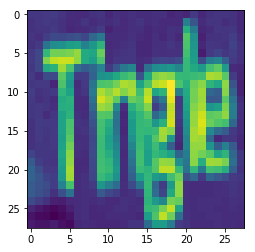

./mjsynth_dataset/train/453_rematch_64478.jpg
Image Shape Before Resize: (31, 134)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/453_rematch_64478.jpg
Label: rematch | Encoded Label: [43 30 38 26 45 28 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 30 38 26 45 28 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


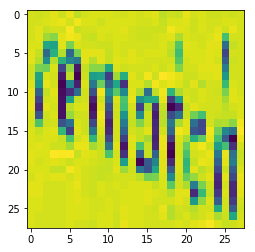

./mjsynth_dataset/train/454_Mobsters_49234.jpg
Image Shape Before Resize: (32, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/454_Mobsters_49234.jpg
Label: Mobsters | Encoded Label: [12 40 27 44 45 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 40 27 44 45 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


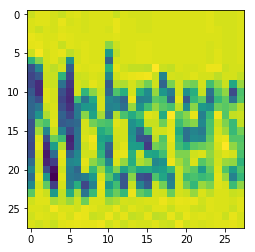

./mjsynth_dataset/train/455_physicist_57391.jpg
Image Shape Before Resize: (32, 96)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/455_physicist_57391.jpg
Label: physicist | Encoded Label: [41 33 50 44 34 28 34 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 33 50 44 34 28 34 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


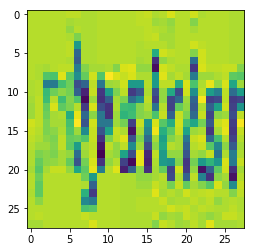

./mjsynth_dataset/train/456_Hipped_36233.jpg
Image Shape Before Resize: (31, 76)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/456_Hipped_36233.jpg
Label: Hipped | Encoded Label: [ 7 34 41 41 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 34 41 41 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


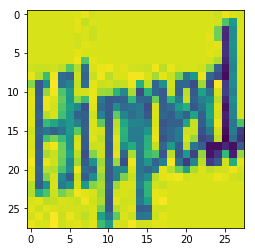

./mjsynth_dataset/train/457_Lobotomizes_44983.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/457_Lobotomizes_44983.jpg
Label: Lobotomizes | Encoded Label: [11 40 27 40 45 40 38 34 51 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 40 27 40 45 40 38 34 51 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


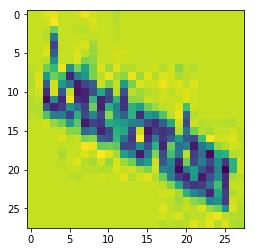

./mjsynth_dataset/train/458_washerwomen_85553.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/458_washerwomen_85553.jpg
Label: washerwomen | Encoded Label: [48 26 44 33 30 43 48 40 38 30 39  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 48 26 44 33 30 43 48 40 38 30 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


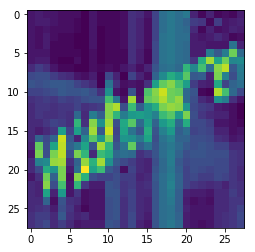

./mjsynth_dataset/train/459_tamped_77395.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/459_tamped_77395.jpg
Label: tamped | Encoded Label: [45 26 38 41 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 26 38 41 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


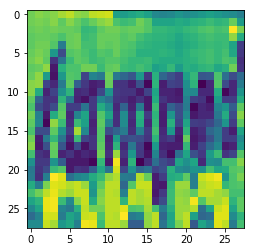

./mjsynth_dataset/train/45_CHERISH_13045.jpg
Image Shape Before Resize: (31, 121)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/45_CHERISH_13045.jpg
Label: CHERISH | Encoded Label: [ 2  7  4 17  8 18  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 7 4 17 8 18 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


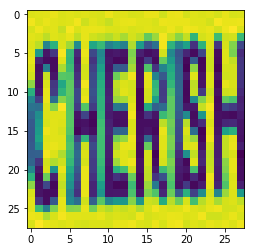

./mjsynth_dataset/train/460_Kibitzed_42405.jpg
Image Shape Before Resize: (31, 103)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/460_Kibitzed_42405.jpg
Label: Kibitzed | Encoded Label: [10 34 27 34 45 51 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 34 27 34 45 51 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


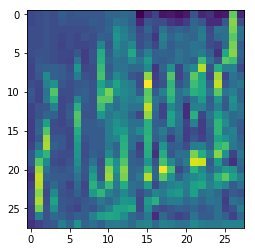

./mjsynth_dataset/train/461_EFFACING_24700.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/461_EFFACING_24700.jpg
Label: EFFACING | Encoded Label: [ 4  5  5  0  2  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 5 5 0 2 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


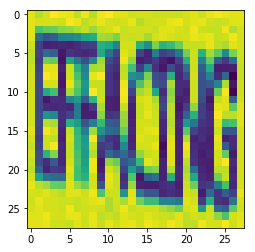

./mjsynth_dataset/train/462_mots_50039.jpg
Image Shape Before Resize: (31, 47)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/462_mots_50039.jpg
Label: mots | Encoded Label: [38 40 45 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 40 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


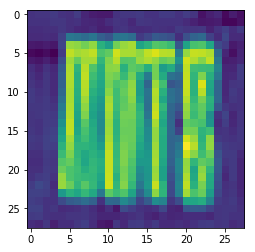

./mjsynth_dataset/train/463_Unquestioned_83027.jpg
Image Shape Before Resize: (31, 143)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/463_Unquestioned_83027.jpg
Label: Unquestioned | Encoded Label: [20 39 42 46 30 44 45 34 40 39 30 29  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 42 46 30 44 45 34 40 39 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


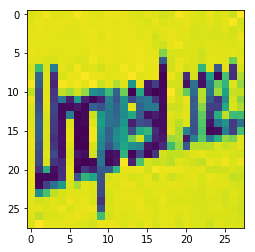

./mjsynth_dataset/train/464_convulses_16806.jpg
Image Shape Before Resize: (31, 86)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/464_convulses_16806.jpg
Label: convulses | Encoded Label: [28 40 39 47 46 37 44 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 39 47 46 37 44 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


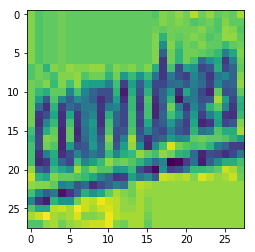

./mjsynth_dataset/train/465_credos_17972.jpg
Image Shape Before Resize: (31, 120)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/465_credos_17972.jpg
Label: credos | Encoded Label: [28 43 30 29 40 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 43 30 29 40 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


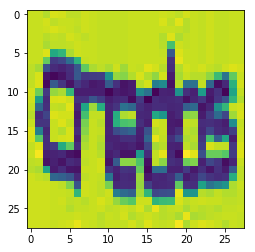

./mjsynth_dataset/train/466_Ericka_26389.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/466_Ericka_26389.jpg
Label: Ericka | Encoded Label: [ 4 43 34 28 36 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 43 34 28 36 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


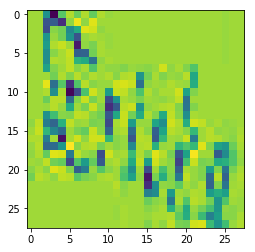

./mjsynth_dataset/train/467_CEREBRATION_12446.jpg
Image Shape Before Resize: (31, 145)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/467_CEREBRATION_12446.jpg
Label: CEREBRATION | Encoded Label: [ 2  4 17  4  1 17  0 19  8 14 13  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 4 17 4 1 17 0 19 8 14 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


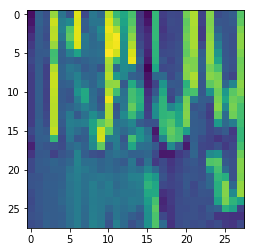

./mjsynth_dataset/train/468_MINISTERING_48643.jpg
Image Shape Before Resize: (31, 146)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/468_MINISTERING_48643.jpg
Label: MINISTERING | Encoded Label: [12  8 13  8 18 19  4 17  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 8 13 8 18 19 4 17 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


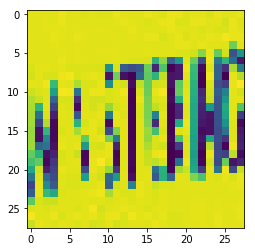

./mjsynth_dataset/train/469_summers_76044.jpg
Image Shape Before Resize: (31, 103)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/469_summers_76044.jpg
Label: summers | Encoded Label: [44 46 38 38 30 43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 46 38 38 30 43 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


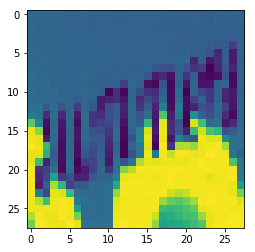

./mjsynth_dataset/train/46_Orating_53621.jpg
Image Shape Before Resize: (31, 93)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/46_Orating_53621.jpg
Label: Orating | Encoded Label: [14 43 26 45 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 14 43 26 45 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


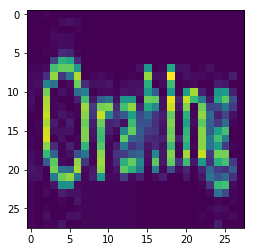

./mjsynth_dataset/train/470_orienteering_53742.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/470_orienteering_53742.jpg
Label: orienteering | Encoded Label: [40 43 34 30 39 45 30 30 43 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 40 43 34 30 39 45 30 30 43 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


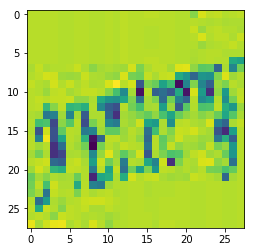

./mjsynth_dataset/train/471_stingiest_74743.jpg
Image Shape Before Resize: (31, 69)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/471_stingiest_74743.jpg
Label: stingiest | Encoded Label: [44 45 34 39 32 34 30 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 45 34 39 32 34 30 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


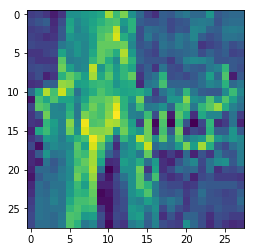

./mjsynth_dataset/train/472_APOSTROPHES_3438.jpg
Image Shape Before Resize: (31, 141)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/472_APOSTROPHES_3438.jpg
Label: APOSTROPHES | Encoded Label: [ 0 15 14 18 19 17 14 15  7  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 15 14 18 19 17 14 15 7 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


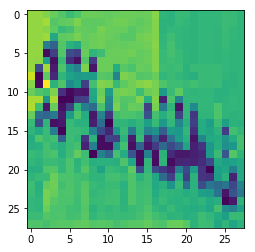

./mjsynth_dataset/train/473_PLOPS_58292.jpg
Image Shape Before Resize: (32, 95)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/473_PLOPS_58292.jpg
Label: PLOPS | Encoded Label: [15 11 14 15 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 11 14 15 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


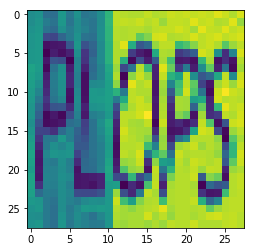

./mjsynth_dataset/train/474_SUBJECTS_75570.jpg
Image Shape Before Resize: (31, 69)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/474_SUBJECTS_75570.jpg
Label: SUBJECTS | Encoded Label: [18 20  1  9  4  2 19 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 20 1 9 4 2 19 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


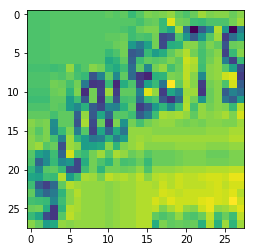

./mjsynth_dataset/train/475_TANTALIZES_77479.jpg
Image Shape Before Resize: (31, 128)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/475_TANTALIZES_77479.jpg
Label: TANTALIZES | Encoded Label: [19  0 13 19  0 11  8 25  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 0 13 19 0 11 8 25 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


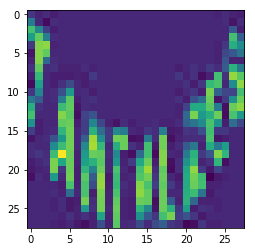

./mjsynth_dataset/train/476_Bowditch_9035.jpg
Image Shape Before Resize: (31, 166)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/476_Bowditch_9035.jpg
Label: Bowditch | Encoded Label: [ 1 40 48 29 34 45 28 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 1 40 48 29 34 45 28 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


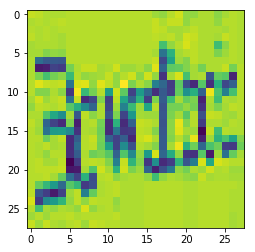

./mjsynth_dataset/train/477_vertexes_84416.jpg
Image Shape Before Resize: (31, 99)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/477_vertexes_84416.jpg
Label: vertexes | Encoded Label: [47 30 43 45 30 49 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 47 30 43 45 30 49 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


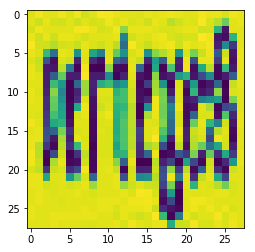

./mjsynth_dataset/train/478_kibbles_42399.jpg
Image Shape Before Resize: (31, 75)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/478_kibbles_42399.jpg
Label: kibbles | Encoded Label: [36 34 27 27 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 36 34 27 27 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


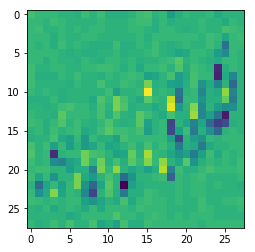

./mjsynth_dataset/train/479_Scoping_68464.jpg
Image Shape Before Resize: (31, 101)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/479_Scoping_68464.jpg
Label: Scoping | Encoded Label: [18 28 40 41 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 28 40 41 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


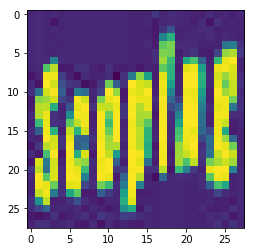

./mjsynth_dataset/train/47_RACKS_62074.jpg
Image Shape Before Resize: (31, 97)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/47_RACKS_62074.jpg
Label: RACKS | Encoded Label: [17  0  2 10 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 0 2 10 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


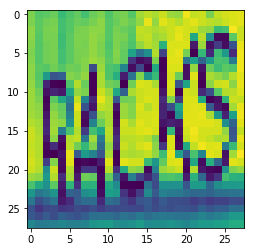

./mjsynth_dataset/train/480_nonsmoker_52160.jpg
Image Shape Before Resize: (31, 118)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/480_nonsmoker_52160.jpg
Label: nonsmoker | Encoded Label: [39 40 39 44 38 40 36 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 39 40 39 44 38 40 36 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


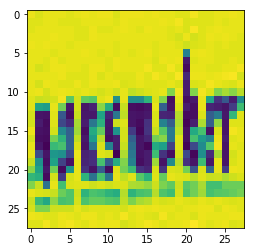

./mjsynth_dataset/train/481_destinations_21094.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/481_destinations_21094.jpg
Label: destinations | Encoded Label: [29 30 44 45 34 39 26 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 30 44 45 34 39 26 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


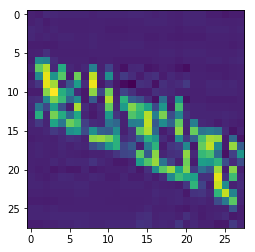

./mjsynth_dataset/train/482_traipsing_80091.jpg
Image Shape Before Resize: (31, 100)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/482_traipsing_80091.jpg
Label: traipsing | Encoded Label: [45 43 26 34 41 44 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 43 26 34 41 44 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


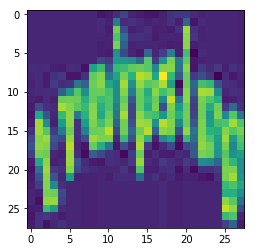

./mjsynth_dataset/train/483_standardizes_74219.jpg
Image Shape Before Resize: (31, 203)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/483_standardizes_74219.jpg
Label: standardizes | Encoded Label: [44 45 26 39 29 26 43 29 34 51 30 44  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 45 26 39 29 26 43 29 34 51 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


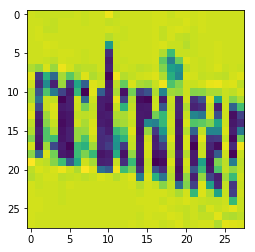

./mjsynth_dataset/train/484_CONSTRAINING_16375.jpg
Image Shape Before Resize: (31, 155)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/484_CONSTRAINING_16375.jpg
Label: CONSTRAINING | Encoded Label: [ 2 14 13 18 19 17  0  8 13  8 13  6  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 13 18 19 17 0 8 13 8 13 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


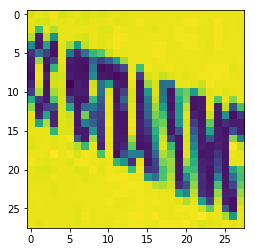

./mjsynth_dataset/train/485_Putts_61519.jpg
Image Shape Before Resize: (31, 87)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/485_Putts_61519.jpg
Label: Putts | Encoded Label: [15 46 45 45 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 46 45 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


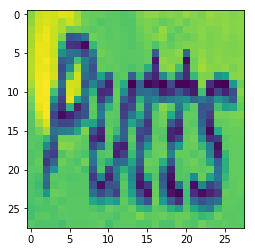

./mjsynth_dataset/train/486_Aircrew_1730.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/486_Aircrew_1730.jpg
Label: Aircrew | Encoded Label: [ 0 34 43 28 43 30 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 34 43 28 43 30 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


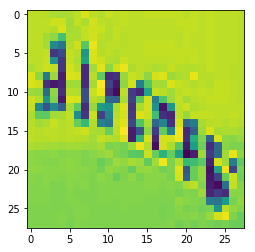

./mjsynth_dataset/train/487_indolent_39112.jpg
Image Shape Before Resize: (31, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/487_indolent_39112.jpg
Label: indolent | Encoded Label: [34 39 29 40 37 30 39 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 34 39 29 40 37 30 39 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


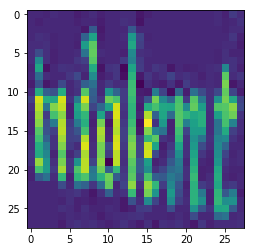

./mjsynth_dataset/train/488_Catnip_12076.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/488_Catnip_12076.jpg
Label: Catnip | Encoded Label: [ 2 26 45 39 34 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 26 45 39 34 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


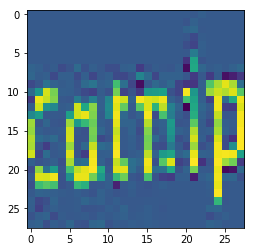

./mjsynth_dataset/train/489_notability_52348.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/489_notability_52348.jpg
Label: notability | Encoded Label: [39 40 45 26 27 34 37 34 45 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 39 40 45 26 27 34 37 34 45 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


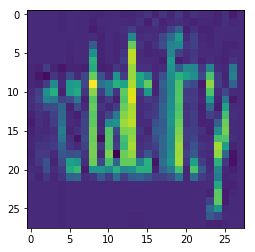

./mjsynth_dataset/train/48_inconceivability_38810.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/48_inconceivability_38810.jpg
Label: inconceivability | Encoded Label: [34 39 28 40 39 28 30 34 47 26 27 34 37 34 45 50  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 34 39 28 40 39 28 30 34 47 26 27 34 37 34 45 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


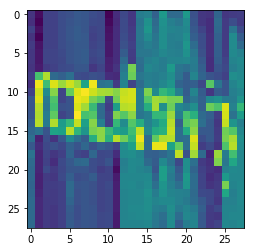

./mjsynth_dataset/train/490_KNUTH_42815.jpg
Image Shape Before Resize: (31, 78)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/490_KNUTH_42815.jpg
Label: KNUTH | Encoded Label: [10 13 20 19  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 10 13 20 19 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


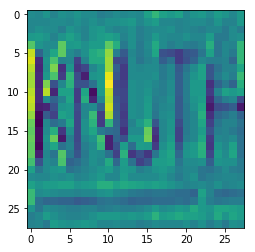

./mjsynth_dataset/train/491_COMBERS_15079.jpg
Image Shape Before Resize: (32, 105)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/491_COMBERS_15079.jpg
Label: COMBERS | Encoded Label: [ 2 14 12  1  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 14 12 1 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


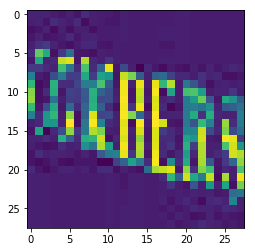

./mjsynth_dataset/train/492_Networks_51378.jpg
Image Shape Before Resize: (31, 117)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/492_Networks_51378.jpg
Label: Networks | Encoded Label: [13 30 45 48 40 43 36 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 30 45 48 40 43 36 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


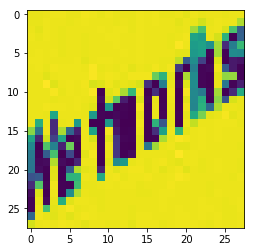

./mjsynth_dataset/train/493_Symposiums_76984.jpg
Image Shape Before Resize: (31, 190)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/493_Symposiums_76984.jpg
Label: Symposiums | Encoded Label: [18 50 38 41 40 44 34 46 38 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 50 38 41 40 44 34 46 38 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


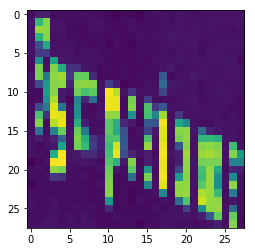

./mjsynth_dataset/train/494_paw_56033.jpg
Image Shape Before Resize: (31, 53)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/494_paw_56033.jpg
Label: paw | Encoded Label: [41 26 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 26 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


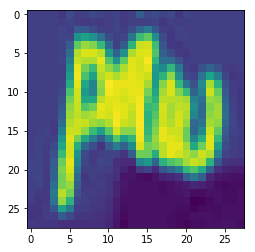

./mjsynth_dataset/train/495_Indomitable_39114.jpg
Image Shape Before Resize: (31, 163)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/495_Indomitable_39114.jpg
Label: Indomitable | Encoded Label: [ 8 39 29 40 38 34 45 26 27 37 30  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 39 29 40 38 34 45 26 27 37 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


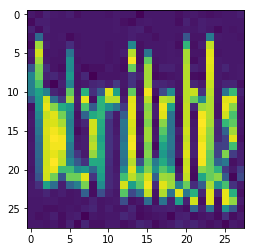

./mjsynth_dataset/train/496_Maidenhair_46087.jpg
Image Shape Before Resize: (31, 130)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/496_Maidenhair_46087.jpg
Label: Maidenhair | Encoded Label: [12 26 34 29 30 39 33 26 34 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 26 34 29 30 39 33 26 34 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


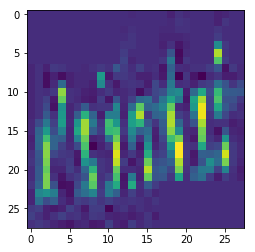

./mjsynth_dataset/train/497_INFERNO_39310.jpg
Image Shape Before Resize: (31, 129)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/497_INFERNO_39310.jpg
Label: INFERNO | Encoded Label: [ 8 13  5  4 17 13 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 13 5 4 17 13 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


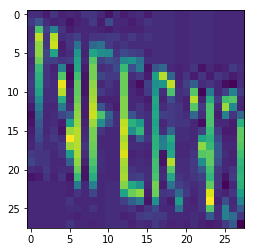

./mjsynth_dataset/train/498_Joist_41685.jpg
Image Shape Before Resize: (31, 132)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/498_Joist_41685.jpg
Label: Joist | Encoded Label: [ 9 40 34 44 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 9 40 34 44 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


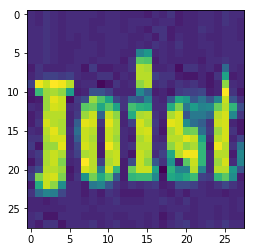

./mjsynth_dataset/train/499_dishpans_22334.jpg
Image Shape Before Resize: (31, 76)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/499_dishpans_22334.jpg
Label: dishpans | Encoded Label: [29 34 44 33 41 26 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 34 44 33 41 26 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


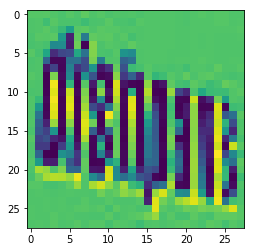

./mjsynth_dataset/train/49_MULTILATERAL_50331.jpg
Image Shape Before Resize: (31, 202)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/49_MULTILATERAL_50331.jpg
Label: MULTILATERAL | Encoded Label: [12 20 11 19  8 11  0 19  4 17  0 11  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 20 11 19 8 11 0 19 4 17 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


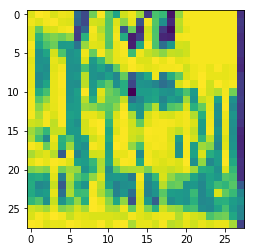

./mjsynth_dataset/train/4_vacant_83816.jpg
Image Shape Before Resize: (31, 104)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/4_vacant_83816.jpg
Label: vacant | Encoded Label: [47 26 28 26 39 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 47 26 28 26 39 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


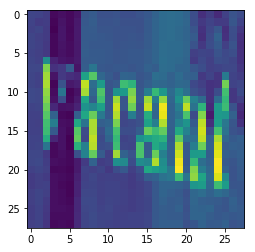

./mjsynth_dataset/train/500_Strongman_75291.jpg
Image Shape Before Resize: (31, 100)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/500_Strongman_75291.jpg
Label: Strongman | Encoded Label: [18 45 43 40 39 32 38 26 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 45 43 40 39 32 38 26 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


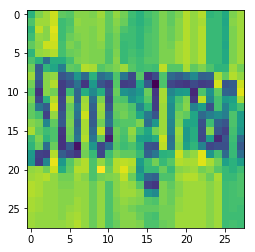

./mjsynth_dataset/train/501_punctuation_61259.jpg
Image Shape Before Resize: (31, 175)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/501_punctuation_61259.jpg
Label: punctuation | Encoded Label: [41 46 39 28 45 46 26 45 34 40 39  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 41 46 39 28 45 46 26 45 34 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


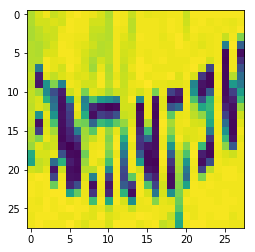

./mjsynth_dataset/train/50_afdc_1383.jpg
Image Shape Before Resize: (31, 60)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/50_afdc_1383.jpg
Label: afdc | Encoded Label: [26 31 29 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 26 31 29 28 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


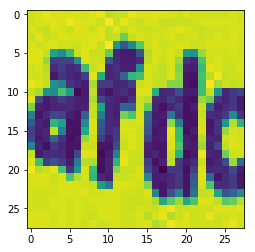

./mjsynth_dataset/train/51_resided_65151.jpg
Image Shape Before Resize: (31, 107)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/51_resided_65151.jpg
Label: resided | Encoded Label: [43 30 44 34 29 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 43 30 44 34 29 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


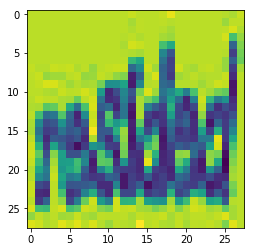

./mjsynth_dataset/train/52_utahans_83765.jpg
Image Shape Before Resize: (31, 249)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/52_utahans_83765.jpg
Label: utahans | Encoded Label: [46 45 26 33 26 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 46 45 26 33 26 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


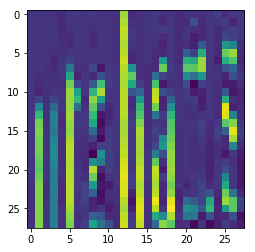

./mjsynth_dataset/train/53_DISSENTERS_22665.jpg
Image Shape Before Resize: (31, 178)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/53_DISSENTERS_22665.jpg
Label: DISSENTERS | Encoded Label: [ 3  8 18 18  4 13 19  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 8 18 18 4 13 19 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


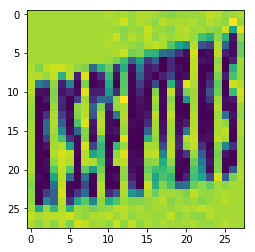

./mjsynth_dataset/train/54_linus_44677.jpg
Image Shape Before Resize: (31, 48)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/54_linus_44677.jpg
Label: linus | Encoded Label: [37 34 39 46 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 37 34 39 46 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


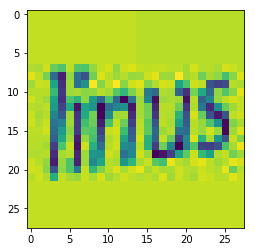

./mjsynth_dataset/train/55_UNENVIABLE_82391.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/55_UNENVIABLE_82391.jpg
Label: UNENVIABLE | Encoded Label: [20 13  4 13 21  8  0  1 11  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 13 4 13 21 8 0 1 11 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


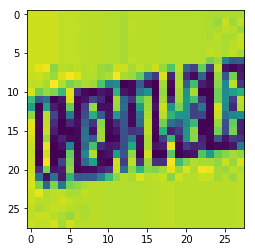

./mjsynth_dataset/train/56_Unknowns_82782.jpg
Image Shape Before Resize: (31, 124)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/56_Unknowns_82782.jpg
Label: Unknowns | Encoded Label: [20 39 36 39 40 48 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 20 39 36 39 40 48 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


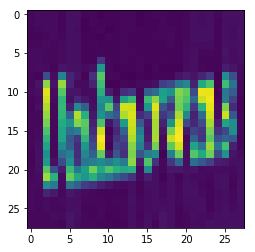

./mjsynth_dataset/train/57_Rather_62537.jpg
Image Shape Before Resize: (31, 92)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/57_Rather_62537.jpg
Label: Rather | Encoded Label: [17 26 45 33 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 26 45 33 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


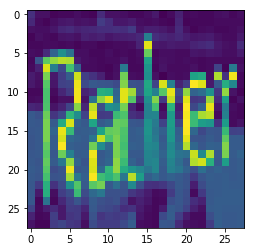

./mjsynth_dataset/train/58_Telemarketer_77969.jpg
Image Shape Before Resize: (31, 190)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/58_Telemarketer_77969.jpg
Label: Telemarketer | Encoded Label: [19 30 37 30 38 26 43 36 30 45 30 43  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 30 37 30 38 26 43 36 30 45 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


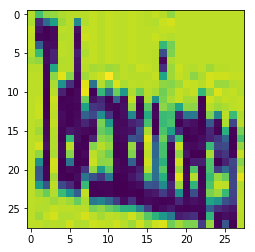

./mjsynth_dataset/train/59_MISBEHAVES_48795.jpg
Image Shape Before Resize: (31, 237)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/59_MISBEHAVES_48795.jpg
Label: MISBEHAVES | Encoded Label: [12  8 18  1  4  7  0 21  4 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 8 18 1 4 7 0 21 4 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


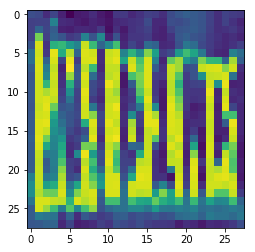

./mjsynth_dataset/train/5_PROMPTINGS_60541.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/5_PROMPTINGS_60541.jpg
Label: PROMPTINGS | Encoded Label: [15 17 14 12 15 19  8 13  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 17 14 12 15 19 8 13 6 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


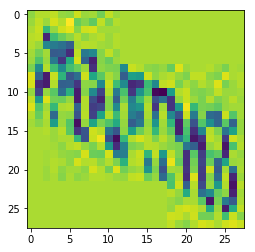

./mjsynth_dataset/train/60_Sisterliness_71163.jpg
Image Shape Before Resize: (32, 193)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/60_Sisterliness_71163.jpg
Label: Sisterliness | Encoded Label: [18 34 44 45 30 43 37 34 39 30 44 44  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 34 44 45 30 43 37 34 39 30 44 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


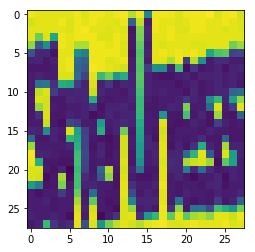

./mjsynth_dataset/train/61_fruitful_31093.jpg
Image Shape Before Resize: (31, 61)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/61_fruitful_31093.jpg
Label: fruitful | Encoded Label: [31 43 46 34 45 31 46 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 31 43 46 34 45 31 46 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


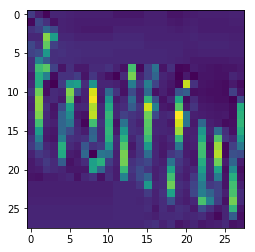

./mjsynth_dataset/train/62_RANKNESS_62404.jpg
Image Shape Before Resize: (31, 133)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/62_RANKNESS_62404.jpg
Label: RANKNESS | Encoded Label: [17  0 13 10 13  4 18 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 0 13 10 13 4 18 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


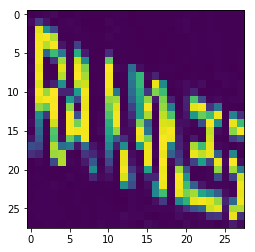

./mjsynth_dataset/train/63_EYETEETH_27775.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/63_EYETEETH_27775.jpg
Label: EYETEETH | Encoded Label: [ 4 24  4 19  4  4 19  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 4 24 4 19 4 4 19 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


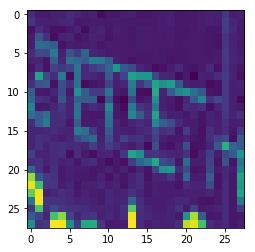

./mjsynth_dataset/train/64_cryptography_18477.jpg
Image Shape Before Resize: (31, 149)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/64_cryptography_18477.jpg
Label: cryptography | Encoded Label: [28 43 50 41 45 40 32 43 26 41 33 50  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 43 50 41 45 40 32 43 26 41 33 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


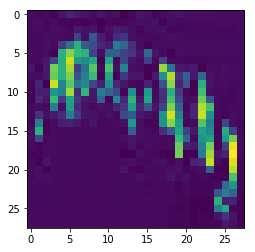

./mjsynth_dataset/train/65_AZERBAIJANIS_5221.jpg
Image Shape Before Resize: (31, 110)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/65_AZERBAIJANIS_5221.jpg
Label: AZERBAIJANIS | Encoded Label: [ 0 25  4 17  1  0  8  9  0 13  8 18  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 25 4 17 1 0 8 9 0 13 8 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


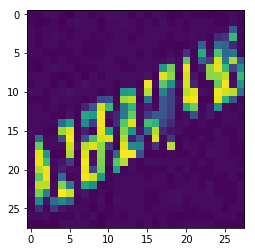

./mjsynth_dataset/train/66_astrophysical_4542.jpg
Image Shape Before Resize: (31, 156)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/66_astrophysical_4542.jpg
Label: astrophysical | Encoded Label: [26 44 45 43 40 41 33 50 44 34 28 26 37  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 26 44 45 43 40 41 33 50 44 34 28 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


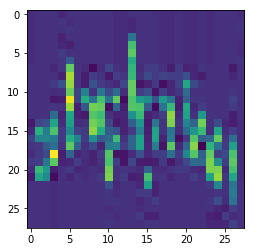

./mjsynth_dataset/train/67_deckchair_19740.jpg
Image Shape Before Resize: (31, 185)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/67_deckchair_19740.jpg
Label: deckchair | Encoded Label: [29 30 28 36 28 33 26 34 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 30 28 36 28 33 26 34 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


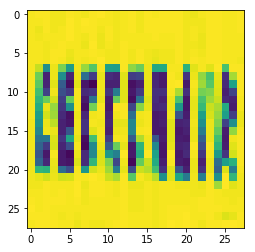

./mjsynth_dataset/train/68_MURMURS_50475.jpg
Image Shape Before Resize: (31, 105)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/68_MURMURS_50475.jpg
Label: MURMURS | Encoded Label: [12 20 17 12 20 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 20 17 12 20 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


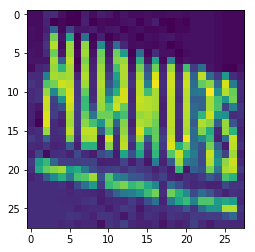

./mjsynth_dataset/train/69_dardanelles_19224.jpg
Image Shape Before Resize: (31, 166)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/69_dardanelles_19224.jpg
Label: dardanelles | Encoded Label: [29 26 43 29 26 39 30 37 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 29 26 43 29 26 39 30 37 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


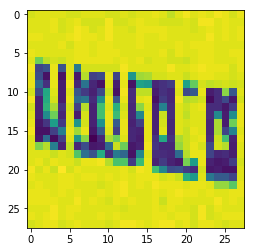

./mjsynth_dataset/train/6_DEADPANS_19463.jpg
Image Shape Before Resize: (31, 144)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/6_DEADPANS_19463.jpg
Label: DEADPANS | Encoded Label: [ 3  4  0  3 15  0 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 4 0 3 15 0 13 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


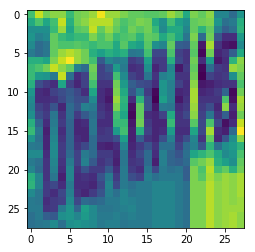

./mjsynth_dataset/train/70_Maya_47270.jpg
Image Shape Before Resize: (31, 61)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/70_Maya_47270.jpg
Label: Maya | Encoded Label: [12 26 50 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 12 26 50 26 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


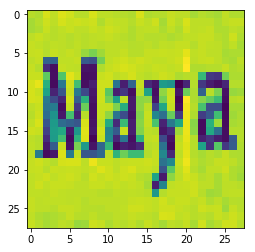

./mjsynth_dataset/train/71_telegraphy_77964.jpg
Image Shape Before Resize: (31, 80)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/71_telegraphy_77964.jpg
Label: telegraphy | Encoded Label: [45 30 37 30 32 43 26 41 33 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 45 30 37 30 32 43 26 41 33 50 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


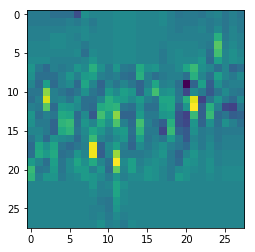

./mjsynth_dataset/train/72_Stylizing_75480.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/72_Stylizing_75480.jpg
Label: Stylizing | Encoded Label: [18 45 50 37 34 51 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 45 50 37 34 51 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


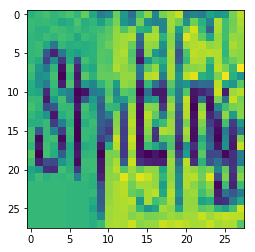

./mjsynth_dataset/train/73_Dances_19157.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/73_Dances_19157.jpg
Label: Dances | Encoded Label: [ 3 26 39 28 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 3 26 39 28 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


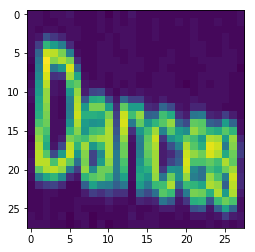

./mjsynth_dataset/train/74_confident_15914.jpg
Image Shape Before Resize: (31, 173)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/74_confident_15914.jpg
Label: confident | Encoded Label: [28 40 39 31 34 29 30 39 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 28 40 39 31 34 29 30 39 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


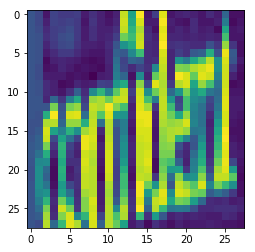

./mjsynth_dataset/train/75_boreholes_8861.jpg
Image Shape Before Resize: (31, 159)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/75_boreholes_8861.jpg
Label: boreholes | Encoded Label: [27 40 43 30 33 40 37 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 27 40 43 30 33 40 37 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


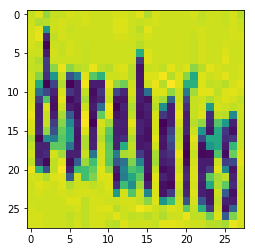

./mjsynth_dataset/train/76_PILCOMAYO_57594.jpg
Image Shape Before Resize: (31, 142)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/76_PILCOMAYO_57594.jpg
Label: PILCOMAYO | Encoded Label: [15  8 11  2 14 12  0 24 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 8 11 2 14 12 0 24 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


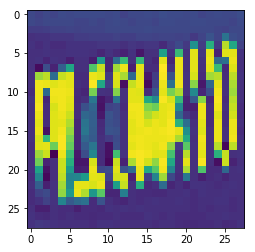

./mjsynth_dataset/train/77_Activated_868.jpg
Image Shape Before Resize: (32, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/77_Activated_868.jpg
Label: Activated | Encoded Label: [ 0 28 45 34 47 26 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 28 45 34 47 26 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


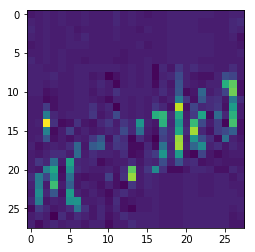

./mjsynth_dataset/train/78_Fractions_30580.jpg
Image Shape Before Resize: (31, 116)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/78_Fractions_30580.jpg
Label: Fractions | Encoded Label: [ 5 43 26 28 45 34 40 39 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 5 43 26 28 45 34 40 39 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


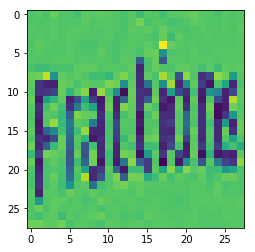

./mjsynth_dataset/train/79_Clairvoyants_13859.jpg
Image Shape Before Resize: (31, 177)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/79_Clairvoyants_13859.jpg
Label: Clairvoyants | Encoded Label: [ 2 37 26 34 43 47 40 50 26 39 45 44  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 2 37 26 34 43 47 40 50 26 39 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


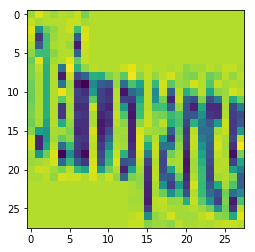

./mjsynth_dataset/train/7_HERMETICAL_35904.jpg
Image Shape Before Resize: (31, 207)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/7_HERMETICAL_35904.jpg
Label: HERMETICAL | Encoded Label: [ 7  4 17 12  4 19  8  2  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 4 17 12 4 19 8 2 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


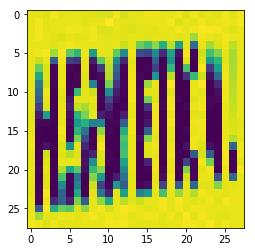

./mjsynth_dataset/train/80_supplicated_76347.jpg
Image Shape Before Resize: (31, 125)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/80_supplicated_76347.jpg
Label: supplicated | Encoded Label: [44 46 41 41 37 34 28 26 45 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 44 46 41 41 37 34 28 26 45 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


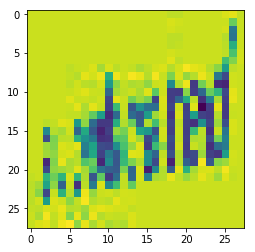

./mjsynth_dataset/train/81_Netherlands_51358.jpg
Image Shape Before Resize: (31, 210)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/81_Netherlands_51358.jpg
Label: Netherlands | Encoded Label: [13 30 45 33 30 43 37 26 39 29 44  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 30 45 33 30 43 37 26 39 29 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


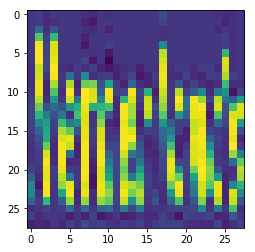

./mjsynth_dataset/train/82_ALLIANCE_2113.jpg
Image Shape Before Resize: (31, 67)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/82_ALLIANCE_2113.jpg
Label: ALLIANCE | Encoded Label: [ 0 11 11  8  0 13  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 0 11 11 8 0 13 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


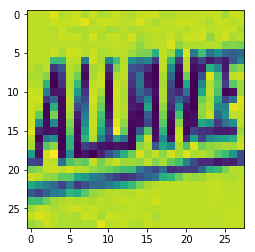

./mjsynth_dataset/train/83_Natalie_50955.jpg
Image Shape Before Resize: (31, 153)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/83_Natalie_50955.jpg
Label: Natalie | Encoded Label: [13 26 45 26 37 34 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 13 26 45 26 37 34 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


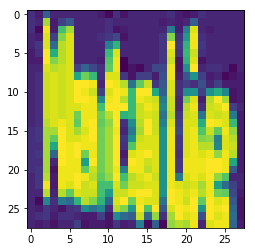

./mjsynth_dataset/train/84_linebacker_44610.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/84_linebacker_44610.jpg
Label: linebacker | Encoded Label: [37 34 39 30 27 26 28 36 30 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 37 34 39 30 27 26 28 36 30 43 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


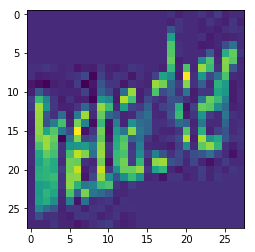

./mjsynth_dataset/train/85_WYOMINGITE_87516.jpg
Image Shape Before Resize: (32, 168)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/85_WYOMINGITE_87516.jpg
Label: WYOMINGITE | Encoded Label: [22 24 14 12  8 13  6  8 19  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 22 24 14 12 8 13 6 8 19 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


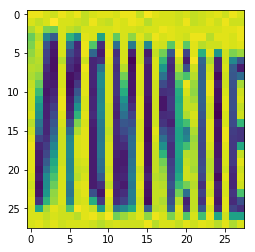

./mjsynth_dataset/train/86_moises_49357.jpg
Image Shape Before Resize: (31, 89)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/86_moises_49357.jpg
Label: moises | Encoded Label: [38 40 34 44 30 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 38 40 34 44 30 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


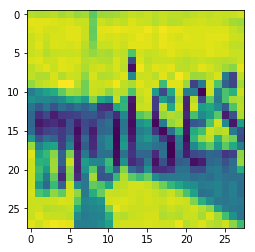

./mjsynth_dataset/train/87_Stirrups_74788.jpg
Image Shape Before Resize: (31, 88)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/87_Stirrups_74788.jpg
Label: Stirrups | Encoded Label: [18 45 34 43 43 46 41 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 18 45 34 43 43 46 41 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


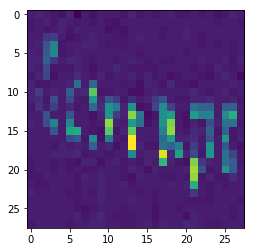

./mjsynth_dataset/train/88_LAPELS_43364.jpg
Image Shape Before Resize: (31, 77)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/88_LAPELS_43364.jpg
Label: LAPELS | Encoded Label: [11  0 15  4 11 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 0 15 4 11 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


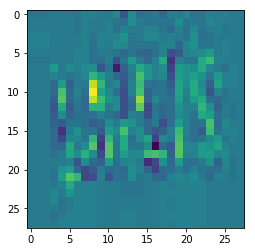

./mjsynth_dataset/train/89_valuation_83957.jpg
Image Shape Before Resize: (31, 97)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/89_valuation_83957.jpg
Label: valuation | Encoded Label: [47 26 37 46 26 45 34 40 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 47 26 37 46 26 45 34 40 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


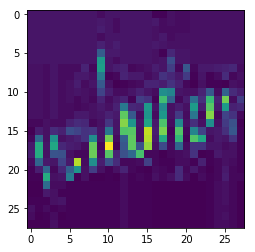

./mjsynth_dataset/train/8_Hived_36322.jpg
Image Shape Before Resize: (31, 83)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/8_Hived_36322.jpg
Label: Hived | Encoded Label: [ 7 34 47 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 34 47 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


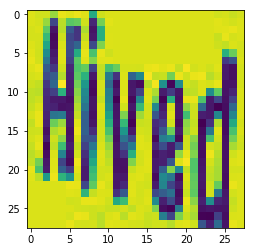

./mjsynth_dataset/train/90_Hobnobs_36388.jpg
Image Shape Before Resize: (31, 113)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/90_Hobnobs_36388.jpg
Label: Hobnobs | Encoded Label: [ 7 40 27 39 40 27 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 7 40 27 39 40 27 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


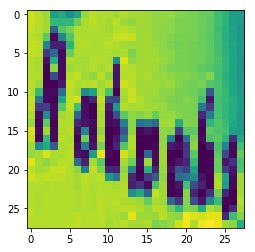

./mjsynth_dataset/train/91_nomadic_51853.jpg
Image Shape Before Resize: (31, 114)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/91_nomadic_51853.jpg
Label: nomadic | Encoded Label: [39 40 38 26 29 34 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 39 40 38 26 29 34 28 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


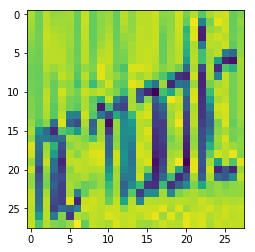

./mjsynth_dataset/train/92_Respecting_65256.jpg
Image Shape Before Resize: (31, 149)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/92_Respecting_65256.jpg
Label: Respecting | Encoded Label: [17 30 44 41 30 28 45 34 39 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 17 30 44 41 30 28 45 34 39 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


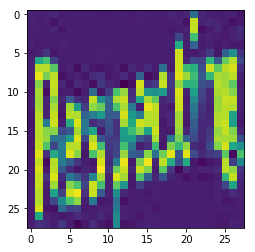

./mjsynth_dataset/train/93_Teethed_77917.jpg
Image Shape Before Resize: (31, 95)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/93_Teethed_77917.jpg
Label: Teethed | Encoded Label: [19 30 30 45 33 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 30 30 45 33 30 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


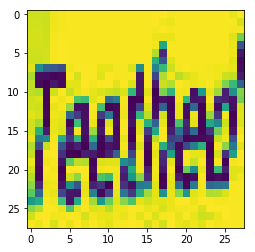

./mjsynth_dataset/train/94_Parasitical_55494.jpg
Image Shape Before Resize: (31, 141)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/94_Parasitical_55494.jpg
Label: Parasitical | Encoded Label: [15 26 43 26 44 34 45 34 28 26 37  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 15 26 43 26 44 34 45 34 28 26 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


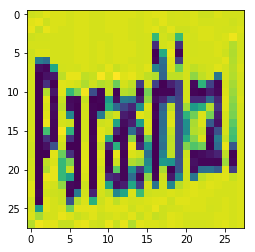

./mjsynth_dataset/train/95_hereabouts_35869.jpg
Image Shape Before Resize: (31, 95)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/95_hereabouts_35869.jpg
Label: hereabouts | Encoded Label: [33 30 43 30 26 27 40 46 45 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 33 30 43 30 26 27 40 46 45 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


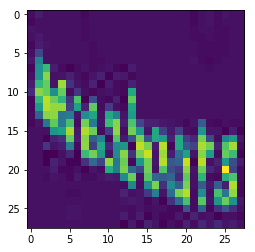

./mjsynth_dataset/train/96_JOIST_41685.jpg
Image Shape Before Resize: (31, 69)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/96_JOIST_41685.jpg
Label: JOIST | Encoded Label: [ 9 14  8 18 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 9 14 8 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


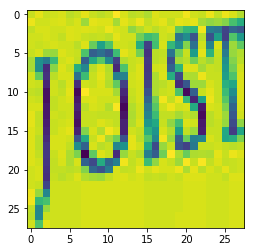

./mjsynth_dataset/train/97_INTENT_40093.jpg
Image Shape Before Resize: (31, 68)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/97_INTENT_40093.jpg
Label: INTENT | Encoded Label: [ 8 13 19  4 13 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 13 19 4 13 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


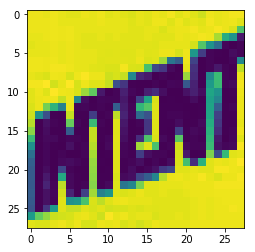

./mjsynth_dataset/train/98_TROUPERS_80880.jpg
Image Shape Before Resize: (31, 147)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/98_TROUPERS_80880.jpg
Label: TROUPERS | Encoded Label: [19 17 14 20 15  4 17 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 19 17 14 20 15 4 17 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


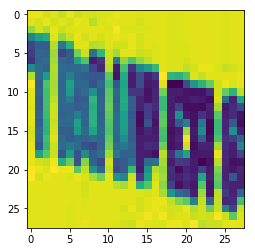

./mjsynth_dataset/train/99_Inconvenient_38851.jpg
Image Shape Before Resize: (31, 183)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/99_Inconvenient_38851.jpg
Label: Inconvenient | Encoded Label: [ 8 39 28 40 39 47 30 39 34 30 39 45  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 8 39 28 40 39 47 30 39 34 30 39 45 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


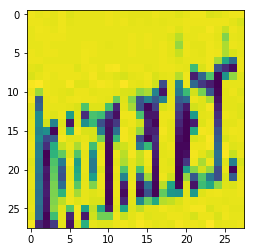

./mjsynth_dataset/train/9_LINGO_44635.jpg
Image Shape Before Resize: (31, 82)
Image Shape After Resize: (28, 28)
Filepath: ./mjsynth_dataset/train/9_LINGO_44635.jpg
Label: LINGO | Encoded Label: [11  8 13  6 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Encoded Label String: 11 8 13 6 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


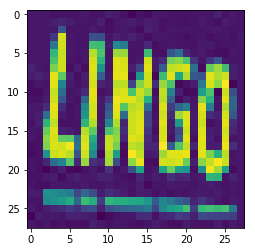

In [7]:
dataset = Dataset('./mjsynth_dataset/train/', img_width, img_height, batch_size, 32)
dataset.build_data()

In [8]:
# dataset parameters 
img_width = img_height = 28
num_channels = 1
annotation_train = './mjsynth_dataset/annotation_train_small_100.txt'

# training parameters
learning_rate = .0001
num_steps = 500
batch_size = 128
display_step = 10

# network parameters
num_input = 784 # input image size (img_width = 64, img_height = 64)
num_output = 32 # 100 output nodes so every letter can be output
num_classes = len(letters)
dropout = .75 # dropout, probablility of keeping units

# Tensorflow graph input
X = tf.placeholder(tf.float32, shape=(batch_size, img_width, img_height), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_output), name="Y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

In [9]:
assert dataset.imgs.shape[0] == dataset.labels.shape[0] == dataset.encoded_labels.shape[0] == dataset.encoded_label_strings.shape[0]
print(dataset.imgs.shape)
print(dataset.labels.shape)
print(dataset.encoded_labels.shape)
print(dataset.encoded_label_strings.shape)

imgs_placeholder = tf.placeholder(dtype=np.float32, 
                                  shape=[batch_size, img_width, img_height],
                                  name="imgs_placeholder")
labels_placeholder = tf.placeholder(dtype=object, 
                                    shape=[batch_size, None],
                                    name="labels_placeholder")
encoded_labels_placeholder = tf.placeholder(dtype=object, 
                                            shape=[batch_size, num_output],
                                            name="encoded_labels_placeholder")
encoded_label_strings_placeholder = tf.placeholder(dtype=object, 
                                                   shape=[batch_size, 1],
                                                   name="encoded_label_strings_placeholder")

tf_dataset = tf.data.Dataset.from_tensor_slices((imgs_placeholder, encoded_labels_placeholder))
# tf_dataset_2 = tf.data.Dataset.from_tensor_slices((imgs_placeholder))
# iterator = tf_dataset_2.make_initializable_iterator()

iterator = tf_dataset.make_initializable_iterator()
next_sample = iterator.get_next()

(501, 28, 28)
(501,)
(501, 32)
(501, 1)


# Network Layers 

In [10]:
# Convolutional wrapper
# x: [batch size, height, width, # of channels]
# kernel: [height filter, width filter, # of input channels, # of output channels]
# bias: equivalent to number of filters
def conv2d(x, kernels, biases, stride=1):
    layer = tf.nn.conv2d(
        input=x,
        filter=kernels,
        strides=[1,stride,stride,1],
        padding="SAME")
    layer = tf.nn.bias_add(layer, biases)
    return tf.nn.relu(layer)

# Max pooling wrapper
# x: [batch size, height, width, # of channels]
# ksize: size of the window for each dimension of the input tensor
# strides: the stride of the sliding window for each dimension of the input tensor
# padding: padding algorithm
def max_pool2d(x, k=2, stride=2):
    layer = tf.nn.max_pool(
        value=x,
        ksize=[1,k,k,1],
        strides=[1,stride,stride,1],
        padding='SAME')
    return layer

def dense(x, weights, biases, dropout):
    layer = tf.add(tf.matmul(x, weights), biases)
    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, dropout)
    return layer
    

# Network Architecture

In [11]:
def ocr_cnn_net(x, kernels, biases, dropout):
    input_layer = tf.reshape(x, shape=[-1,28,28,1])
    conv1 = conv2d(input_layer, kernels['conv1'], biases['conv1'])
    pool1 = max_pool2d(conv1) 
    conv2 = conv2d(pool1, kernels['conv2'], biases['conv2'])
    pool2 = max_pool2d(conv2)
    shape = weights['dense1'].get_shape().as_list()
    # pool2_flat = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    pool2_flat = tf.reshape(pool2, [-1, shape[0]])
    dense1 = dense(pool2_flat, weights['dense1'], biases['dense1'], dropout)
    output_layer =  tf.add(tf.matmul(dense1, weights['out']), biases['out'])
    return output_layer

In [12]:
# store layer weights and biases
weights = {
    # 5x5 convolution, 1 input, 32 outputs
    'conv1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 convolution, 32 inputs, 64 outputs
    'conv2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected (dense), 7*7*64 inputs, 1024 outputs
    'dense1': tf.Variable(tf.random_normal([64*7*7, 1024])),
    # fully connected (dense), 1024 inputs, 100 outputs (classification of each letter)
    'out': tf.Variable(tf.random_normal([1024, num_output]))  
}

biases = {
    'conv1': tf.Variable(tf.random_normal([32])),
    'conv2': tf.Variable(tf.random_normal([64])),
    'dense1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_output]))  
}

logits = ocr_cnn_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)
# train = optimizer.minimize(cross_entropy)

# accuracy
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

In [13]:
num_steps_per_epoch = dataset.labels.shape[0] / batch_size
num_epochs = 5000 / num_steps_per_epoch

print("Batch Size: " + str(batch_size))
print("# of Samples: " + str(dataset.labels.shape[0]))
print("# of Steps: " + str(5000))
print("# of Steps Per Epoch: " + str(num_steps_per_epoch))
print("# of Epochs: " + str(num_epochs))

Batch Size: 128
# of Samples: 501
# of Steps: 5000
# of Steps Per Epoch: 3.9140625
# of Epochs: 1277.4451097804392


In [14]:
sess = tf.InteractiveSession()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
sess.run(init)
 

for step in range(num_steps):   

    images, labels = dataset.next_batch()
    feed_dict = {X: images, Y: labels, keep_prob: 1.0}
    op, loss, acc = sess.run([optimizer, cross_entropy, accuracy], feed_dict=feed_dict) 

    if step % display_step == 0 or step == 1:
        print("Step " + str(step) + ", Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Optimization Finished!")




Step 0, Loss= 16358675.0000, Training Accuracy= 0.016
Step 1, Loss= 15147627.0000, Training Accuracy= 0.023
Shuffle Indexes
Shuffle Indexes
Step 10, Loss= 13441950.0000, Training Accuracy= 0.070
Shuffle Indexes
Shuffle Indexes
Shuffle Indexes
Step 20, Loss= 19945996.0000, Training Accuracy= 0.133
Shuffle Indexes
Shuffle Indexes
Step 30, Loss= 30561372.0000, Training Accuracy= 0.148
Shuffle Indexes
Shuffle Indexes
Shuffle Indexes
Step 40, Loss= 56528560.0000, Training Accuracy= 0.172
Shuffle Indexes
Shuffle Indexes
Shuffle Indexes
Step 50, Loss= 94421376.0000, Training Accuracy= 0.148
Shuffle Indexes
Shuffle Indexes
Step 60, Loss= 138769184.0000, Training Accuracy= 0.172
Shuffle Indexes
Shuffle Indexes
Shuffle Indexes
Step 70, Loss= 196985312.0000, Training Accuracy= 0.141
Shuffle Indexes
Shuffle Indexes
Step 80, Loss= 329634432.0000, Training Accuracy= 0.188
Shuffle Indexes
Shuffle Indexes
Shuffle Indexes
Step 90, Loss= 420897920.0000, Training Accuracy= 0.141
Shuffle Indexes
Shuffle I